In [1]:
import os
import cv2
import numpy as np
import json
import math
import pandas as pd
from sklearn import preprocessing
from itertools import cycle
from scipy import stats
from scipy.stats import mstats
from scipy.stats.mstats import winsorize
from sklearn.cluster import MiniBatchKMeans, KMeans
import phenograph
import seaborn as sns
from BorutaShap import BorutaShap, load_data

In [2]:
from Libs.Dataset import Dataset

In [482]:
def read_series(image_path):
    """Read all images from path and save it as array
    param path: directory with files, str
    return img_series: array with images, array
    return img_names: list of file names, list
    """
    all_img = []
    img_names = []
    for img_name in sorted(os.listdir(image_path), key=lambda x: int(x.split('.')[0])):
        img = cv2.imread(os.path.join(image_path, img_name), cv2.IMREAD_UNCHANGED)
        all_img.append(img)
        img_names.append(img_name)
    img_series = np.array(all_img)
    return img_names, img_series

 def calculate_properties(contour):
        """
        Calculate properties of contour
        param contour: array with contour coordinates, np.array
        return perimeter: len of the contour, float
        return radius_nuclei: radius of the contour, float
        return size: square of contour, float
        return equi_radius: radius based on square, float
        """
        perimeter = cv2.arcLength(contour, True)
        radius_nuclei = perimeter / (2 * math.pi)
        size = math.fabs(cv2.contourArea(contour))
        equi_radius = np.sqrt(size / math.pi)

        return perimeter, radius_nuclei, size, equi_radius

In [436]:
file_name = 'Fucci'
image_path = 'Dataset/'
channels = ['0', '1', '2']
mask_channel = '2'
result_path = 'Datasets/'
split_file = True

In [141]:
dataset = Dataset(file_name=file_name, image_path=image_path, channels=channels, 
                  mask_channel=mask_channel, result_path=result_path)

In [ ]:
counter = 0
for file in os.listdir(image_path):
    img_series = cv2.imreadmulti(os.path.join(image_path, file), flags=cv2.IMREAD_UNCHANGED)
    img_series = np.array(img_series[1])
    channels = cycle(channels)
    for ind, img in enumerate(img_series):
        if not cv2.imwrite(f'{os.path.join(result_path, next(channels))}/{str(counter)}.tif', img):
            raise Exception('Cannot save image')
    counter += 1
    print(counter)

In [ ]:
if split_file:
    dataset.split_image_series(image_path, file_name, result_path, channels)

In [ ]:
#channels_renaming
renamed_result_path = 'Datasets/renamed/'
for c in channels:
    path = os.path.join(result_path, c)
    print(path)
    os.makedirs(f'{renamed_result_path}{c}', exist_ok=True)
    counter = 0
    for ind in sorted(os.listdir(path), key=lambda x: int(x.split('.')[0])):
        img = cv2.imread(os.path.join(path, ind), cv2.IMREAD_UNCHANGED)
        img = cv2.convertScaleAbs(img)
        norm_img = np.zeros(img.shape)
        img = cv2.normalize(img, norm_img, 0, 255, cv2.NORM_MINMAX)
        cv2.imwrite(f'{renamed_result_path}{c}/{counter}.tif', img)
        counter +=1

In [33]:
masks_dir = 'Masks/Masks/2'
contours_dir = 'Masks/Contours/2'

In [24]:
conturs_path = 'Masks/Contours/2'
counter = 0
for ind in sorted(os.listdir(conturs_path), key=lambda x: int(x.split('.')[0])):
    os.rename(f'{conturs_path}/{ind}', f'{conturs_path}/{counter}.json')
    counter +=1

In [3]:
nuclei_dir = 'Nuclei/'

# Calculate base metrics

In [498]:
nuclei_dir = 'Nuclei/'

In [502]:
mask_path = 'Masks/Masks/2/'

In [529]:
nuclei_summary = []
row = []
for c in channels:
    save_nuclei_path = os.path.join(nuclei_dir, c)
    os.makedirs(save_nuclei_path, exist_ok=True)
    names, img_series = read_series(image_path=os.path.join(result_path, c))
    for ind, img in zip(names, img_series):
        ind = ind.split('.')[0]
        save_nuclei_path = os.path.join(nuclei_dir, c, str(ind))
        os.makedirs(save_nuclei_path, exist_ok=True)
#         mask = cv2.imread(f'{mask_path}{ind}.tif', cv2.IMREAD_UNCHANGED)[:,:,0]
#         new_mask = mask.copy()
#         new_mask[new_mask == 0] = 0
#         new_mask[new_mask > 1] = 255
#         contours, hierarchy = cv2.findContours(new_mask.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        contour_dir = f'{contours_dir}/{ind}.json'
        with open(contour_dir) as file:
            contours = json.load(file)
            contours = np.array(contours['contours'])
        contours = [np.array(x) for x in contours]
        for z in range(0,len(contours)):
            perimeter, radius_nucl, size, equi_radius = calculate_properties(contours[z])
            nucl_ind = str(ind)+'_'+str(z)
            x, y, w, h = cv2.boundingRect(contours[z])
            if ((h/w)>2) or ((w/h)>2):
                continue
            mask2 = np.zeros(img.shape, np.uint8)
            cv2.fillPoly(mask2, pts =[contours[z]], color=(255))
            temp2 = cv2.bitwise_and(img, img, mask=mask2)
            roi = temp2[y:y + h, x:x + w]
            mean_pixel = roi.sum()/len(np.where(roi > 0)[1])
            max_pixel = roi.max()
            row = [file_name, ind, z, nucl_ind,
            perimeter, size, equi_radius, radius_nucl, mean_pixel, max_pixel, c]
            nuclei_summary.append(row)
            cv2.imwrite(f'{save_nuclei_path}/{nucl_ind}.tif', roi)

In [532]:
df_path = 'Dataframes/'
nuclei_df = pd.DataFrame(nuclei_summary, columns = ['series', 'image_id', 'index', 'nucl_ind',
                                         'perimeter', 'size', 'equi_radius', 'radius', 'mean_pixel',
                                         'max_pixel', 'channel'])

nuclei_metric = nuclei_df.drop(columns=['mean_pixel', 'max_pixel', 'channel'])
nuclei_metric = nuclei_metric.drop_duplicates().set_index('nucl_ind').sort_index()
shorted = nuclei_df[['nucl_ind','max_pixel','channel']].fillna(0).drop_duplicates()
shorted2 = shorted.pivot(index='nucl_ind', columns='channel',values='max_pixel')
shorted2 = shorted2.sort_index()
nuclei_metric[['channel_0', 'channel_1', 'channel_2']] = shorted2[['0', '1', '2']]
nuclei_metric = nuclei_metric.fillna(0)
nuclei_metric.to_csv(f'{df_path}/max_metrics.csv')

nuclei_metric = nuclei_df.drop(columns=['mean_pixel', 'max_pixel', 'channel'])
nuclei_metric = nuclei_metric.drop_duplicates().set_index('nucl_ind').sort_index()
shorted = nuclei_df[['nucl_ind','mean_pixel','channel']].fillna(0).drop_duplicates()
shorted2 = shorted.pivot(index='nucl_ind', columns='channel',values='mean_pixel')
shorted2 = shorted2.sort_index()
nuclei_metric[['channel_0', 'channel_1', 'channel_2']] = shorted2[['0', '1', '2']]
nuclei_metric = nuclei_metric.fillna(0)
nuclei_metric.to_csv(f'{df_path}/mean_metrics.csv')

In [222]:
for img_name in os.listdir('Nuclei/2'):
    for nucl_name in os.listdir(f'Nuclei/2/{img_name}'):
        img = cv2.imread(f'Nuclei/2/{img_name}/{nucl_name}', cv2.IMREAD_UNCHANGED)
        cv2.imwrite(f'Nuclei/2_all/{nucl_name}', img)

# Texture

In [534]:
import Libs.classification as classification
from Libs.features_extraction import HaralickFeatures, TAS, \
ZernikeMoments, extract, Preprocess, CenterMass, ChromatinFeatures

In [536]:
len(os.listdir('Nuclei/2_all'))

2230

In [537]:
features = {'features': [HaralickFeatures(), TAS(), ZernikeMoments(None), CenterMass(), ChromatinFeatures()],
            'feat_num' : [13, 54, 25, 2, 4],
            'objects_1' : 2230,
            'object_1_class': 'Fucci'}

In [ ]:
df = classification.dataCollection('Nuclei/2_all', features, preproc_commands = [], normalize=True, enhance=False) 

In [540]:
df

,HaralickFeatures_#01,HaralickFeatures_#02,HaralickFeatures_#03,HaralickFeatures_#04,HaralickFeatures_#05,HaralickFeatures_#06,HaralickFeatures_#07,HaralickFeatures_#08,HaralickFeatures_#09,HaralickFeatures_#10,...,ZernikeMoments_#23,ZernikeMoments_#24,ZernikeMoments_#25,CenterMass_#01,CenterMass_#02,ChromatinFeatures_#01,ChromatinFeatures_#02,ChromatinFeatures_#03,ChromatinFeatures_#04,cell_name
0,0.125101,179.450336,0.976521,3822.331238,0.424626,150.817838,15109.874616,5.907954,7.693654,0.000673,...,0.082668,0.068517,0.009422,63.888862,46.018243,10.0,34.0,24.875000,398.0,0_0
1,0.072191,323.903724,0.971114,5609.816469,0.342503,211.361373,22115.362152,6.553610,8.401243,0.000494,...,0.008837,0.006354,0.022554,33.587719,32.591435,13.0,44.0,26.400000,132.0,0_1
2,0.135271,176.552733,0.985450,6067.631602,0.436118,176.991304,24093.973676,6.315263,8.660872,0.000657,...,0.030834,0.032407,0.028842,50.501887,48.143806,11.0,44.0,25.923077,337.0,0_10
3,0.061495,105.142495,0.986480,3889.917279,0.348759,174.901736,15454.526619,7.115906,9.941519,0.000427,...,0.057155,0.047140,0.002104,84.980768,55.192847,10.0,38.0,20.097561,824.0,0_11
4,0.087914,237.748510,0.984265,7558.648984,0.419170,222.516103,29996.847427,6.742310,9.099680,0.000610,...,0.006021,0.031326,0.005498,50.919653,50.998096,10.0,33.0,18.000000,108.0,0_12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,0.050727,311.456005,0.955958,3539.779209,0.308972,193.910272,13847.660831,6.523413,8.529648,0.000417,...,0.063102,0.060709,0.004325,34.357624,49.580876,11.0,35.0,22.000000,264.0,9_89
2226,0.061107,614.164886,0.947423,5848.768383,0.323066,244.603179,22780.908647,6.109433,8.019476,0.000472,...,0.041424,0.024787,0.012815,38.147186,33.386094,10.0,50.0,21.000000,252.0,9_9
2227,0.024149,739.330178,0.918016,4529.362961,0.235821,270.274522,17378.121667,7.115984,9.307677,0.000257,...,0.024212,0.028986,0.021635,20.785671,25.278456,14.0,28.0,21.666667,65.0,9_90
2228,0.046062,200.371850,0.968925,3228.245795,0.299880,182.753580,12712.611329,7.046628,9.678668,0.000336,...,0.039797,0.032367,0.016571,53.850160,37.325444,13.0,36.0,24.666667,444.0,9_91


In [541]:
df.to_csv('Dataframes/textures.csv', index=False)

# Graph embedding

In [22]:
from skshape.image.segmentation import segment_phase_field
from skshape.geometry import triangulation_from_labels
from skshape.image.enhancement import weighted_smoothing

from karateclub import GeoScattering
import networkx as nx

In [27]:
def calculate_triangulation(img, mask):
    """
    Calculate triangulation in the mask and filter it to keep triangles only in the cell:
    param mask: grayscale mask, numpy array
    return curves: array with curves, numpy array
    return vertices: array with all coordinates, numpy array
    return new_triangles: array with filtered triangles, numpy array
    """
    curves, vertices, triangles = triangulation_from_labels(mask, smooth_boundaries=False, coarsen_boundaries=False)
    filter_list = np.empty(vertices.shape[0], dtype=np.float32)
    scale_x = img.shape[:2][0]
    scale_y = img.shape[:2][1]
    init_mask = (img > 0.2)
    contours_cell, hierarchy = cv2.findContours(init_mask.astype('uint8'),
                                                cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for i in range(vertices.shape[0]):
        x = scale_x * vertices[i][1]
        y = scale_y * vertices[i][0]
        coordinates = (x, y)
        filter_list[i] = cv2.pointPolygonTest(contours_cell[0], coordinates, False)
    new_triangles = []
    for i in triangles:
        counter = 0
        for x in i:
            if filter_list[x] > 0:
                continue
            else:
                counter += 1
        if counter == 0:
            new_triangles.append(i)
    new_triangles = np.array(new_triangles)

    return new_triangles

def generate_triangle_df(img_path, mask_path):

    nuclei_df2 = {}
    for img_name in os.listdir(mask_path):
        print(os.path.join(mask_path, img_name))
        mask = cv2.imread(os.path.join(mask_path, img_name), cv2.IMREAD_UNCHANGED)[:, :, 0]
        img = cv2.imread(os.path.join(img_path, img_name), cv2.IMREAD_UNCHANGED)
        new_triangles = calculate_triangulation(img, mask)
        nuclei_df2[img_name.split('.')[0]] = new_triangles

    reindexed_df2 = {}
    for key in nuclei_df2:
        G = nx.Graph()
        for path in nuclei_df2[key]:
            nx.add_path(G, path)
        mapping = {}
        counter = 0
        for n in np.unique(nuclei_df2[key]):
            mapping[n] = counter
            counter += 1
        H = nx.relabel_nodes(G, mapping, copy=True)
        if len(H) < 2:
            continue
        if not nx.is_connected(H):
            continue
        model = GeoScattering(3)
        model.fit([H])
        X = model.get_embedding()
        reindexed_df2[key] = X

    new_df2 = pd.DataFrame()
    for x in reindexed_df2:
        series = reindexed_df2[x]
        seq = pd.Series(series[0], name=x)
        new_df2 = new_df2.append(seq)

    return new_df2

In [28]:
triangulation_df = generate_triangle_df('Nuclei/2_all', 'Masks/Nuclei_chromo')

Masks/Fucci_series2/Nuclei_chromo/61_230.tif
Masks/Fucci_series2/Nuclei_chromo/39_131.tif
Masks/Fucci_series2/Nuclei_chromo/34_172.tif
Masks/Fucci_series2/Nuclei_chromo/117_167.tif
Masks/Fucci_series2/Nuclei_chromo/117_189.tif
Masks/Fucci_series2/Nuclei_chromo/94_88.tif
Masks/Fucci_series2/Nuclei_chromo/125_235.tif
Masks/Fucci_series2/Nuclei_chromo/84_17.tif
Masks/Fucci_series2/Nuclei_chromo/25_166.tif
Masks/Fucci_series2/Nuclei_chromo/91_149.tif
Masks/Fucci_series2/Nuclei_chromo/123_63.tif
Masks/Fucci_series2/Nuclei_chromo/40_70.tif
Masks/Fucci_series2/Nuclei_chromo/92_157.tif
Masks/Fucci_series2/Nuclei_chromo/121_39.tif
Masks/Fucci_series2/Nuclei_chromo/27_0.tif
Masks/Fucci_series2/Nuclei_chromo/96_110.tif
Masks/Fucci_series2/Nuclei_chromo/10_22.tif
Masks/Fucci_series2/Nuclei_chromo/109_3.tif
Masks/Fucci_series2/Nuclei_chromo/74_55.tif
Masks/Fucci_series2/Nuclei_chromo/47_51.tif
Masks/Fucci_series2/Nuclei_chromo/81_206.tif
Masks/Fucci_series2/Nuclei_chromo/111_232.tif
Masks/Fucci_ser

Masks/Fucci_series2/Nuclei_chromo/104_150.tif
Masks/Fucci_series2/Nuclei_chromo/53_206.tif
Masks/Fucci_series2/Nuclei_chromo/73_8.tif
Masks/Fucci_series2/Nuclei_chromo/72_285.tif
Masks/Fucci_series2/Nuclei_chromo/27_51.tif
Masks/Fucci_series2/Nuclei_chromo/7_14.tif
Masks/Fucci_series2/Nuclei_chromo/80_160.tif
Masks/Fucci_series2/Nuclei_chromo/100_155.tif
Masks/Fucci_series2/Nuclei_chromo/123_12.tif
Masks/Fucci_series2/Nuclei_chromo/35_102.tif
Masks/Fucci_series2/Nuclei_chromo/27_49.tif
Masks/Fucci_series2/Nuclei_chromo/118_133.tif
Masks/Fucci_series2/Nuclei_chromo/124_135.tif
Masks/Fucci_series2/Nuclei_chromo/95_258.tif
Masks/Fucci_series2/Nuclei_chromo/106_53.tif
Masks/Fucci_series2/Nuclei_chromo/100_135.tif
Masks/Fucci_series2/Nuclei_chromo/92_147.tif
Masks/Fucci_series2/Nuclei_chromo/98_1.tif
Masks/Fucci_series2/Nuclei_chromo/59_210.tif
Masks/Fucci_series2/Nuclei_chromo/12_65.tif
Masks/Fucci_series2/Nuclei_chromo/54_7.tif
Masks/Fucci_series2/Nuclei_chromo/72_95.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/114_177.tif
Masks/Fucci_series2/Nuclei_chromo/9_133.tif
Masks/Fucci_series2/Nuclei_chromo/85_188.tif
Masks/Fucci_series2/Nuclei_chromo/62_33.tif
Masks/Fucci_series2/Nuclei_chromo/59_20.tif
Masks/Fucci_series2/Nuclei_chromo/44_189.tif
Masks/Fucci_series2/Nuclei_chromo/84_184.tif
Masks/Fucci_series2/Nuclei_chromo/124_20.tif
Masks/Fucci_series2/Nuclei_chromo/66_265.tif
Masks/Fucci_series2/Nuclei_chromo/36_175.tif
Masks/Fucci_series2/Nuclei_chromo/122_95.tif
Masks/Fucci_series2/Nuclei_chromo/128_193.tif
Masks/Fucci_series2/Nuclei_chromo/83_35.tif
Masks/Fucci_series2/Nuclei_chromo/124_12.tif
Masks/Fucci_series2/Nuclei_chromo/83_79.tif
Masks/Fucci_series2/Nuclei_chromo/32_127.tif
Masks/Fucci_series2/Nuclei_chromo/109_227.tif
Masks/Fucci_series2/Nuclei_chromo/0_0.tif
Masks/Fucci_series2/Nuclei_chromo/76_66.tif
Masks/Fucci_series2/Nuclei_chromo/45_35.tif
Masks/Fucci_series2/Nuclei_chromo/121_168.tif
Masks/Fucci_series2/Nuclei_chromo/79_149.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/101_217.tif
Masks/Fucci_series2/Nuclei_chromo/113_146.tif
Masks/Fucci_series2/Nuclei_chromo/49_190.tif
Masks/Fucci_series2/Nuclei_chromo/112_18.tif
Masks/Fucci_series2/Nuclei_chromo/34_126.tif
Masks/Fucci_series2/Nuclei_chromo/91_214.tif
Masks/Fucci_series2/Nuclei_chromo/68_164.tif
Masks/Fucci_series2/Nuclei_chromo/20_144.tif
Masks/Fucci_series2/Nuclei_chromo/79_44.tif
Masks/Fucci_series2/Nuclei_chromo/90_75.tif
Masks/Fucci_series2/Nuclei_chromo/91_163.tif
Masks/Fucci_series2/Nuclei_chromo/46_24.tif
Masks/Fucci_series2/Nuclei_chromo/70_11.tif
Masks/Fucci_series2/Nuclei_chromo/71_287.tif
Masks/Fucci_series2/Nuclei_chromo/13_40.tif
Masks/Fucci_series2/Nuclei_chromo/97_183.tif
Masks/Fucci_series2/Nuclei_chromo/12_0.tif
Masks/Fucci_series2/Nuclei_chromo/114_245.tif
Masks/Fucci_series2/Nuclei_chromo/80_258.tif
Masks/Fucci_series2/Nuclei_chromo/91_264.tif
Masks/Fucci_series2/Nuclei_chromo/19_95.tif
Masks/Fucci_series2/Nuclei_chromo/18_24.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/103_88.tif
Masks/Fucci_series2/Nuclei_chromo/93_227.tif
Masks/Fucci_series2/Nuclei_chromo/74_169.tif
Masks/Fucci_series2/Nuclei_chromo/27_104.tif
Masks/Fucci_series2/Nuclei_chromo/52_250.tif
Masks/Fucci_series2/Nuclei_chromo/117_174.tif
Masks/Fucci_series2/Nuclei_chromo/85_273.tif
Masks/Fucci_series2/Nuclei_chromo/69_60.tif
Masks/Fucci_series2/Nuclei_chromo/73_200.tif
Masks/Fucci_series2/Nuclei_chromo/110_75.tif
Masks/Fucci_series2/Nuclei_chromo/87_102.tif
Masks/Fucci_series2/Nuclei_chromo/111_107.tif
Masks/Fucci_series2/Nuclei_chromo/84_26.tif
Masks/Fucci_series2/Nuclei_chromo/34_179.tif
Masks/Fucci_series2/Nuclei_chromo/115_259.tif
Masks/Fucci_series2/Nuclei_chromo/116_207.tif
Masks/Fucci_series2/Nuclei_chromo/109_124.tif
Masks/Fucci_series2/Nuclei_chromo/94_151.tif
Masks/Fucci_series2/Nuclei_chromo/88_40.tif
Masks/Fucci_series2/Nuclei_chromo/101_63.tif
Masks/Fucci_series2/Nuclei_chromo/123_109.tif
Masks/Fucci_series2/Nuclei_chromo/27_60.tif
Masks/Fu

Masks/Fucci_series2/Nuclei_chromo/13_34.tif
Masks/Fucci_series2/Nuclei_chromo/52_161.tif
Masks/Fucci_series2/Nuclei_chromo/95_71.tif
Masks/Fucci_series2/Nuclei_chromo/47_28.tif
Masks/Fucci_series2/Nuclei_chromo/59_123.tif
Masks/Fucci_series2/Nuclei_chromo/80_58.tif
Masks/Fucci_series2/Nuclei_chromo/67_252.tif
Masks/Fucci_series2/Nuclei_chromo/116_43.tif
Masks/Fucci_series2/Nuclei_chromo/67_156.tif
Masks/Fucci_series2/Nuclei_chromo/13_57.tif
Masks/Fucci_series2/Nuclei_chromo/127_54.tif
Masks/Fucci_series2/Nuclei_chromo/30_66.tif
Masks/Fucci_series2/Nuclei_chromo/107_172.tif
Masks/Fucci_series2/Nuclei_chromo/17_51.tif
Masks/Fucci_series2/Nuclei_chromo/94_175.tif
Masks/Fucci_series2/Nuclei_chromo/113_195.tif
Masks/Fucci_series2/Nuclei_chromo/74_95.tif
Masks/Fucci_series2/Nuclei_chromo/58_152.tif
Masks/Fucci_series2/Nuclei_chromo/50_86.tif
Masks/Fucci_series2/Nuclei_chromo/36_197.tif
Masks/Fucci_series2/Nuclei_chromo/75_220.tif
Masks/Fucci_series2/Nuclei_chromo/116_191.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/122_61.tif
Masks/Fucci_series2/Nuclei_chromo/102_45.tif
Masks/Fucci_series2/Nuclei_chromo/98_117.tif
Masks/Fucci_series2/Nuclei_chromo/90_68.tif
Masks/Fucci_series2/Nuclei_chromo/53_179.tif
Masks/Fucci_series2/Nuclei_chromo/54_198.tif
Masks/Fucci_series2/Nuclei_chromo/89_60.tif
Masks/Fucci_series2/Nuclei_chromo/96_251.tif
Masks/Fucci_series2/Nuclei_chromo/33_23.tif
Masks/Fucci_series2/Nuclei_chromo/61_179.tif
Masks/Fucci_series2/Nuclei_chromo/43_15.tif
Masks/Fucci_series2/Nuclei_chromo/42_118.tif
Masks/Fucci_series2/Nuclei_chromo/53_68.tif
Masks/Fucci_series2/Nuclei_chromo/105_169.tif
Masks/Fucci_series2/Nuclei_chromo/77_164.tif
Masks/Fucci_series2/Nuclei_chromo/87_264.tif
Masks/Fucci_series2/Nuclei_chromo/57_144.tif
Masks/Fucci_series2/Nuclei_chromo/128_178.tif
Masks/Fucci_series2/Nuclei_chromo/63_251.tif
Masks/Fucci_series2/Nuclei_chromo/64_179.tif
Masks/Fucci_series2/Nuclei_chromo/17_20.tif
Masks/Fucci_series2/Nuclei_chromo/53_223.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/98_131.tif
Masks/Fucci_series2/Nuclei_chromo/11_40.tif
Masks/Fucci_series2/Nuclei_chromo/77_199.tif
Masks/Fucci_series2/Nuclei_chromo/45_111.tif
Masks/Fucci_series2/Nuclei_chromo/48_78.tif
Masks/Fucci_series2/Nuclei_chromo/87_53.tif
Masks/Fucci_series2/Nuclei_chromo/69_244.tif
Masks/Fucci_series2/Nuclei_chromo/17_94.tif
Masks/Fucci_series2/Nuclei_chromo/3_35.tif
Masks/Fucci_series2/Nuclei_chromo/74_103.tif
Masks/Fucci_series2/Nuclei_chromo/43_33.tif
Masks/Fucci_series2/Nuclei_chromo/116_196.tif
Masks/Fucci_series2/Nuclei_chromo/74_288.tif
Masks/Fucci_series2/Nuclei_chromo/59_258.tif
Masks/Fucci_series2/Nuclei_chromo/48_93.tif
Masks/Fucci_series2/Nuclei_chromo/95_90.tif
Masks/Fucci_series2/Nuclei_chromo/70_158.tif
Masks/Fucci_series2/Nuclei_chromo/87_244.tif
Masks/Fucci_series2/Nuclei_chromo/40_117.tif
Masks/Fucci_series2/Nuclei_chromo/90_1.tif
Masks/Fucci_series2/Nuclei_chromo/13_45.tif
Masks/Fucci_series2/Nuclei_chromo/119_170.tif
Masks/Fucci_series2/

Masks/Fucci_series2/Nuclei_chromo/124_153.tif
Masks/Fucci_series2/Nuclei_chromo/55_237.tif
Masks/Fucci_series2/Nuclei_chromo/104_211.tif
Masks/Fucci_series2/Nuclei_chromo/68_104.tif
Masks/Fucci_series2/Nuclei_chromo/64_93.tif
Masks/Fucci_series2/Nuclei_chromo/76_175.tif
Masks/Fucci_series2/Nuclei_chromo/62_67.tif
Masks/Fucci_series2/Nuclei_chromo/78_106.tif
Masks/Fucci_series2/Nuclei_chromo/54_130.tif
Masks/Fucci_series2/Nuclei_chromo/110_171.tif
Masks/Fucci_series2/Nuclei_chromo/107_79.tif
Masks/Fucci_series2/Nuclei_chromo/117_30.tif
Masks/Fucci_series2/Nuclei_chromo/3_75.tif
Masks/Fucci_series2/Nuclei_chromo/39_151.tif
Masks/Fucci_series2/Nuclei_chromo/40_143.tif
Masks/Fucci_series2/Nuclei_chromo/58_234.tif
Masks/Fucci_series2/Nuclei_chromo/93_174.tif
Masks/Fucci_series2/Nuclei_chromo/80_171.tif
Masks/Fucci_series2/Nuclei_chromo/92_88.tif
Masks/Fucci_series2/Nuclei_chromo/119_72.tif
Masks/Fucci_series2/Nuclei_chromo/42_4.tif
Masks/Fucci_series2/Nuclei_chromo/15_116.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/26_20.tif
Masks/Fucci_series2/Nuclei_chromo/101_135.tif
Masks/Fucci_series2/Nuclei_chromo/23_85.tif
Masks/Fucci_series2/Nuclei_chromo/83_265.tif
Masks/Fucci_series2/Nuclei_chromo/31_116.tif
Masks/Fucci_series2/Nuclei_chromo/48_199.tif
Masks/Fucci_series2/Nuclei_chromo/125_106.tif
Masks/Fucci_series2/Nuclei_chromo/57_212.tif
Masks/Fucci_series2/Nuclei_chromo/111_195.tif
Masks/Fucci_series2/Nuclei_chromo/38_176.tif
Masks/Fucci_series2/Nuclei_chromo/52_164.tif
Masks/Fucci_series2/Nuclei_chromo/59_225.tif
Masks/Fucci_series2/Nuclei_chromo/48_54.tif
Masks/Fucci_series2/Nuclei_chromo/106_118.tif
Masks/Fucci_series2/Nuclei_chromo/36_36.tif
Masks/Fucci_series2/Nuclei_chromo/119_29.tif
Masks/Fucci_series2/Nuclei_chromo/53_243.tif
Masks/Fucci_series2/Nuclei_chromo/89_94.tif
Masks/Fucci_series2/Nuclei_chromo/127_199.tif
Masks/Fucci_series2/Nuclei_chromo/106_238.tif
Masks/Fucci_series2/Nuclei_chromo/82_159.tif
Masks/Fucci_series2/Nuclei_chromo/122_141.tif
Masks/Fu

Masks/Fucci_series2/Nuclei_chromo/7_65.tif
Masks/Fucci_series2/Nuclei_chromo/86_115.tif
Masks/Fucci_series2/Nuclei_chromo/81_258.tif
Masks/Fucci_series2/Nuclei_chromo/64_140.tif
Masks/Fucci_series2/Nuclei_chromo/66_216.tif
Masks/Fucci_series2/Nuclei_chromo/74_226.tif
Masks/Fucci_series2/Nuclei_chromo/7_131.tif
Masks/Fucci_series2/Nuclei_chromo/78_157.tif
Masks/Fucci_series2/Nuclei_chromo/113_248.tif
Masks/Fucci_series2/Nuclei_chromo/100_241.tif
Masks/Fucci_series2/Nuclei_chromo/101_92.tif
Masks/Fucci_series2/Nuclei_chromo/92_78.tif
Masks/Fucci_series2/Nuclei_chromo/84_20.tif
Masks/Fucci_series2/Nuclei_chromo/12_147.tif
Masks/Fucci_series2/Nuclei_chromo/74_101.tif
Masks/Fucci_series2/Nuclei_chromo/114_13.tif
Masks/Fucci_series2/Nuclei_chromo/87_188.tif
Masks/Fucci_series2/Nuclei_chromo/44_249.tif
Masks/Fucci_series2/Nuclei_chromo/87_166.tif
Masks/Fucci_series2/Nuclei_chromo/27_57.tif
Masks/Fucci_series2/Nuclei_chromo/27_64.tif
Masks/Fucci_series2/Nuclei_chromo/124_193.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/41_44.tif
Masks/Fucci_series2/Nuclei_chromo/6_27.tif
Masks/Fucci_series2/Nuclei_chromo/17_166.tif
Masks/Fucci_series2/Nuclei_chromo/61_0.tif
Masks/Fucci_series2/Nuclei_chromo/88_227.tif
Masks/Fucci_series2/Nuclei_chromo/98_6.tif
Masks/Fucci_series2/Nuclei_chromo/74_184.tif
Masks/Fucci_series2/Nuclei_chromo/50_239.tif
Masks/Fucci_series2/Nuclei_chromo/96_195.tif
Masks/Fucci_series2/Nuclei_chromo/99_268.tif
Masks/Fucci_series2/Nuclei_chromo/67_95.tif
Masks/Fucci_series2/Nuclei_chromo/25_6.tif
Masks/Fucci_series2/Nuclei_chromo/107_126.tif
Masks/Fucci_series2/Nuclei_chromo/77_162.tif
Masks/Fucci_series2/Nuclei_chromo/61_199.tif
Masks/Fucci_series2/Nuclei_chromo/42_236.tif
Masks/Fucci_series2/Nuclei_chromo/102_197.tif
Masks/Fucci_series2/Nuclei_chromo/48_190.tif
Masks/Fucci_series2/Nuclei_chromo/95_139.tif
Masks/Fucci_series2/Nuclei_chromo/116_204.tif
Masks/Fucci_series2/Nuclei_chromo/26_23.tif
Masks/Fucci_series2/Nuclei_chromo/8_42.tif
Masks/Fucci_series2/

Masks/Fucci_series2/Nuclei_chromo/0_5.tif
Masks/Fucci_series2/Nuclei_chromo/68_1.tif
Masks/Fucci_series2/Nuclei_chromo/44_87.tif
Masks/Fucci_series2/Nuclei_chromo/105_118.tif
Masks/Fucci_series2/Nuclei_chromo/12_59.tif
Masks/Fucci_series2/Nuclei_chromo/89_173.tif
Masks/Fucci_series2/Nuclei_chromo/117_188.tif
Masks/Fucci_series2/Nuclei_chromo/123_229.tif
Masks/Fucci_series2/Nuclei_chromo/1_39.tif
Masks/Fucci_series2/Nuclei_chromo/17_15.tif
Masks/Fucci_series2/Nuclei_chromo/46_242.tif
Masks/Fucci_series2/Nuclei_chromo/29_43.tif
Masks/Fucci_series2/Nuclei_chromo/18_100.tif
Masks/Fucci_series2/Nuclei_chromo/71_138.tif
Masks/Fucci_series2/Nuclei_chromo/48_28.tif
Masks/Fucci_series2/Nuclei_chromo/33_118.tif
Masks/Fucci_series2/Nuclei_chromo/24_84.tif
Masks/Fucci_series2/Nuclei_chromo/95_220.tif
Masks/Fucci_series2/Nuclei_chromo/95_159.tif
Masks/Fucci_series2/Nuclei_chromo/0_43.tif
Masks/Fucci_series2/Nuclei_chromo/96_57.tif
Masks/Fucci_series2/Nuclei_chromo/79_209.tif
Masks/Fucci_series2/Nuc

Masks/Fucci_series2/Nuclei_chromo/102_132.tif
Masks/Fucci_series2/Nuclei_chromo/60_93.tif
Masks/Fucci_series2/Nuclei_chromo/73_235.tif
Masks/Fucci_series2/Nuclei_chromo/67_40.tif
Masks/Fucci_series2/Nuclei_chromo/128_34.tif
Masks/Fucci_series2/Nuclei_chromo/20_55.tif
Masks/Fucci_series2/Nuclei_chromo/52_14.tif
Masks/Fucci_series2/Nuclei_chromo/40_212.tif
Masks/Fucci_series2/Nuclei_chromo/8_75.tif
Masks/Fucci_series2/Nuclei_chromo/112_38.tif
Masks/Fucci_series2/Nuclei_chromo/46_46.tif
Masks/Fucci_series2/Nuclei_chromo/90_47.tif
Masks/Fucci_series2/Nuclei_chromo/40_45.tif
Masks/Fucci_series2/Nuclei_chromo/111_132.tif
Masks/Fucci_series2/Nuclei_chromo/43_190.tif
Masks/Fucci_series2/Nuclei_chromo/101_132.tif
Masks/Fucci_series2/Nuclei_chromo/36_69.tif
Masks/Fucci_series2/Nuclei_chromo/87_66.tif
Masks/Fucci_series2/Nuclei_chromo/81_214.tif
Masks/Fucci_series2/Nuclei_chromo/69_24.tif
Masks/Fucci_series2/Nuclei_chromo/60_182.tif
Masks/Fucci_series2/Nuclei_chromo/126_115.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/76_78.tif
Masks/Fucci_series2/Nuclei_chromo/42_22.tif
Masks/Fucci_series2/Nuclei_chromo/78_208.tif
Masks/Fucci_series2/Nuclei_chromo/101_125.tif
Masks/Fucci_series2/Nuclei_chromo/55_234.tif
Masks/Fucci_series2/Nuclei_chromo/4_124.tif
Masks/Fucci_series2/Nuclei_chromo/60_140.tif
Masks/Fucci_series2/Nuclei_chromo/41_205.tif
Masks/Fucci_series2/Nuclei_chromo/72_250.tif
Masks/Fucci_series2/Nuclei_chromo/97_77.tif
Masks/Fucci_series2/Nuclei_chromo/35_43.tif
Masks/Fucci_series2/Nuclei_chromo/50_208.tif
Masks/Fucci_series2/Nuclei_chromo/100_124.tif
Masks/Fucci_series2/Nuclei_chromo/87_161.tif
Masks/Fucci_series2/Nuclei_chromo/27_23.tif
Masks/Fucci_series2/Nuclei_chromo/127_168.tif
Masks/Fucci_series2/Nuclei_chromo/17_21.tif
Masks/Fucci_series2/Nuclei_chromo/30_139.tif
Masks/Fucci_series2/Nuclei_chromo/117_231.tif
Masks/Fucci_series2/Nuclei_chromo/88_83.tif
Masks/Fucci_series2/Nuclei_chromo/44_112.tif
Masks/Fucci_series2/Nuclei_chromo/66_234.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/39_111.tif
Masks/Fucci_series2/Nuclei_chromo/107_130.tif
Masks/Fucci_series2/Nuclei_chromo/56_183.tif
Masks/Fucci_series2/Nuclei_chromo/91_220.tif
Masks/Fucci_series2/Nuclei_chromo/82_223.tif
Masks/Fucci_series2/Nuclei_chromo/56_154.tif
Masks/Fucci_series2/Nuclei_chromo/19_157.tif
Masks/Fucci_series2/Nuclei_chromo/23_32.tif
Masks/Fucci_series2/Nuclei_chromo/102_267.tif
Masks/Fucci_series2/Nuclei_chromo/17_22.tif
Masks/Fucci_series2/Nuclei_chromo/95_134.tif
Masks/Fucci_series2/Nuclei_chromo/99_32.tif
Masks/Fucci_series2/Nuclei_chromo/22_26.tif
Masks/Fucci_series2/Nuclei_chromo/70_116.tif
Masks/Fucci_series2/Nuclei_chromo/31_187.tif
Masks/Fucci_series2/Nuclei_chromo/108_95.tif
Masks/Fucci_series2/Nuclei_chromo/118_243.tif
Masks/Fucci_series2/Nuclei_chromo/41_158.tif
Masks/Fucci_series2/Nuclei_chromo/41_185.tif
Masks/Fucci_series2/Nuclei_chromo/34_219.tif
Masks/Fucci_series2/Nuclei_chromo/67_193.tif
Masks/Fucci_series2/Nuclei_chromo/64_267.tif
Masks/Fucci

Masks/Fucci_series2/Nuclei_chromo/111_49.tif
Masks/Fucci_series2/Nuclei_chromo/119_152.tif
Masks/Fucci_series2/Nuclei_chromo/124_136.tif
Masks/Fucci_series2/Nuclei_chromo/36_23.tif
Masks/Fucci_series2/Nuclei_chromo/7_41.tif
Masks/Fucci_series2/Nuclei_chromo/48_206.tif
Masks/Fucci_series2/Nuclei_chromo/95_206.tif
Masks/Fucci_series2/Nuclei_chromo/63_127.tif
Masks/Fucci_series2/Nuclei_chromo/112_24.tif
Masks/Fucci_series2/Nuclei_chromo/60_165.tif
Masks/Fucci_series2/Nuclei_chromo/126_202.tif
Masks/Fucci_series2/Nuclei_chromo/28_47.tif
Masks/Fucci_series2/Nuclei_chromo/87_2.tif
Masks/Fucci_series2/Nuclei_chromo/68_254.tif
Masks/Fucci_series2/Nuclei_chromo/32_94.tif
Masks/Fucci_series2/Nuclei_chromo/5_74.tif
Masks/Fucci_series2/Nuclei_chromo/120_80.tif
Masks/Fucci_series2/Nuclei_chromo/121_149.tif
Masks/Fucci_series2/Nuclei_chromo/91_226.tif
Masks/Fucci_series2/Nuclei_chromo/82_103.tif
Masks/Fucci_series2/Nuclei_chromo/49_236.tif
Masks/Fucci_series2/Nuclei_chromo/89_160.tif
Masks/Fucci_ser

Masks/Fucci_series2/Nuclei_chromo/124_85.tif
Masks/Fucci_series2/Nuclei_chromo/64_180.tif
Masks/Fucci_series2/Nuclei_chromo/91_6.tif
Masks/Fucci_series2/Nuclei_chromo/13_82.tif
Masks/Fucci_series2/Nuclei_chromo/90_254.tif
Masks/Fucci_series2/Nuclei_chromo/120_184.tif
Masks/Fucci_series2/Nuclei_chromo/9_11.tif
Masks/Fucci_series2/Nuclei_chromo/68_166.tif
Masks/Fucci_series2/Nuclei_chromo/92_48.tif
Masks/Fucci_series2/Nuclei_chromo/57_52.tif
Masks/Fucci_series2/Nuclei_chromo/37_240.tif
Masks/Fucci_series2/Nuclei_chromo/34_189.tif
Masks/Fucci_series2/Nuclei_chromo/38_162.tif
Masks/Fucci_series2/Nuclei_chromo/115_231.tif
Masks/Fucci_series2/Nuclei_chromo/117_195.tif
Masks/Fucci_series2/Nuclei_chromo/58_162.tif
Masks/Fucci_series2/Nuclei_chromo/103_199.tif
Masks/Fucci_series2/Nuclei_chromo/105_128.tif
Masks/Fucci_series2/Nuclei_chromo/126_174.tif
Masks/Fucci_series2/Nuclei_chromo/55_149.tif
Masks/Fucci_series2/Nuclei_chromo/85_28.tif
Masks/Fucci_series2/Nuclei_chromo/4_127.tif
Masks/Fucci_s

Masks/Fucci_series2/Nuclei_chromo/22_123.tif
Masks/Fucci_series2/Nuclei_chromo/42_86.tif
Masks/Fucci_series2/Nuclei_chromo/46_222.tif
Masks/Fucci_series2/Nuclei_chromo/82_91.tif
Masks/Fucci_series2/Nuclei_chromo/127_113.tif
Masks/Fucci_series2/Nuclei_chromo/124_21.tif
Masks/Fucci_series2/Nuclei_chromo/83_40.tif
Masks/Fucci_series2/Nuclei_chromo/77_226.tif
Masks/Fucci_series2/Nuclei_chromo/4_129.tif
Masks/Fucci_series2/Nuclei_chromo/92_224.tif
Masks/Fucci_series2/Nuclei_chromo/83_121.tif
Masks/Fucci_series2/Nuclei_chromo/127_27.tif
Masks/Fucci_series2/Nuclei_chromo/99_81.tif
Masks/Fucci_series2/Nuclei_chromo/32_113.tif
Masks/Fucci_series2/Nuclei_chromo/97_231.tif
Masks/Fucci_series2/Nuclei_chromo/77_14.tif
Masks/Fucci_series2/Nuclei_chromo/89_253.tif
Masks/Fucci_series2/Nuclei_chromo/109_4.tif
Masks/Fucci_series2/Nuclei_chromo/105_2.tif
Masks/Fucci_series2/Nuclei_chromo/77_126.tif
Masks/Fucci_series2/Nuclei_chromo/15_36.tif
Masks/Fucci_series2/Nuclei_chromo/97_170.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/116_217.tif
Masks/Fucci_series2/Nuclei_chromo/58_195.tif
Masks/Fucci_series2/Nuclei_chromo/97_127.tif
Masks/Fucci_series2/Nuclei_chromo/52_204.tif
Masks/Fucci_series2/Nuclei_chromo/21_41.tif
Masks/Fucci_series2/Nuclei_chromo/47_99.tif
Masks/Fucci_series2/Nuclei_chromo/61_11.tif
Masks/Fucci_series2/Nuclei_chromo/99_171.tif
Masks/Fucci_series2/Nuclei_chromo/122_248.tif
Masks/Fucci_series2/Nuclei_chromo/91_145.tif
Masks/Fucci_series2/Nuclei_chromo/49_198.tif
Masks/Fucci_series2/Nuclei_chromo/75_120.tif
Masks/Fucci_series2/Nuclei_chromo/111_45.tif
Masks/Fucci_series2/Nuclei_chromo/28_92.tif
Masks/Fucci_series2/Nuclei_chromo/95_9.tif
Masks/Fucci_series2/Nuclei_chromo/46_119.tif
Masks/Fucci_series2/Nuclei_chromo/91_257.tif
Masks/Fucci_series2/Nuclei_chromo/80_220.tif
Masks/Fucci_series2/Nuclei_chromo/93_81.tif
Masks/Fucci_series2/Nuclei_chromo/85_206.tif
Masks/Fucci_series2/Nuclei_chromo/72_14.tif
Masks/Fucci_series2/Nuclei_chromo/5_35.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/88_28.tif
Masks/Fucci_series2/Nuclei_chromo/126_184.tif
Masks/Fucci_series2/Nuclei_chromo/77_165.tif
Masks/Fucci_series2/Nuclei_chromo/121_80.tif
Masks/Fucci_series2/Nuclei_chromo/25_83.tif
Masks/Fucci_series2/Nuclei_chromo/120_126.tif
Masks/Fucci_series2/Nuclei_chromo/103_238.tif
Masks/Fucci_series2/Nuclei_chromo/13_38.tif
Masks/Fucci_series2/Nuclei_chromo/10_65.tif
Masks/Fucci_series2/Nuclei_chromo/34_4.tif
Masks/Fucci_series2/Nuclei_chromo/70_135.tif
Masks/Fucci_series2/Nuclei_chromo/79_226.tif
Masks/Fucci_series2/Nuclei_chromo/77_212.tif
Masks/Fucci_series2/Nuclei_chromo/14_58.tif
Masks/Fucci_series2/Nuclei_chromo/22_75.tif
Masks/Fucci_series2/Nuclei_chromo/67_78.tif
Masks/Fucci_series2/Nuclei_chromo/61_228.tif
Masks/Fucci_series2/Nuclei_chromo/24_57.tif
Masks/Fucci_series2/Nuclei_chromo/42_61.tif
Masks/Fucci_series2/Nuclei_chromo/67_114.tif
Masks/Fucci_series2/Nuclei_chromo/73_148.tif
Masks/Fucci_series2/Nuclei_chromo/76_185.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/78_43.tif
Masks/Fucci_series2/Nuclei_chromo/38_80.tif
Masks/Fucci_series2/Nuclei_chromo/31_127.tif
Masks/Fucci_series2/Nuclei_chromo/112_50.tif
Masks/Fucci_series2/Nuclei_chromo/45_233.tif
Masks/Fucci_series2/Nuclei_chromo/62_135.tif
Masks/Fucci_series2/Nuclei_chromo/4_11.tif
Masks/Fucci_series2/Nuclei_chromo/57_117.tif
Masks/Fucci_series2/Nuclei_chromo/76_60.tif
Masks/Fucci_series2/Nuclei_chromo/67_207.tif
Masks/Fucci_series2/Nuclei_chromo/35_202.tif
Masks/Fucci_series2/Nuclei_chromo/100_74.tif
Masks/Fucci_series2/Nuclei_chromo/19_29.tif
Masks/Fucci_series2/Nuclei_chromo/41_229.tif
Masks/Fucci_series2/Nuclei_chromo/71_238.tif
Masks/Fucci_series2/Nuclei_chromo/4_101.tif
Masks/Fucci_series2/Nuclei_chromo/102_232.tif
Masks/Fucci_series2/Nuclei_chromo/54_250.tif
Masks/Fucci_series2/Nuclei_chromo/16_21.tif
Masks/Fucci_series2/Nuclei_chromo/46_182.tif
Masks/Fucci_series2/Nuclei_chromo/86_142.tif
Masks/Fucci_series2/Nuclei_chromo/99_101.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/34_15.tif
Masks/Fucci_series2/Nuclei_chromo/12_92.tif
Masks/Fucci_series2/Nuclei_chromo/25_119.tif
Masks/Fucci_series2/Nuclei_chromo/85_86.tif
Masks/Fucci_series2/Nuclei_chromo/28_41.tif
Masks/Fucci_series2/Nuclei_chromo/56_197.tif
Masks/Fucci_series2/Nuclei_chromo/41_187.tif
Masks/Fucci_series2/Nuclei_chromo/108_147.tif
Masks/Fucci_series2/Nuclei_chromo/93_266.tif
Masks/Fucci_series2/Nuclei_chromo/78_191.tif
Masks/Fucci_series2/Nuclei_chromo/97_198.tif
Masks/Fucci_series2/Nuclei_chromo/60_270.tif
Masks/Fucci_series2/Nuclei_chromo/50_55.tif
Masks/Fucci_series2/Nuclei_chromo/37_125.tif
Masks/Fucci_series2/Nuclei_chromo/47_49.tif
Masks/Fucci_series2/Nuclei_chromo/99_117.tif
Masks/Fucci_series2/Nuclei_chromo/32_109.tif
Masks/Fucci_series2/Nuclei_chromo/79_67.tif
Masks/Fucci_series2/Nuclei_chromo/112_263.tif
Masks/Fucci_series2/Nuclei_chromo/116_177.tif
Masks/Fucci_series2/Nuclei_chromo/74_68.tif
Masks/Fucci_series2/Nuclei_chromo/7_145.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/119_108.tif
Masks/Fucci_series2/Nuclei_chromo/84_258.tif
Masks/Fucci_series2/Nuclei_chromo/22_90.tif
Masks/Fucci_series2/Nuclei_chromo/34_222.tif
Masks/Fucci_series2/Nuclei_chromo/81_9.tif
Masks/Fucci_series2/Nuclei_chromo/76_58.tif
Masks/Fucci_series2/Nuclei_chromo/77_176.tif
Masks/Fucci_series2/Nuclei_chromo/121_249.tif
Masks/Fucci_series2/Nuclei_chromo/104_94.tif
Masks/Fucci_series2/Nuclei_chromo/78_254.tif
Masks/Fucci_series2/Nuclei_chromo/52_111.tif
Masks/Fucci_series2/Nuclei_chromo/73_42.tif
Masks/Fucci_series2/Nuclei_chromo/29_146.tif
Masks/Fucci_series2/Nuclei_chromo/7_135.tif
Masks/Fucci_series2/Nuclei_chromo/96_60.tif
Masks/Fucci_series2/Nuclei_chromo/82_104.tif
Masks/Fucci_series2/Nuclei_chromo/93_191.tif
Masks/Fucci_series2/Nuclei_chromo/79_282.tif
Masks/Fucci_series2/Nuclei_chromo/61_176.tif
Masks/Fucci_series2/Nuclei_chromo/56_139.tif
Masks/Fucci_series2/Nuclei_chromo/71_272.tif
Masks/Fucci_series2/Nuclei_chromo/112_231.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/42_133.tif
Masks/Fucci_series2/Nuclei_chromo/58_183.tif
Masks/Fucci_series2/Nuclei_chromo/66_105.tif
Masks/Fucci_series2/Nuclei_chromo/65_177.tif
Masks/Fucci_series2/Nuclei_chromo/79_10.tif
Masks/Fucci_series2/Nuclei_chromo/61_63.tif
Masks/Fucci_series2/Nuclei_chromo/107_160.tif
Masks/Fucci_series2/Nuclei_chromo/76_79.tif
Masks/Fucci_series2/Nuclei_chromo/50_39.tif
Masks/Fucci_series2/Nuclei_chromo/41_39.tif
Masks/Fucci_series2/Nuclei_chromo/81_239.tif
Masks/Fucci_series2/Nuclei_chromo/64_122.tif
Masks/Fucci_series2/Nuclei_chromo/45_231.tif
Masks/Fucci_series2/Nuclei_chromo/117_153.tif
Masks/Fucci_series2/Nuclei_chromo/70_263.tif
Masks/Fucci_series2/Nuclei_chromo/71_183.tif
Masks/Fucci_series2/Nuclei_chromo/125_145.tif
Masks/Fucci_series2/Nuclei_chromo/122_47.tif
Masks/Fucci_series2/Nuclei_chromo/76_140.tif
Masks/Fucci_series2/Nuclei_chromo/86_41.tif
Masks/Fucci_series2/Nuclei_chromo/108_30.tif
Masks/Fucci_series2/Nuclei_chromo/59_147.tif
Masks/Fucci_s

Masks/Fucci_series2/Nuclei_chromo/52_7.tif
Masks/Fucci_series2/Nuclei_chromo/111_203.tif
Masks/Fucci_series2/Nuclei_chromo/112_155.tif
Masks/Fucci_series2/Nuclei_chromo/21_95.tif
Masks/Fucci_series2/Nuclei_chromo/82_257.tif
Masks/Fucci_series2/Nuclei_chromo/29_70.tif
Masks/Fucci_series2/Nuclei_chromo/75_140.tif
Masks/Fucci_series2/Nuclei_chromo/19_91.tif
Masks/Fucci_series2/Nuclei_chromo/96_258.tif
Masks/Fucci_series2/Nuclei_chromo/76_95.tif
Masks/Fucci_series2/Nuclei_chromo/4_89.tif
Masks/Fucci_series2/Nuclei_chromo/20_10.tif
Masks/Fucci_series2/Nuclei_chromo/113_185.tif
Masks/Fucci_series2/Nuclei_chromo/23_41.tif
Masks/Fucci_series2/Nuclei_chromo/27_148.tif
Masks/Fucci_series2/Nuclei_chromo/35_71.tif
Masks/Fucci_series2/Nuclei_chromo/126_101.tif
Masks/Fucci_series2/Nuclei_chromo/42_194.tif
Masks/Fucci_series2/Nuclei_chromo/23_111.tif
Masks/Fucci_series2/Nuclei_chromo/96_101.tif
Masks/Fucci_series2/Nuclei_chromo/117_141.tif
Masks/Fucci_series2/Nuclei_chromo/70_15.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/92_1.tif
Masks/Fucci_series2/Nuclei_chromo/78_91.tif
Masks/Fucci_series2/Nuclei_chromo/81_234.tif
Masks/Fucci_series2/Nuclei_chromo/83_226.tif
Masks/Fucci_series2/Nuclei_chromo/24_76.tif
Masks/Fucci_series2/Nuclei_chromo/105_115.tif
Masks/Fucci_series2/Nuclei_chromo/40_127.tif
Masks/Fucci_series2/Nuclei_chromo/91_17.tif
Masks/Fucci_series2/Nuclei_chromo/100_215.tif
Masks/Fucci_series2/Nuclei_chromo/128_196.tif
Masks/Fucci_series2/Nuclei_chromo/38_99.tif
Masks/Fucci_series2/Nuclei_chromo/25_159.tif
Masks/Fucci_series2/Nuclei_chromo/44_227.tif
Masks/Fucci_series2/Nuclei_chromo/121_43.tif
Masks/Fucci_series2/Nuclei_chromo/86_153.tif
Masks/Fucci_series2/Nuclei_chromo/11_135.tif
Masks/Fucci_series2/Nuclei_chromo/7_76.tif
Masks/Fucci_series2/Nuclei_chromo/95_50.tif
Masks/Fucci_series2/Nuclei_chromo/94_42.tif
Masks/Fucci_series2/Nuclei_chromo/64_221.tif
Masks/Fucci_series2/Nuclei_chromo/93_200.tif
Masks/Fucci_series2/Nuclei_chromo/77_261.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/70_73.tif
Masks/Fucci_series2/Nuclei_chromo/101_140.tif
Masks/Fucci_series2/Nuclei_chromo/86_215.tif
Masks/Fucci_series2/Nuclei_chromo/57_38.tif
Masks/Fucci_series2/Nuclei_chromo/72_238.tif
Masks/Fucci_series2/Nuclei_chromo/95_144.tif
Masks/Fucci_series2/Nuclei_chromo/53_190.tif
Masks/Fucci_series2/Nuclei_chromo/95_195.tif
Masks/Fucci_series2/Nuclei_chromo/100_52.tif
Masks/Fucci_series2/Nuclei_chromo/78_34.tif
Masks/Fucci_series2/Nuclei_chromo/56_41.tif
Masks/Fucci_series2/Nuclei_chromo/82_228.tif
Masks/Fucci_series2/Nuclei_chromo/63_118.tif
Masks/Fucci_series2/Nuclei_chromo/87_199.tif
Masks/Fucci_series2/Nuclei_chromo/59_176.tif
Masks/Fucci_series2/Nuclei_chromo/106_169.tif
Masks/Fucci_series2/Nuclei_chromo/99_41.tif
Masks/Fucci_series2/Nuclei_chromo/106_36.tif
Masks/Fucci_series2/Nuclei_chromo/123_80.tif
Masks/Fucci_series2/Nuclei_chromo/124_64.tif
Masks/Fucci_series2/Nuclei_chromo/103_92.tif
Masks/Fucci_series2/Nuclei_chromo/10_52.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/110_145.tif
Masks/Fucci_series2/Nuclei_chromo/93_140.tif
Masks/Fucci_series2/Nuclei_chromo/12_35.tif
Masks/Fucci_series2/Nuclei_chromo/83_75.tif
Masks/Fucci_series2/Nuclei_chromo/55_124.tif
Masks/Fucci_series2/Nuclei_chromo/14_125.tif
Masks/Fucci_series2/Nuclei_chromo/18_137.tif
Masks/Fucci_series2/Nuclei_chromo/59_42.tif
Masks/Fucci_series2/Nuclei_chromo/81_220.tif
Masks/Fucci_series2/Nuclei_chromo/76_59.tif
Masks/Fucci_series2/Nuclei_chromo/3_111.tif
Masks/Fucci_series2/Nuclei_chromo/59_119.tif
Masks/Fucci_series2/Nuclei_chromo/102_63.tif
Masks/Fucci_series2/Nuclei_chromo/91_127.tif
Masks/Fucci_series2/Nuclei_chromo/12_129.tif
Masks/Fucci_series2/Nuclei_chromo/51_95.tif
Masks/Fucci_series2/Nuclei_chromo/39_29.tif
Masks/Fucci_series2/Nuclei_chromo/62_217.tif
Masks/Fucci_series2/Nuclei_chromo/113_131.tif
Masks/Fucci_series2/Nuclei_chromo/17_163.tif
Masks/Fucci_series2/Nuclei_chromo/127_30.tif
Masks/Fucci_series2/Nuclei_chromo/103_178.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/109_63.tif
Masks/Fucci_series2/Nuclei_chromo/107_158.tif
Masks/Fucci_series2/Nuclei_chromo/27_165.tif
Masks/Fucci_series2/Nuclei_chromo/56_238.tif
Masks/Fucci_series2/Nuclei_chromo/39_100.tif
Masks/Fucci_series2/Nuclei_chromo/70_251.tif
Masks/Fucci_series2/Nuclei_chromo/72_181.tif
Masks/Fucci_series2/Nuclei_chromo/2_91.tif
Masks/Fucci_series2/Nuclei_chromo/32_124.tif
Masks/Fucci_series2/Nuclei_chromo/1_35.tif
Masks/Fucci_series2/Nuclei_chromo/45_218.tif
Masks/Fucci_series2/Nuclei_chromo/61_84.tif
Masks/Fucci_series2/Nuclei_chromo/83_280.tif
Masks/Fucci_series2/Nuclei_chromo/121_218.tif
Masks/Fucci_series2/Nuclei_chromo/100_19.tif
Masks/Fucci_series2/Nuclei_chromo/128_26.tif
Masks/Fucci_series2/Nuclei_chromo/107_94.tif
Masks/Fucci_series2/Nuclei_chromo/116_15.tif
Masks/Fucci_series2/Nuclei_chromo/121_119.tif
Masks/Fucci_series2/Nuclei_chromo/50_189.tif
Masks/Fucci_series2/Nuclei_chromo/5_73.tif
Masks/Fucci_series2/Nuclei_chromo/97_195.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/74_209.tif
Masks/Fucci_series2/Nuclei_chromo/35_26.tif
Masks/Fucci_series2/Nuclei_chromo/128_137.tif
Masks/Fucci_series2/Nuclei_chromo/84_132.tif
Masks/Fucci_series2/Nuclei_chromo/117_136.tif
Masks/Fucci_series2/Nuclei_chromo/108_214.tif
Masks/Fucci_series2/Nuclei_chromo/117_180.tif
Masks/Fucci_series2/Nuclei_chromo/121_34.tif
Masks/Fucci_series2/Nuclei_chromo/128_63.tif
Masks/Fucci_series2/Nuclei_chromo/78_93.tif
Masks/Fucci_series2/Nuclei_chromo/66_238.tif
Masks/Fucci_series2/Nuclei_chromo/87_44.tif
Masks/Fucci_series2/Nuclei_chromo/73_4.tif
Masks/Fucci_series2/Nuclei_chromo/91_84.tif
Masks/Fucci_series2/Nuclei_chromo/124_219.tif
Masks/Fucci_series2/Nuclei_chromo/18_68.tif
Masks/Fucci_series2/Nuclei_chromo/97_255.tif
Masks/Fucci_series2/Nuclei_chromo/22_78.tif
Masks/Fucci_series2/Nuclei_chromo/92_234.tif
Masks/Fucci_series2/Nuclei_chromo/111_248.tif
Masks/Fucci_series2/Nuclei_chromo/19_22.tif
Masks/Fucci_series2/Nuclei_chromo/119_188.tif
Masks/Fucci_

Masks/Fucci_series2/Nuclei_chromo/62_119.tif
Masks/Fucci_series2/Nuclei_chromo/3_78.tif
Masks/Fucci_series2/Nuclei_chromo/50_158.tif
Masks/Fucci_series2/Nuclei_chromo/82_216.tif
Masks/Fucci_series2/Nuclei_chromo/53_192.tif
Masks/Fucci_series2/Nuclei_chromo/110_173.tif
Masks/Fucci_series2/Nuclei_chromo/10_129.tif
Masks/Fucci_series2/Nuclei_chromo/60_14.tif
Masks/Fucci_series2/Nuclei_chromo/108_234.tif
Masks/Fucci_series2/Nuclei_chromo/115_102.tif
Masks/Fucci_series2/Nuclei_chromo/40_48.tif
Masks/Fucci_series2/Nuclei_chromo/95_266.tif
Masks/Fucci_series2/Nuclei_chromo/85_8.tif
Masks/Fucci_series2/Nuclei_chromo/79_4.tif
Masks/Fucci_series2/Nuclei_chromo/63_239.tif
Masks/Fucci_series2/Nuclei_chromo/51_239.tif
Masks/Fucci_series2/Nuclei_chromo/120_139.tif
Masks/Fucci_series2/Nuclei_chromo/84_43.tif
Masks/Fucci_series2/Nuclei_chromo/13_122.tif
Masks/Fucci_series2/Nuclei_chromo/22_127.tif
Masks/Fucci_series2/Nuclei_chromo/44_110.tif
Masks/Fucci_series2/Nuclei_chromo/96_249.tif
Masks/Fucci_ser

Masks/Fucci_series2/Nuclei_chromo/46_247.tif
Masks/Fucci_series2/Nuclei_chromo/126_163.tif
Masks/Fucci_series2/Nuclei_chromo/96_113.tif
Masks/Fucci_series2/Nuclei_chromo/126_169.tif
Masks/Fucci_series2/Nuclei_chromo/72_165.tif
Masks/Fucci_series2/Nuclei_chromo/72_77.tif
Masks/Fucci_series2/Nuclei_chromo/2_113.tif
Masks/Fucci_series2/Nuclei_chromo/1_105.tif
Masks/Fucci_series2/Nuclei_chromo/76_260.tif
Masks/Fucci_series2/Nuclei_chromo/25_73.tif
Masks/Fucci_series2/Nuclei_chromo/37_164.tif
Masks/Fucci_series2/Nuclei_chromo/106_146.tif
Masks/Fucci_series2/Nuclei_chromo/56_39.tif
Masks/Fucci_series2/Nuclei_chromo/70_53.tif
Masks/Fucci_series2/Nuclei_chromo/29_24.tif
Masks/Fucci_series2/Nuclei_chromo/114_105.tif
Masks/Fucci_series2/Nuclei_chromo/86_122.tif
Masks/Fucci_series2/Nuclei_chromo/83_183.tif
Masks/Fucci_series2/Nuclei_chromo/81_94.tif
Masks/Fucci_series2/Nuclei_chromo/124_24.tif
Masks/Fucci_series2/Nuclei_chromo/34_105.tif
Masks/Fucci_series2/Nuclei_chromo/39_155.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/56_230.tif
Masks/Fucci_series2/Nuclei_chromo/128_120.tif
Masks/Fucci_series2/Nuclei_chromo/125_101.tif
Masks/Fucci_series2/Nuclei_chromo/128_12.tif
Masks/Fucci_series2/Nuclei_chromo/82_119.tif
Masks/Fucci_series2/Nuclei_chromo/19_40.tif
Masks/Fucci_series2/Nuclei_chromo/67_240.tif
Masks/Fucci_series2/Nuclei_chromo/90_117.tif
Masks/Fucci_series2/Nuclei_chromo/90_159.tif
Masks/Fucci_series2/Nuclei_chromo/92_56.tif
Masks/Fucci_series2/Nuclei_chromo/73_56.tif
Masks/Fucci_series2/Nuclei_chromo/124_178.tif
Masks/Fucci_series2/Nuclei_chromo/58_188.tif
Masks/Fucci_series2/Nuclei_chromo/89_273.tif
Masks/Fucci_series2/Nuclei_chromo/82_19.tif
Masks/Fucci_series2/Nuclei_chromo/2_24.tif
Masks/Fucci_series2/Nuclei_chromo/81_18.tif
Masks/Fucci_series2/Nuclei_chromo/82_236.tif
Masks/Fucci_series2/Nuclei_chromo/73_109.tif
Masks/Fucci_series2/Nuclei_chromo/114_67.tif
Masks/Fucci_series2/Nuclei_chromo/45_238.tif
Masks/Fucci_series2/Nuclei_chromo/32_116.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/39_133.tif
Masks/Fucci_series2/Nuclei_chromo/87_211.tif
Masks/Fucci_series2/Nuclei_chromo/31_97.tif
Masks/Fucci_series2/Nuclei_chromo/20_165.tif
Masks/Fucci_series2/Nuclei_chromo/70_274.tif
Masks/Fucci_series2/Nuclei_chromo/30_53.tif
Masks/Fucci_series2/Nuclei_chromo/123_99.tif
Masks/Fucci_series2/Nuclei_chromo/59_196.tif
Masks/Fucci_series2/Nuclei_chromo/94_241.tif
Masks/Fucci_series2/Nuclei_chromo/119_215.tif
Masks/Fucci_series2/Nuclei_chromo/68_5.tif
Masks/Fucci_series2/Nuclei_chromo/34_164.tif
Masks/Fucci_series2/Nuclei_chromo/114_59.tif
Masks/Fucci_series2/Nuclei_chromo/116_132.tif
Masks/Fucci_series2/Nuclei_chromo/20_136.tif
Masks/Fucci_series2/Nuclei_chromo/51_1.tif
Masks/Fucci_series2/Nuclei_chromo/100_198.tif
Masks/Fucci_series2/Nuclei_chromo/72_183.tif
Masks/Fucci_series2/Nuclei_chromo/41_83.tif
Masks/Fucci_series2/Nuclei_chromo/33_25.tif
Masks/Fucci_series2/Nuclei_chromo/54_49.tif
Masks/Fucci_series2/Nuclei_chromo/78_178.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/13_7.tif
Masks/Fucci_series2/Nuclei_chromo/102_102.tif
Masks/Fucci_series2/Nuclei_chromo/12_69.tif
Masks/Fucci_series2/Nuclei_chromo/60_116.tif
Masks/Fucci_series2/Nuclei_chromo/101_244.tif
Masks/Fucci_series2/Nuclei_chromo/90_111.tif
Masks/Fucci_series2/Nuclei_chromo/58_225.tif
Masks/Fucci_series2/Nuclei_chromo/90_225.tif
Masks/Fucci_series2/Nuclei_chromo/32_155.tif
Masks/Fucci_series2/Nuclei_chromo/49_179.tif
Masks/Fucci_series2/Nuclei_chromo/55_211.tif
Masks/Fucci_series2/Nuclei_chromo/6_83.tif
Masks/Fucci_series2/Nuclei_chromo/123_79.tif
Masks/Fucci_series2/Nuclei_chromo/36_135.tif
Masks/Fucci_series2/Nuclei_chromo/81_132.tif
Masks/Fucci_series2/Nuclei_chromo/24_81.tif
Masks/Fucci_series2/Nuclei_chromo/41_210.tif
Masks/Fucci_series2/Nuclei_chromo/101_10.tif
Masks/Fucci_series2/Nuclei_chromo/5_129.tif
Masks/Fucci_series2/Nuclei_chromo/66_93.tif
Masks/Fucci_series2/Nuclei_chromo/47_130.tif
Masks/Fucci_series2/Nuclei_chromo/31_29.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/85_191.tif
Masks/Fucci_series2/Nuclei_chromo/71_130.tif
Masks/Fucci_series2/Nuclei_chromo/78_175.tif
Masks/Fucci_series2/Nuclei_chromo/119_111.tif
Masks/Fucci_series2/Nuclei_chromo/93_173.tif
Masks/Fucci_series2/Nuclei_chromo/60_85.tif
Masks/Fucci_series2/Nuclei_chromo/68_42.tif
Masks/Fucci_series2/Nuclei_chromo/102_155.tif
Masks/Fucci_series2/Nuclei_chromo/40_31.tif
Masks/Fucci_series2/Nuclei_chromo/28_61.tif
Masks/Fucci_series2/Nuclei_chromo/4_143.tif
Masks/Fucci_series2/Nuclei_chromo/108_135.tif
Masks/Fucci_series2/Nuclei_chromo/42_195.tif
Masks/Fucci_series2/Nuclei_chromo/28_135.tif
Masks/Fucci_series2/Nuclei_chromo/63_91.tif
Masks/Fucci_series2/Nuclei_chromo/50_44.tif
Masks/Fucci_series2/Nuclei_chromo/85_202.tif
Masks/Fucci_series2/Nuclei_chromo/57_149.tif
Masks/Fucci_series2/Nuclei_chromo/8_47.tif
Masks/Fucci_series2/Nuclei_chromo/43_230.tif
Masks/Fucci_series2/Nuclei_chromo/30_11.tif
Masks/Fucci_series2/Nuclei_chromo/85_199.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/42_100.tif
Masks/Fucci_series2/Nuclei_chromo/101_131.tif
Masks/Fucci_series2/Nuclei_chromo/28_67.tif
Masks/Fucci_series2/Nuclei_chromo/57_143.tif
Masks/Fucci_series2/Nuclei_chromo/101_169.tif
Masks/Fucci_series2/Nuclei_chromo/38_127.tif
Masks/Fucci_series2/Nuclei_chromo/44_222.tif
Masks/Fucci_series2/Nuclei_chromo/41_195.tif
Masks/Fucci_series2/Nuclei_chromo/103_58.tif
Masks/Fucci_series2/Nuclei_chromo/89_247.tif
Masks/Fucci_series2/Nuclei_chromo/122_64.tif
Masks/Fucci_series2/Nuclei_chromo/123_178.tif
Masks/Fucci_series2/Nuclei_chromo/99_61.tif
Masks/Fucci_series2/Nuclei_chromo/39_209.tif
Masks/Fucci_series2/Nuclei_chromo/100_163.tif
Masks/Fucci_series2/Nuclei_chromo/85_224.tif
Masks/Fucci_series2/Nuclei_chromo/98_106.tif
Masks/Fucci_series2/Nuclei_chromo/89_35.tif
Masks/Fucci_series2/Nuclei_chromo/111_243.tif
Masks/Fucci_series2/Nuclei_chromo/62_184.tif
Masks/Fucci_series2/Nuclei_chromo/94_268.tif
Masks/Fucci_series2/Nuclei_chromo/16_31.tif
Masks/Fuc

Masks/Fucci_series2/Nuclei_chromo/111_222.tif
Masks/Fucci_series2/Nuclei_chromo/13_155.tif
Masks/Fucci_series2/Nuclei_chromo/93_147.tif
Masks/Fucci_series2/Nuclei_chromo/38_214.tif
Masks/Fucci_series2/Nuclei_chromo/29_105.tif
Masks/Fucci_series2/Nuclei_chromo/117_150.tif
Masks/Fucci_series2/Nuclei_chromo/44_49.tif
Masks/Fucci_series2/Nuclei_chromo/37_191.tif
Masks/Fucci_series2/Nuclei_chromo/75_176.tif
Masks/Fucci_series2/Nuclei_chromo/45_145.tif
Masks/Fucci_series2/Nuclei_chromo/116_138.tif
Masks/Fucci_series2/Nuclei_chromo/80_114.tif
Masks/Fucci_series2/Nuclei_chromo/32_3.tif
Masks/Fucci_series2/Nuclei_chromo/26_122.tif
Masks/Fucci_series2/Nuclei_chromo/52_170.tif
Masks/Fucci_series2/Nuclei_chromo/105_5.tif
Masks/Fucci_series2/Nuclei_chromo/17_110.tif
Masks/Fucci_series2/Nuclei_chromo/106_162.tif
Masks/Fucci_series2/Nuclei_chromo/116_139.tif
Masks/Fucci_series2/Nuclei_chromo/50_219.tif
Masks/Fucci_series2/Nuclei_chromo/76_48.tif
Masks/Fucci_series2/Nuclei_chromo/88_229.tif
Masks/Fucc

Masks/Fucci_series2/Nuclei_chromo/123_230.tif
Masks/Fucci_series2/Nuclei_chromo/68_51.tif
Masks/Fucci_series2/Nuclei_chromo/83_266.tif
Masks/Fucci_series2/Nuclei_chromo/120_156.tif
Masks/Fucci_series2/Nuclei_chromo/50_72.tif
Masks/Fucci_series2/Nuclei_chromo/4_98.tif
Masks/Fucci_series2/Nuclei_chromo/101_148.tif
Masks/Fucci_series2/Nuclei_chromo/44_16.tif
Masks/Fucci_series2/Nuclei_chromo/31_92.tif
Masks/Fucci_series2/Nuclei_chromo/73_24.tif
Masks/Fucci_series2/Nuclei_chromo/92_193.tif
Masks/Fucci_series2/Nuclei_chromo/61_241.tif
Masks/Fucci_series2/Nuclei_chromo/125_227.tif
Masks/Fucci_series2/Nuclei_chromo/106_108.tif
Masks/Fucci_series2/Nuclei_chromo/28_63.tif
Masks/Fucci_series2/Nuclei_chromo/16_94.tif
Masks/Fucci_series2/Nuclei_chromo/38_92.tif
Masks/Fucci_series2/Nuclei_chromo/73_154.tif
Masks/Fucci_series2/Nuclei_chromo/120_31.tif
Masks/Fucci_series2/Nuclei_chromo/50_216.tif
Masks/Fucci_series2/Nuclei_chromo/123_187.tif
Masks/Fucci_series2/Nuclei_chromo/116_135.tif
Masks/Fucci_s

Masks/Fucci_series2/Nuclei_chromo/88_15.tif
Masks/Fucci_series2/Nuclei_chromo/126_232.tif
Masks/Fucci_series2/Nuclei_chromo/127_17.tif
Masks/Fucci_series2/Nuclei_chromo/100_262.tif
Masks/Fucci_series2/Nuclei_chromo/59_31.tif
Masks/Fucci_series2/Nuclei_chromo/102_158.tif
Masks/Fucci_series2/Nuclei_chromo/120_136.tif
Masks/Fucci_series2/Nuclei_chromo/119_127.tif
Masks/Fucci_series2/Nuclei_chromo/122_112.tif
Masks/Fucci_series2/Nuclei_chromo/32_54.tif
Masks/Fucci_series2/Nuclei_chromo/52_217.tif
Masks/Fucci_series2/Nuclei_chromo/121_242.tif
Masks/Fucci_series2/Nuclei_chromo/20_4.tif
Masks/Fucci_series2/Nuclei_chromo/119_31.tif
Masks/Fucci_series2/Nuclei_chromo/38_184.tif
Masks/Fucci_series2/Nuclei_chromo/13_149.tif
Masks/Fucci_series2/Nuclei_chromo/74_217.tif
Masks/Fucci_series2/Nuclei_chromo/99_31.tif
Masks/Fucci_series2/Nuclei_chromo/43_92.tif
Masks/Fucci_series2/Nuclei_chromo/34_196.tif
Masks/Fucci_series2/Nuclei_chromo/37_41.tif
Masks/Fucci_series2/Nuclei_chromo/77_99.tif
Masks/Fucci_

Masks/Fucci_series2/Nuclei_chromo/33_51.tif
Masks/Fucci_series2/Nuclei_chromo/82_115.tif
Masks/Fucci_series2/Nuclei_chromo/57_88.tif
Masks/Fucci_series2/Nuclei_chromo/54_11.tif
Masks/Fucci_series2/Nuclei_chromo/47_120.tif
Masks/Fucci_series2/Nuclei_chromo/115_73.tif
Masks/Fucci_series2/Nuclei_chromo/104_45.tif
Masks/Fucci_series2/Nuclei_chromo/79_104.tif
Masks/Fucci_series2/Nuclei_chromo/105_172.tif
Masks/Fucci_series2/Nuclei_chromo/128_187.tif
Masks/Fucci_series2/Nuclei_chromo/31_113.tif
Masks/Fucci_series2/Nuclei_chromo/20_0.tif
Masks/Fucci_series2/Nuclei_chromo/56_141.tif
Masks/Fucci_series2/Nuclei_chromo/2_49.tif
Masks/Fucci_series2/Nuclei_chromo/125_213.tif
Masks/Fucci_series2/Nuclei_chromo/13_127.tif
Masks/Fucci_series2/Nuclei_chromo/104_129.tif
Masks/Fucci_series2/Nuclei_chromo/86_61.tif
Masks/Fucci_series2/Nuclei_chromo/106_57.tif
Masks/Fucci_series2/Nuclei_chromo/64_254.tif
Masks/Fucci_series2/Nuclei_chromo/74_230.tif
Masks/Fucci_series2/Nuclei_chromo/17_25.tif
Masks/Fucci_ser

Masks/Fucci_series2/Nuclei_chromo/99_177.tif
Masks/Fucci_series2/Nuclei_chromo/18_51.tif
Masks/Fucci_series2/Nuclei_chromo/63_279.tif
Masks/Fucci_series2/Nuclei_chromo/55_6.tif
Masks/Fucci_series2/Nuclei_chromo/19_109.tif
Masks/Fucci_series2/Nuclei_chromo/83_249.tif
Masks/Fucci_series2/Nuclei_chromo/49_3.tif
Masks/Fucci_series2/Nuclei_chromo/67_168.tif
Masks/Fucci_series2/Nuclei_chromo/78_46.tif
Masks/Fucci_series2/Nuclei_chromo/1_2.tif
Masks/Fucci_series2/Nuclei_chromo/58_67.tif
Masks/Fucci_series2/Nuclei_chromo/116_246.tif
Masks/Fucci_series2/Nuclei_chromo/0_141.tif
Masks/Fucci_series2/Nuclei_chromo/101_254.tif
Masks/Fucci_series2/Nuclei_chromo/90_208.tif
Masks/Fucci_series2/Nuclei_chromo/119_218.tif
Masks/Fucci_series2/Nuclei_chromo/63_163.tif
Masks/Fucci_series2/Nuclei_chromo/127_238.tif
Masks/Fucci_series2/Nuclei_chromo/119_133.tif
Masks/Fucci_series2/Nuclei_chromo/117_230.tif
Masks/Fucci_series2/Nuclei_chromo/10_92.tif
Masks/Fucci_series2/Nuclei_chromo/69_155.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/87_216.tif
Masks/Fucci_series2/Nuclei_chromo/67_67.tif
Masks/Fucci_series2/Nuclei_chromo/19_158.tif
Masks/Fucci_series2/Nuclei_chromo/112_65.tif
Masks/Fucci_series2/Nuclei_chromo/57_137.tif
Masks/Fucci_series2/Nuclei_chromo/48_180.tif
Masks/Fucci_series2/Nuclei_chromo/59_140.tif
Masks/Fucci_series2/Nuclei_chromo/88_160.tif
Masks/Fucci_series2/Nuclei_chromo/69_21.tif
Masks/Fucci_series2/Nuclei_chromo/44_245.tif
Masks/Fucci_series2/Nuclei_chromo/28_165.tif
Masks/Fucci_series2/Nuclei_chromo/107_195.tif
Masks/Fucci_series2/Nuclei_chromo/46_54.tif
Masks/Fucci_series2/Nuclei_chromo/115_219.tif
Masks/Fucci_series2/Nuclei_chromo/62_190.tif
Masks/Fucci_series2/Nuclei_chromo/54_85.tif
Masks/Fucci_series2/Nuclei_chromo/105_69.tif
Masks/Fucci_series2/Nuclei_chromo/59_185.tif
Masks/Fucci_series2/Nuclei_chromo/24_54.tif
Masks/Fucci_series2/Nuclei_chromo/48_257.tif
Masks/Fucci_series2/Nuclei_chromo/33_71.tif
Masks/Fucci_series2/Nuclei_chromo/21_175.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/63_155.tif
Masks/Fucci_series2/Nuclei_chromo/39_60.tif
Masks/Fucci_series2/Nuclei_chromo/13_19.tif
Masks/Fucci_series2/Nuclei_chromo/83_168.tif
Masks/Fucci_series2/Nuclei_chromo/31_42.tif
Masks/Fucci_series2/Nuclei_chromo/105_229.tif
Masks/Fucci_series2/Nuclei_chromo/71_239.tif
Masks/Fucci_series2/Nuclei_chromo/68_36.tif
Masks/Fucci_series2/Nuclei_chromo/75_38.tif
Masks/Fucci_series2/Nuclei_chromo/56_247.tif
Masks/Fucci_series2/Nuclei_chromo/16_99.tif
Masks/Fucci_series2/Nuclei_chromo/83_102.tif
Masks/Fucci_series2/Nuclei_chromo/2_6.tif
Masks/Fucci_series2/Nuclei_chromo/31_180.tif
Masks/Fucci_series2/Nuclei_chromo/115_224.tif
Masks/Fucci_series2/Nuclei_chromo/76_255.tif
Masks/Fucci_series2/Nuclei_chromo/48_83.tif
Masks/Fucci_series2/Nuclei_chromo/110_225.tif
Masks/Fucci_series2/Nuclei_chromo/89_221.tif
Masks/Fucci_series2/Nuclei_chromo/48_10.tif
Masks/Fucci_series2/Nuclei_chromo/41_221.tif
Masks/Fucci_series2/Nuclei_chromo/42_242.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/16_160.tif
Masks/Fucci_series2/Nuclei_chromo/51_122.tif
Masks/Fucci_series2/Nuclei_chromo/25_167.tif
Masks/Fucci_series2/Nuclei_chromo/28_84.tif
Masks/Fucci_series2/Nuclei_chromo/4_51.tif
Masks/Fucci_series2/Nuclei_chromo/110_161.tif
Masks/Fucci_series2/Nuclei_chromo/54_16.tif
Masks/Fucci_series2/Nuclei_chromo/34_224.tif
Masks/Fucci_series2/Nuclei_chromo/73_182.tif
Masks/Fucci_series2/Nuclei_chromo/54_159.tif
Masks/Fucci_series2/Nuclei_chromo/127_89.tif
Masks/Fucci_series2/Nuclei_chromo/76_131.tif
Masks/Fucci_series2/Nuclei_chromo/99_105.tif
Masks/Fucci_series2/Nuclei_chromo/51_36.tif
Masks/Fucci_series2/Nuclei_chromo/34_97.tif
Masks/Fucci_series2/Nuclei_chromo/108_120.tif
Masks/Fucci_series2/Nuclei_chromo/79_136.tif
Masks/Fucci_series2/Nuclei_chromo/97_115.tif
Masks/Fucci_series2/Nuclei_chromo/128_171.tif
Masks/Fucci_series2/Nuclei_chromo/26_48.tif
Masks/Fucci_series2/Nuclei_chromo/11_128.tif
Masks/Fucci_series2/Nuclei_chromo/91_179.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/66_208.tif
Masks/Fucci_series2/Nuclei_chromo/77_232.tif
Masks/Fucci_series2/Nuclei_chromo/58_90.tif
Masks/Fucci_series2/Nuclei_chromo/99_11.tif
Masks/Fucci_series2/Nuclei_chromo/77_133.tif
Masks/Fucci_series2/Nuclei_chromo/35_41.tif
Masks/Fucci_series2/Nuclei_chromo/111_217.tif
Masks/Fucci_series2/Nuclei_chromo/53_93.tif
Masks/Fucci_series2/Nuclei_chromo/86_187.tif
Masks/Fucci_series2/Nuclei_chromo/68_97.tif
Masks/Fucci_series2/Nuclei_chromo/14_120.tif
Masks/Fucci_series2/Nuclei_chromo/106_15.tif
Masks/Fucci_series2/Nuclei_chromo/30_30.tif
Masks/Fucci_series2/Nuclei_chromo/29_143.tif
Masks/Fucci_series2/Nuclei_chromo/82_290.tif
Masks/Fucci_series2/Nuclei_chromo/0_23.tif
Masks/Fucci_series2/Nuclei_chromo/16_158.tif
Masks/Fucci_series2/Nuclei_chromo/17_79.tif
Masks/Fucci_series2/Nuclei_chromo/95_154.tif
Masks/Fucci_series2/Nuclei_chromo/107_48.tif
Masks/Fucci_series2/Nuclei_chromo/118_128.tif
Masks/Fucci_series2/Nuclei_chromo/124_55.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/73_290.tif
Masks/Fucci_series2/Nuclei_chromo/97_236.tif
Masks/Fucci_series2/Nuclei_chromo/67_3.tif
Masks/Fucci_series2/Nuclei_chromo/53_251.tif
Masks/Fucci_series2/Nuclei_chromo/84_130.tif
Masks/Fucci_series2/Nuclei_chromo/70_226.tif
Masks/Fucci_series2/Nuclei_chromo/93_88.tif
Masks/Fucci_series2/Nuclei_chromo/108_116.tif
Masks/Fucci_series2/Nuclei_chromo/97_122.tif
Masks/Fucci_series2/Nuclei_chromo/73_258.tif
Masks/Fucci_series2/Nuclei_chromo/93_116.tif
Masks/Fucci_series2/Nuclei_chromo/5_33.tif
Masks/Fucci_series2/Nuclei_chromo/112_97.tif
Masks/Fucci_series2/Nuclei_chromo/13_109.tif
Masks/Fucci_series2/Nuclei_chromo/13_24.tif
Masks/Fucci_series2/Nuclei_chromo/96_240.tif
Masks/Fucci_series2/Nuclei_chromo/118_147.tif
Masks/Fucci_series2/Nuclei_chromo/55_7.tif
Masks/Fucci_series2/Nuclei_chromo/67_27.tif
Masks/Fucci_series2/Nuclei_chromo/82_248.tif
Masks/Fucci_series2/Nuclei_chromo/91_230.tif
Masks/Fucci_series2/Nuclei_chromo/111_163.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/34_153.tif
Masks/Fucci_series2/Nuclei_chromo/41_98.tif
Masks/Fucci_series2/Nuclei_chromo/96_178.tif
Masks/Fucci_series2/Nuclei_chromo/85_162.tif
Masks/Fucci_series2/Nuclei_chromo/110_88.tif
Masks/Fucci_series2/Nuclei_chromo/117_240.tif
Masks/Fucci_series2/Nuclei_chromo/83_72.tif
Masks/Fucci_series2/Nuclei_chromo/28_51.tif
Masks/Fucci_series2/Nuclei_chromo/35_137.tif
Masks/Fucci_series2/Nuclei_chromo/99_104.tif
Masks/Fucci_series2/Nuclei_chromo/8_85.tif
Masks/Fucci_series2/Nuclei_chromo/58_219.tif
Masks/Fucci_series2/Nuclei_chromo/36_52.tif
Masks/Fucci_series2/Nuclei_chromo/58_213.tif
Masks/Fucci_series2/Nuclei_chromo/6_25.tif
Masks/Fucci_series2/Nuclei_chromo/74_66.tif
Masks/Fucci_series2/Nuclei_chromo/124_102.tif
Masks/Fucci_series2/Nuclei_chromo/44_31.tif
Masks/Fucci_series2/Nuclei_chromo/78_154.tif
Masks/Fucci_series2/Nuclei_chromo/127_51.tif
Masks/Fucci_series2/Nuclei_chromo/93_46.tif
Masks/Fucci_series2/Nuclei_chromo/115_113.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/108_86.tif
Masks/Fucci_series2/Nuclei_chromo/120_66.tif
Masks/Fucci_series2/Nuclei_chromo/38_6.tif
Masks/Fucci_series2/Nuclei_chromo/7_24.tif
Masks/Fucci_series2/Nuclei_chromo/116_216.tif
Masks/Fucci_series2/Nuclei_chromo/117_203.tif
Masks/Fucci_series2/Nuclei_chromo/34_65.tif
Masks/Fucci_series2/Nuclei_chromo/13_143.tif
Masks/Fucci_series2/Nuclei_chromo/123_124.tif
Masks/Fucci_series2/Nuclei_chromo/99_245.tif
Masks/Fucci_series2/Nuclei_chromo/55_35.tif
Masks/Fucci_series2/Nuclei_chromo/106_167.tif
Masks/Fucci_series2/Nuclei_chromo/23_114.tif
Masks/Fucci_series2/Nuclei_chromo/84_89.tif
Masks/Fucci_series2/Nuclei_chromo/94_200.tif
Masks/Fucci_series2/Nuclei_chromo/47_40.tif
Masks/Fucci_series2/Nuclei_chromo/33_124.tif
Masks/Fucci_series2/Nuclei_chromo/96_52.tif
Masks/Fucci_series2/Nuclei_chromo/58_84.tif
Masks/Fucci_series2/Nuclei_chromo/92_145.tif
Masks/Fucci_series2/Nuclei_chromo/21_43.tif
Masks/Fucci_series2/Nuclei_chromo/77_241.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/126_71.tif
Masks/Fucci_series2/Nuclei_chromo/103_169.tif
Masks/Fucci_series2/Nuclei_chromo/118_78.tif
Masks/Fucci_series2/Nuclei_chromo/44_154.tif
Masks/Fucci_series2/Nuclei_chromo/19_51.tif
Masks/Fucci_series2/Nuclei_chromo/25_100.tif
Masks/Fucci_series2/Nuclei_chromo/42_207.tif
Masks/Fucci_series2/Nuclei_chromo/48_49.tif
Masks/Fucci_series2/Nuclei_chromo/92_44.tif
Masks/Fucci_series2/Nuclei_chromo/24_141.tif
Masks/Fucci_series2/Nuclei_chromo/72_85.tif
Masks/Fucci_series2/Nuclei_chromo/85_183.tif
Masks/Fucci_series2/Nuclei_chromo/31_144.tif
Masks/Fucci_series2/Nuclei_chromo/69_87.tif
Masks/Fucci_series2/Nuclei_chromo/34_3.tif
Masks/Fucci_series2/Nuclei_chromo/29_181.tif
Masks/Fucci_series2/Nuclei_chromo/25_69.tif
Masks/Fucci_series2/Nuclei_chromo/52_10.tif
Masks/Fucci_series2/Nuclei_chromo/106_20.tif
Masks/Fucci_series2/Nuclei_chromo/45_154.tif
Masks/Fucci_series2/Nuclei_chromo/78_140.tif
Masks/Fucci_series2/Nuclei_chromo/62_102.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/102_60.tif
Masks/Fucci_series2/Nuclei_chromo/72_236.tif
Masks/Fucci_series2/Nuclei_chromo/87_184.tif
Masks/Fucci_series2/Nuclei_chromo/50_110.tif
Masks/Fucci_series2/Nuclei_chromo/89_36.tif
Masks/Fucci_series2/Nuclei_chromo/90_28.tif
Masks/Fucci_series2/Nuclei_chromo/92_41.tif
Masks/Fucci_series2/Nuclei_chromo/96_19.tif
Masks/Fucci_series2/Nuclei_chromo/90_88.tif
Masks/Fucci_series2/Nuclei_chromo/79_211.tif
Masks/Fucci_series2/Nuclei_chromo/42_235.tif
Masks/Fucci_series2/Nuclei_chromo/110_239.tif
Masks/Fucci_series2/Nuclei_chromo/93_92.tif
Masks/Fucci_series2/Nuclei_chromo/47_220.tif
Masks/Fucci_series2/Nuclei_chromo/54_128.tif
Masks/Fucci_series2/Nuclei_chromo/106_88.tif
Masks/Fucci_series2/Nuclei_chromo/126_247.tif
Masks/Fucci_series2/Nuclei_chromo/10_69.tif
Masks/Fucci_series2/Nuclei_chromo/123_202.tif
Masks/Fucci_series2/Nuclei_chromo/13_25.tif
Masks/Fucci_series2/Nuclei_chromo/51_22.tif
Masks/Fucci_series2/Nuclei_chromo/77_202.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/64_258.tif
Masks/Fucci_series2/Nuclei_chromo/82_194.tif
Masks/Fucci_series2/Nuclei_chromo/22_28.tif
Masks/Fucci_series2/Nuclei_chromo/93_137.tif
Masks/Fucci_series2/Nuclei_chromo/47_47.tif
Masks/Fucci_series2/Nuclei_chromo/62_130.tif
Masks/Fucci_series2/Nuclei_chromo/23_82.tif
Masks/Fucci_series2/Nuclei_chromo/63_247.tif
Masks/Fucci_series2/Nuclei_chromo/63_8.tif
Masks/Fucci_series2/Nuclei_chromo/119_125.tif
Masks/Fucci_series2/Nuclei_chromo/127_6.tif
Masks/Fucci_series2/Nuclei_chromo/21_144.tif
Masks/Fucci_series2/Nuclei_chromo/87_117.tif
Masks/Fucci_series2/Nuclei_chromo/24_154.tif
Masks/Fucci_series2/Nuclei_chromo/9_104.tif
Masks/Fucci_series2/Nuclei_chromo/113_238.tif
Masks/Fucci_series2/Nuclei_chromo/55_215.tif
Masks/Fucci_series2/Nuclei_chromo/95_230.tif
Masks/Fucci_series2/Nuclei_chromo/12_113.tif
Masks/Fucci_series2/Nuclei_chromo/55_13.tif
Masks/Fucci_series2/Nuclei_chromo/46_179.tif
Masks/Fucci_series2/Nuclei_chromo/89_278.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/98_164.tif
Masks/Fucci_series2/Nuclei_chromo/122_124.tif
Masks/Fucci_series2/Nuclei_chromo/67_182.tif
Masks/Fucci_series2/Nuclei_chromo/62_250.tif
Masks/Fucci_series2/Nuclei_chromo/94_84.tif
Masks/Fucci_series2/Nuclei_chromo/107_3.tif
Masks/Fucci_series2/Nuclei_chromo/1_83.tif
Masks/Fucci_series2/Nuclei_chromo/85_161.tif
Masks/Fucci_series2/Nuclei_chromo/28_172.tif
Masks/Fucci_series2/Nuclei_chromo/125_63.tif
Masks/Fucci_series2/Nuclei_chromo/71_174.tif
Masks/Fucci_series2/Nuclei_chromo/114_98.tif
Masks/Fucci_series2/Nuclei_chromo/84_171.tif
Masks/Fucci_series2/Nuclei_chromo/108_145.tif
Masks/Fucci_series2/Nuclei_chromo/73_274.tif
Masks/Fucci_series2/Nuclei_chromo/65_27.tif
Masks/Fucci_series2/Nuclei_chromo/116_99.tif
Masks/Fucci_series2/Nuclei_chromo/60_51.tif
Masks/Fucci_series2/Nuclei_chromo/87_21.tif
Masks/Fucci_series2/Nuclei_chromo/113_21.tif
Masks/Fucci_series2/Nuclei_chromo/33_189.tif
Masks/Fucci_series2/Nuclei_chromo/45_48.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/95_236.tif
Masks/Fucci_series2/Nuclei_chromo/85_175.tif
Masks/Fucci_series2/Nuclei_chromo/86_195.tif
Masks/Fucci_series2/Nuclei_chromo/94_278.tif
Masks/Fucci_series2/Nuclei_chromo/117_177.tif
Masks/Fucci_series2/Nuclei_chromo/47_17.tif
Masks/Fucci_series2/Nuclei_chromo/80_71.tif
Masks/Fucci_series2/Nuclei_chromo/103_26.tif
Masks/Fucci_series2/Nuclei_chromo/44_13.tif
Masks/Fucci_series2/Nuclei_chromo/7_55.tif
Masks/Fucci_series2/Nuclei_chromo/82_109.tif
Masks/Fucci_series2/Nuclei_chromo/42_168.tif
Masks/Fucci_series2/Nuclei_chromo/11_151.tif
Masks/Fucci_series2/Nuclei_chromo/126_106.tif
Masks/Fucci_series2/Nuclei_chromo/63_245.tif
Masks/Fucci_series2/Nuclei_chromo/25_66.tif
Masks/Fucci_series2/Nuclei_chromo/119_97.tif
Masks/Fucci_series2/Nuclei_chromo/55_27.tif
Masks/Fucci_series2/Nuclei_chromo/80_213.tif
Masks/Fucci_series2/Nuclei_chromo/12_71.tif
Masks/Fucci_series2/Nuclei_chromo/70_241.tif
Masks/Fucci_series2/Nuclei_chromo/37_229.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/118_143.tif
Masks/Fucci_series2/Nuclei_chromo/33_178.tif
Masks/Fucci_series2/Nuclei_chromo/52_153.tif
Masks/Fucci_series2/Nuclei_chromo/44_172.tif
Masks/Fucci_series2/Nuclei_chromo/65_90.tif
Masks/Fucci_series2/Nuclei_chromo/127_14.tif
Masks/Fucci_series2/Nuclei_chromo/38_37.tif
Masks/Fucci_series2/Nuclei_chromo/52_100.tif
Masks/Fucci_series2/Nuclei_chromo/96_254.tif
Masks/Fucci_series2/Nuclei_chromo/68_136.tif
Masks/Fucci_series2/Nuclei_chromo/69_271.tif
Masks/Fucci_series2/Nuclei_chromo/75_183.tif
Masks/Fucci_series2/Nuclei_chromo/18_102.tif
Masks/Fucci_series2/Nuclei_chromo/75_274.tif
Masks/Fucci_series2/Nuclei_chromo/68_213.tif
Masks/Fucci_series2/Nuclei_chromo/97_239.tif
Masks/Fucci_series2/Nuclei_chromo/92_252.tif
Masks/Fucci_series2/Nuclei_chromo/97_31.tif
Masks/Fucci_series2/Nuclei_chromo/46_187.tif
Masks/Fucci_series2/Nuclei_chromo/5_109.tif
Masks/Fucci_series2/Nuclei_chromo/81_276.tif
Masks/Fucci_series2/Nuclei_chromo/37_67.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/17_86.tif
Masks/Fucci_series2/Nuclei_chromo/107_221.tif
Masks/Fucci_series2/Nuclei_chromo/56_242.tif
Masks/Fucci_series2/Nuclei_chromo/34_110.tif
Masks/Fucci_series2/Nuclei_chromo/65_251.tif
Masks/Fucci_series2/Nuclei_chromo/27_8.tif
Masks/Fucci_series2/Nuclei_chromo/128_29.tif
Masks/Fucci_series2/Nuclei_chromo/63_160.tif
Masks/Fucci_series2/Nuclei_chromo/110_218.tif
Masks/Fucci_series2/Nuclei_chromo/56_226.tif
Masks/Fucci_series2/Nuclei_chromo/52_142.tif
Masks/Fucci_series2/Nuclei_chromo/90_66.tif
Masks/Fucci_series2/Nuclei_chromo/32_28.tif
Masks/Fucci_series2/Nuclei_chromo/16_26.tif
Masks/Fucci_series2/Nuclei_chromo/49_233.tif
Masks/Fucci_series2/Nuclei_chromo/82_139.tif
Masks/Fucci_series2/Nuclei_chromo/60_109.tif
Masks/Fucci_series2/Nuclei_chromo/4_17.tif
Masks/Fucci_series2/Nuclei_chromo/37_242.tif
Masks/Fucci_series2/Nuclei_chromo/9_13.tif
Masks/Fucci_series2/Nuclei_chromo/76_156.tif
Masks/Fucci_series2/Nuclei_chromo/14_48.tif
Masks/Fucci_series2

Masks/Fucci_series2/Nuclei_chromo/95_55.tif
Masks/Fucci_series2/Nuclei_chromo/61_122.tif
Masks/Fucci_series2/Nuclei_chromo/79_195.tif
Masks/Fucci_series2/Nuclei_chromo/81_144.tif
Masks/Fucci_series2/Nuclei_chromo/41_0.tif
Masks/Fucci_series2/Nuclei_chromo/38_48.tif
Masks/Fucci_series2/Nuclei_chromo/120_17.tif
Masks/Fucci_series2/Nuclei_chromo/102_71.tif
Masks/Fucci_series2/Nuclei_chromo/54_53.tif
Masks/Fucci_series2/Nuclei_chromo/85_55.tif
Masks/Fucci_series2/Nuclei_chromo/46_50.tif
Masks/Fucci_series2/Nuclei_chromo/121_23.tif
Masks/Fucci_series2/Nuclei_chromo/74_85.tif
Masks/Fucci_series2/Nuclei_chromo/5_117.tif
Masks/Fucci_series2/Nuclei_chromo/59_177.tif
Masks/Fucci_series2/Nuclei_chromo/100_231.tif
Masks/Fucci_series2/Nuclei_chromo/116_176.tif
Masks/Fucci_series2/Nuclei_chromo/101_51.tif
Masks/Fucci_series2/Nuclei_chromo/16_23.tif
Masks/Fucci_series2/Nuclei_chromo/75_272.tif
Masks/Fucci_series2/Nuclei_chromo/85_281.tif
Masks/Fucci_series2/Nuclei_chromo/127_131.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/99_39.tif
Masks/Fucci_series2/Nuclei_chromo/118_69.tif
Masks/Fucci_series2/Nuclei_chromo/112_70.tif
Masks/Fucci_series2/Nuclei_chromo/32_5.tif
Masks/Fucci_series2/Nuclei_chromo/44_119.tif
Masks/Fucci_series2/Nuclei_chromo/12_46.tif
Masks/Fucci_series2/Nuclei_chromo/34_211.tif
Masks/Fucci_series2/Nuclei_chromo/17_6.tif
Masks/Fucci_series2/Nuclei_chromo/100_263.tif
Masks/Fucci_series2/Nuclei_chromo/79_70.tif
Masks/Fucci_series2/Nuclei_chromo/80_100.tif
Masks/Fucci_series2/Nuclei_chromo/68_163.tif
Masks/Fucci_series2/Nuclei_chromo/14_101.tif
Masks/Fucci_series2/Nuclei_chromo/86_34.tif
Masks/Fucci_series2/Nuclei_chromo/59_199.tif
Masks/Fucci_series2/Nuclei_chromo/40_187.tif
Masks/Fucci_series2/Nuclei_chromo/78_187.tif
Masks/Fucci_series2/Nuclei_chromo/96_276.tif
Masks/Fucci_series2/Nuclei_chromo/12_50.tif
Masks/Fucci_series2/Nuclei_chromo/64_210.tif
Masks/Fucci_series2/Nuclei_chromo/58_207.tif
Masks/Fucci_series2/Nuclei_chromo/79_170.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/64_115.tif
Masks/Fucci_series2/Nuclei_chromo/90_152.tif
Masks/Fucci_series2/Nuclei_chromo/95_91.tif
Masks/Fucci_series2/Nuclei_chromo/58_201.tif
Masks/Fucci_series2/Nuclei_chromo/60_3.tif
Masks/Fucci_series2/Nuclei_chromo/127_234.tif
Masks/Fucci_series2/Nuclei_chromo/55_17.tif
Masks/Fucci_series2/Nuclei_chromo/30_112.tif
Masks/Fucci_series2/Nuclei_chromo/36_206.tif
Masks/Fucci_series2/Nuclei_chromo/100_72.tif
Masks/Fucci_series2/Nuclei_chromo/14_23.tif
Masks/Fucci_series2/Nuclei_chromo/128_7.tif
Masks/Fucci_series2/Nuclei_chromo/104_5.tif
Masks/Fucci_series2/Nuclei_chromo/29_106.tif
Masks/Fucci_series2/Nuclei_chromo/120_244.tif
Masks/Fucci_series2/Nuclei_chromo/54_76.tif
Masks/Fucci_series2/Nuclei_chromo/18_29.tif
Masks/Fucci_series2/Nuclei_chromo/51_205.tif
Masks/Fucci_series2/Nuclei_chromo/111_169.tif
Masks/Fucci_series2/Nuclei_chromo/59_162.tif
Masks/Fucci_series2/Nuclei_chromo/71_131.tif
Masks/Fucci_series2/Nuclei_chromo/89_12.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/4_9.tif
Masks/Fucci_series2/Nuclei_chromo/113_88.tif
Masks/Fucci_series2/Nuclei_chromo/87_97.tif
Masks/Fucci_series2/Nuclei_chromo/81_49.tif
Masks/Fucci_series2/Nuclei_chromo/61_235.tif
Masks/Fucci_series2/Nuclei_chromo/84_218.tif
Masks/Fucci_series2/Nuclei_chromo/39_202.tif
Masks/Fucci_series2/Nuclei_chromo/107_106.tif
Masks/Fucci_series2/Nuclei_chromo/118_155.tif
Masks/Fucci_series2/Nuclei_chromo/29_31.tif
Masks/Fucci_series2/Nuclei_chromo/87_168.tif
Masks/Fucci_series2/Nuclei_chromo/3_90.tif
Masks/Fucci_series2/Nuclei_chromo/89_175.tif
Masks/Fucci_series2/Nuclei_chromo/68_111.tif
Masks/Fucci_series2/Nuclei_chromo/123_100.tif
Masks/Fucci_series2/Nuclei_chromo/52_127.tif
Masks/Fucci_series2/Nuclei_chromo/75_64.tif
Masks/Fucci_series2/Nuclei_chromo/56_28.tif
Masks/Fucci_series2/Nuclei_chromo/2_129.tif
Masks/Fucci_series2/Nuclei_chromo/81_271.tif
Masks/Fucci_series2/Nuclei_chromo/23_116.tif
Masks/Fucci_series2/Nuclei_chromo/67_135.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/78_225.tif
Masks/Fucci_series2/Nuclei_chromo/29_53.tif
Masks/Fucci_series2/Nuclei_chromo/98_133.tif
Masks/Fucci_series2/Nuclei_chromo/8_83.tif
Masks/Fucci_series2/Nuclei_chromo/65_212.tif
Masks/Fucci_series2/Nuclei_chromo/37_83.tif
Masks/Fucci_series2/Nuclei_chromo/11_28.tif
Masks/Fucci_series2/Nuclei_chromo/110_240.tif
Masks/Fucci_series2/Nuclei_chromo/91_112.tif
Masks/Fucci_series2/Nuclei_chromo/20_58.tif
Masks/Fucci_series2/Nuclei_chromo/5_143.tif
Masks/Fucci_series2/Nuclei_chromo/106_70.tif
Masks/Fucci_series2/Nuclei_chromo/61_184.tif
Masks/Fucci_series2/Nuclei_chromo/3_40.tif
Masks/Fucci_series2/Nuclei_chromo/50_68.tif
Masks/Fucci_series2/Nuclei_chromo/64_121.tif
Masks/Fucci_series2/Nuclei_chromo/57_230.tif
Masks/Fucci_series2/Nuclei_chromo/109_229.tif
Masks/Fucci_series2/Nuclei_chromo/85_250.tif
Masks/Fucci_series2/Nuclei_chromo/27_59.tif
Masks/Fucci_series2/Nuclei_chromo/43_135.tif
Masks/Fucci_series2/Nuclei_chromo/100_48.tif
Masks/Fucci_series2

Masks/Fucci_series2/Nuclei_chromo/80_103.tif
Masks/Fucci_series2/Nuclei_chromo/33_112.tif
Masks/Fucci_series2/Nuclei_chromo/95_41.tif
Masks/Fucci_series2/Nuclei_chromo/73_210.tif
Masks/Fucci_series2/Nuclei_chromo/79_24.tif
Masks/Fucci_series2/Nuclei_chromo/60_175.tif
Masks/Fucci_series2/Nuclei_chromo/14_55.tif
Masks/Fucci_series2/Nuclei_chromo/122_135.tif
Masks/Fucci_series2/Nuclei_chromo/40_205.tif
Masks/Fucci_series2/Nuclei_chromo/80_233.tif
Masks/Fucci_series2/Nuclei_chromo/1_29.tif
Masks/Fucci_series2/Nuclei_chromo/55_130.tif
Masks/Fucci_series2/Nuclei_chromo/104_254.tif
Masks/Fucci_series2/Nuclei_chromo/85_142.tif
Masks/Fucci_series2/Nuclei_chromo/30_152.tif
Masks/Fucci_series2/Nuclei_chromo/32_156.tif
Masks/Fucci_series2/Nuclei_chromo/72_89.tif
Masks/Fucci_series2/Nuclei_chromo/107_149.tif
Masks/Fucci_series2/Nuclei_chromo/29_33.tif
Masks/Fucci_series2/Nuclei_chromo/43_213.tif
Masks/Fucci_series2/Nuclei_chromo/27_188.tif
Masks/Fucci_series2/Nuclei_chromo/77_211.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/77_213.tif
Masks/Fucci_series2/Nuclei_chromo/101_176.tif
Masks/Fucci_series2/Nuclei_chromo/95_211.tif
Masks/Fucci_series2/Nuclei_chromo/86_166.tif
Masks/Fucci_series2/Nuclei_chromo/97_40.tif
Masks/Fucci_series2/Nuclei_chromo/33_187.tif
Masks/Fucci_series2/Nuclei_chromo/89_109.tif
Masks/Fucci_series2/Nuclei_chromo/120_176.tif
Masks/Fucci_series2/Nuclei_chromo/38_124.tif
Masks/Fucci_series2/Nuclei_chromo/126_31.tif
Masks/Fucci_series2/Nuclei_chromo/126_127.tif
Masks/Fucci_series2/Nuclei_chromo/36_169.tif
Masks/Fucci_series2/Nuclei_chromo/30_92.tif
Masks/Fucci_series2/Nuclei_chromo/29_114.tif
Masks/Fucci_series2/Nuclei_chromo/2_131.tif
Masks/Fucci_series2/Nuclei_chromo/12_56.tif
Masks/Fucci_series2/Nuclei_chromo/75_157.tif
Masks/Fucci_series2/Nuclei_chromo/124_65.tif
Masks/Fucci_series2/Nuclei_chromo/87_196.tif
Masks/Fucci_series2/Nuclei_chromo/98_236.tif
Masks/Fucci_series2/Nuclei_chromo/91_266.tif
Masks/Fucci_series2/Nuclei_chromo/67_43.tif
Masks/Fucci_

Masks/Fucci_series2/Nuclei_chromo/29_124.tif
Masks/Fucci_series2/Nuclei_chromo/28_8.tif
Masks/Fucci_series2/Nuclei_chromo/27_71.tif
Masks/Fucci_series2/Nuclei_chromo/3_92.tif
Masks/Fucci_series2/Nuclei_chromo/84_231.tif
Masks/Fucci_series2/Nuclei_chromo/110_28.tif
Masks/Fucci_series2/Nuclei_chromo/62_79.tif
Masks/Fucci_series2/Nuclei_chromo/51_106.tif
Masks/Fucci_series2/Nuclei_chromo/24_168.tif
Masks/Fucci_series2/Nuclei_chromo/2_118.tif
Masks/Fucci_series2/Nuclei_chromo/108_233.tif
Masks/Fucci_series2/Nuclei_chromo/51_0.tif
Masks/Fucci_series2/Nuclei_chromo/76_15.tif
Masks/Fucci_series2/Nuclei_chromo/22_3.tif
Masks/Fucci_series2/Nuclei_chromo/127_185.tif
Masks/Fucci_series2/Nuclei_chromo/29_135.tif
Masks/Fucci_series2/Nuclei_chromo/82_129.tif
Masks/Fucci_series2/Nuclei_chromo/74_232.tif
Masks/Fucci_series2/Nuclei_chromo/11_156.tif
Masks/Fucci_series2/Nuclei_chromo/128_4.tif
Masks/Fucci_series2/Nuclei_chromo/59_200.tif
Masks/Fucci_series2/Nuclei_chromo/98_119.tif
Masks/Fucci_series2/N

Masks/Fucci_series2/Nuclei_chromo/82_148.tif
Masks/Fucci_series2/Nuclei_chromo/71_107.tif
Masks/Fucci_series2/Nuclei_chromo/14_20.tif
Masks/Fucci_series2/Nuclei_chromo/97_181.tif
Masks/Fucci_series2/Nuclei_chromo/46_171.tif
Masks/Fucci_series2/Nuclei_chromo/82_60.tif
Masks/Fucci_series2/Nuclei_chromo/12_3.tif
Masks/Fucci_series2/Nuclei_chromo/83_163.tif
Masks/Fucci_series2/Nuclei_chromo/100_259.tif
Masks/Fucci_series2/Nuclei_chromo/73_233.tif
Masks/Fucci_series2/Nuclei_chromo/64_187.tif
Masks/Fucci_series2/Nuclei_chromo/14_142.tif
Masks/Fucci_series2/Nuclei_chromo/125_129.tif
Masks/Fucci_series2/Nuclei_chromo/59_98.tif
Masks/Fucci_series2/Nuclei_chromo/37_37.tif
Masks/Fucci_series2/Nuclei_chromo/100_156.tif
Masks/Fucci_series2/Nuclei_chromo/31_114.tif
Masks/Fucci_series2/Nuclei_chromo/83_143.tif
Masks/Fucci_series2/Nuclei_chromo/82_110.tif
Masks/Fucci_series2/Nuclei_chromo/96_150.tif
Masks/Fucci_series2/Nuclei_chromo/20_150.tif
Masks/Fucci_series2/Nuclei_chromo/103_196.tif
Masks/Fucci_

Masks/Fucci_series2/Nuclei_chromo/89_154.tif
Masks/Fucci_series2/Nuclei_chromo/128_111.tif
Masks/Fucci_series2/Nuclei_chromo/92_271.tif
Masks/Fucci_series2/Nuclei_chromo/19_55.tif
Masks/Fucci_series2/Nuclei_chromo/99_158.tif
Masks/Fucci_series2/Nuclei_chromo/97_15.tif
Masks/Fucci_series2/Nuclei_chromo/80_134.tif
Masks/Fucci_series2/Nuclei_chromo/86_116.tif
Masks/Fucci_series2/Nuclei_chromo/39_43.tif
Masks/Fucci_series2/Nuclei_chromo/94_115.tif
Masks/Fucci_series2/Nuclei_chromo/117_134.tif
Masks/Fucci_series2/Nuclei_chromo/93_142.tif
Masks/Fucci_series2/Nuclei_chromo/108_208.tif
Masks/Fucci_series2/Nuclei_chromo/107_5.tif
Masks/Fucci_series2/Nuclei_chromo/21_154.tif
Masks/Fucci_series2/Nuclei_chromo/62_35.tif
Masks/Fucci_series2/Nuclei_chromo/104_113.tif
Masks/Fucci_series2/Nuclei_chromo/119_119.tif
Masks/Fucci_series2/Nuclei_chromo/119_105.tif
Masks/Fucci_series2/Nuclei_chromo/66_33.tif
Masks/Fucci_series2/Nuclei_chromo/94_256.tif
Masks/Fucci_series2/Nuclei_chromo/12_1.tif
Masks/Fucci_

Masks/Fucci_series2/Nuclei_chromo/64_34.tif
Masks/Fucci_series2/Nuclei_chromo/122_180.tif
Masks/Fucci_series2/Nuclei_chromo/127_152.tif
Masks/Fucci_series2/Nuclei_chromo/44_77.tif
Masks/Fucci_series2/Nuclei_chromo/112_110.tif
Masks/Fucci_series2/Nuclei_chromo/120_253.tif
Masks/Fucci_series2/Nuclei_chromo/82_266.tif
Masks/Fucci_series2/Nuclei_chromo/54_33.tif
Masks/Fucci_series2/Nuclei_chromo/22_130.tif
Masks/Fucci_series2/Nuclei_chromo/75_8.tif
Masks/Fucci_series2/Nuclei_chromo/29_193.tif
Masks/Fucci_series2/Nuclei_chromo/70_224.tif
Masks/Fucci_series2/Nuclei_chromo/75_32.tif
Masks/Fucci_series2/Nuclei_chromo/25_49.tif
Masks/Fucci_series2/Nuclei_chromo/53_43.tif
Masks/Fucci_series2/Nuclei_chromo/111_166.tif
Masks/Fucci_series2/Nuclei_chromo/45_176.tif
Masks/Fucci_series2/Nuclei_chromo/71_116.tif
Masks/Fucci_series2/Nuclei_chromo/105_133.tif
Masks/Fucci_series2/Nuclei_chromo/29_107.tif
Masks/Fucci_series2/Nuclei_chromo/128_46.tif
Masks/Fucci_series2/Nuclei_chromo/47_27.tif
Masks/Fucci_s

Masks/Fucci_series2/Nuclei_chromo/60_264.tif
Masks/Fucci_series2/Nuclei_chromo/76_75.tif
Masks/Fucci_series2/Nuclei_chromo/85_152.tif
Masks/Fucci_series2/Nuclei_chromo/50_54.tif
Masks/Fucci_series2/Nuclei_chromo/88_284.tif
Masks/Fucci_series2/Nuclei_chromo/54_3.tif
Masks/Fucci_series2/Nuclei_chromo/49_39.tif
Masks/Fucci_series2/Nuclei_chromo/68_222.tif
Masks/Fucci_series2/Nuclei_chromo/82_242.tif
Masks/Fucci_series2/Nuclei_chromo/86_262.tif
Masks/Fucci_series2/Nuclei_chromo/52_211.tif
Masks/Fucci_series2/Nuclei_chromo/49_149.tif
Masks/Fucci_series2/Nuclei_chromo/119_141.tif
Masks/Fucci_series2/Nuclei_chromo/103_27.tif
Masks/Fucci_series2/Nuclei_chromo/73_245.tif
Masks/Fucci_series2/Nuclei_chromo/111_9.tif
Masks/Fucci_series2/Nuclei_chromo/95_72.tif
Masks/Fucci_series2/Nuclei_chromo/115_2.tif
Masks/Fucci_series2/Nuclei_chromo/67_149.tif
Masks/Fucci_series2/Nuclei_chromo/65_19.tif
Masks/Fucci_series2/Nuclei_chromo/126_16.tif
Masks/Fucci_series2/Nuclei_chromo/61_109.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/122_192.tif
Masks/Fucci_series2/Nuclei_chromo/37_52.tif
Masks/Fucci_series2/Nuclei_chromo/91_69.tif
Masks/Fucci_series2/Nuclei_chromo/74_204.tif
Masks/Fucci_series2/Nuclei_chromo/106_248.tif
Masks/Fucci_series2/Nuclei_chromo/72_232.tif
Masks/Fucci_series2/Nuclei_chromo/38_234.tif
Masks/Fucci_series2/Nuclei_chromo/120_40.tif
Masks/Fucci_series2/Nuclei_chromo/64_156.tif
Masks/Fucci_series2/Nuclei_chromo/56_22.tif
Masks/Fucci_series2/Nuclei_chromo/53_15.tif
Masks/Fucci_series2/Nuclei_chromo/107_248.tif
Masks/Fucci_series2/Nuclei_chromo/60_65.tif
Masks/Fucci_series2/Nuclei_chromo/101_36.tif
Masks/Fucci_series2/Nuclei_chromo/126_228.tif
Masks/Fucci_series2/Nuclei_chromo/45_30.tif
Masks/Fucci_series2/Nuclei_chromo/30_173.tif
Masks/Fucci_series2/Nuclei_chromo/4_53.tif
Masks/Fucci_series2/Nuclei_chromo/56_96.tif
Masks/Fucci_series2/Nuclei_chromo/127_29.tif
Masks/Fucci_series2/Nuclei_chromo/93_36.tif
Masks/Fucci_series2/Nuclei_chromo/47_19.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/50_232.tif
Masks/Fucci_series2/Nuclei_chromo/127_145.tif
Masks/Fucci_series2/Nuclei_chromo/104_53.tif
Masks/Fucci_series2/Nuclei_chromo/77_134.tif
Masks/Fucci_series2/Nuclei_chromo/77_76.tif
Masks/Fucci_series2/Nuclei_chromo/53_65.tif
Masks/Fucci_series2/Nuclei_chromo/14_146.tif
Masks/Fucci_series2/Nuclei_chromo/49_22.tif
Masks/Fucci_series2/Nuclei_chromo/55_178.tif
Masks/Fucci_series2/Nuclei_chromo/88_132.tif
Masks/Fucci_series2/Nuclei_chromo/70_1.tif
Masks/Fucci_series2/Nuclei_chromo/29_152.tif
Masks/Fucci_series2/Nuclei_chromo/108_218.tif
Masks/Fucci_series2/Nuclei_chromo/54_231.tif
Masks/Fucci_series2/Nuclei_chromo/88_87.tif
Masks/Fucci_series2/Nuclei_chromo/14_39.tif
Masks/Fucci_series2/Nuclei_chromo/37_138.tif
Masks/Fucci_series2/Nuclei_chromo/3_31.tif
Masks/Fucci_series2/Nuclei_chromo/21_107.tif
Masks/Fucci_series2/Nuclei_chromo/35_147.tif
Masks/Fucci_series2/Nuclei_chromo/37_136.tif
Masks/Fucci_series2/Nuclei_chromo/40_130.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/119_116.tif
Masks/Fucci_series2/Nuclei_chromo/47_203.tif
Masks/Fucci_series2/Nuclei_chromo/31_47.tif
Masks/Fucci_series2/Nuclei_chromo/28_162.tif
Masks/Fucci_series2/Nuclei_chromo/34_88.tif
Masks/Fucci_series2/Nuclei_chromo/76_65.tif
Masks/Fucci_series2/Nuclei_chromo/94_214.tif
Masks/Fucci_series2/Nuclei_chromo/89_76.tif
Masks/Fucci_series2/Nuclei_chromo/16_35.tif
Masks/Fucci_series2/Nuclei_chromo/60_179.tif
Masks/Fucci_series2/Nuclei_chromo/50_134.tif
Masks/Fucci_series2/Nuclei_chromo/115_187.tif
Masks/Fucci_series2/Nuclei_chromo/109_84.tif
Masks/Fucci_series2/Nuclei_chromo/25_129.tif
Masks/Fucci_series2/Nuclei_chromo/87_142.tif
Masks/Fucci_series2/Nuclei_chromo/61_128.tif
Masks/Fucci_series2/Nuclei_chromo/48_107.tif
Masks/Fucci_series2/Nuclei_chromo/30_46.tif
Masks/Fucci_series2/Nuclei_chromo/60_243.tif
Masks/Fucci_series2/Nuclei_chromo/121_186.tif
Masks/Fucci_series2/Nuclei_chromo/56_93.tif
Masks/Fucci_series2/Nuclei_chromo/84_220.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/5_54.tif
Masks/Fucci_series2/Nuclei_chromo/82_253.tif
Masks/Fucci_series2/Nuclei_chromo/93_222.tif
Masks/Fucci_series2/Nuclei_chromo/94_99.tif
Masks/Fucci_series2/Nuclei_chromo/73_282.tif
Masks/Fucci_series2/Nuclei_chromo/63_262.tif
Masks/Fucci_series2/Nuclei_chromo/100_87.tif
Masks/Fucci_series2/Nuclei_chromo/57_241.tif
Masks/Fucci_series2/Nuclei_chromo/97_199.tif
Masks/Fucci_series2/Nuclei_chromo/71_164.tif
Masks/Fucci_series2/Nuclei_chromo/46_191.tif
Masks/Fucci_series2/Nuclei_chromo/39_175.tif
Masks/Fucci_series2/Nuclei_chromo/6_9.tif
Masks/Fucci_series2/Nuclei_chromo/22_122.tif
Masks/Fucci_series2/Nuclei_chromo/6_80.tif
Masks/Fucci_series2/Nuclei_chromo/86_84.tif
Masks/Fucci_series2/Nuclei_chromo/114_140.tif
Masks/Fucci_series2/Nuclei_chromo/97_180.tif
Masks/Fucci_series2/Nuclei_chromo/50_164.tif
Masks/Fucci_series2/Nuclei_chromo/35_15.tif
Masks/Fucci_series2/Nuclei_chromo/89_257.tif
Masks/Fucci_series2/Nuclei_chromo/54_64.tif
Masks/Fucci_series2/

Masks/Fucci_series2/Nuclei_chromo/90_193.tif
Masks/Fucci_series2/Nuclei_chromo/23_8.tif
Masks/Fucci_series2/Nuclei_chromo/98_161.tif
Masks/Fucci_series2/Nuclei_chromo/78_174.tif
Masks/Fucci_series2/Nuclei_chromo/119_204.tif
Masks/Fucci_series2/Nuclei_chromo/61_113.tif
Masks/Fucci_series2/Nuclei_chromo/37_208.tif
Masks/Fucci_series2/Nuclei_chromo/102_190.tif
Masks/Fucci_series2/Nuclei_chromo/32_145.tif
Masks/Fucci_series2/Nuclei_chromo/90_158.tif
Masks/Fucci_series2/Nuclei_chromo/85_237.tif
Masks/Fucci_series2/Nuclei_chromo/45_64.tif
Masks/Fucci_series2/Nuclei_chromo/80_168.tif
Masks/Fucci_series2/Nuclei_chromo/100_197.tif
Masks/Fucci_series2/Nuclei_chromo/101_53.tif
Masks/Fucci_series2/Nuclei_chromo/54_193.tif
Masks/Fucci_series2/Nuclei_chromo/36_19.tif
Masks/Fucci_series2/Nuclei_chromo/91_85.tif
Masks/Fucci_series2/Nuclei_chromo/83_187.tif
Masks/Fucci_series2/Nuclei_chromo/50_185.tif
Masks/Fucci_series2/Nuclei_chromo/89_69.tif
Masks/Fucci_series2/Nuclei_chromo/27_77.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/6_130.tif
Masks/Fucci_series2/Nuclei_chromo/113_75.tif
Masks/Fucci_series2/Nuclei_chromo/77_198.tif
Masks/Fucci_series2/Nuclei_chromo/70_3.tif
Masks/Fucci_series2/Nuclei_chromo/123_151.tif
Masks/Fucci_series2/Nuclei_chromo/51_28.tif
Masks/Fucci_series2/Nuclei_chromo/108_54.tif
Masks/Fucci_series2/Nuclei_chromo/99_217.tif
Masks/Fucci_series2/Nuclei_chromo/127_190.tif
Masks/Fucci_series2/Nuclei_chromo/86_256.tif
Masks/Fucci_series2/Nuclei_chromo/30_33.tif
Masks/Fucci_series2/Nuclei_chromo/97_149.tif
Masks/Fucci_series2/Nuclei_chromo/123_25.tif
Masks/Fucci_series2/Nuclei_chromo/105_65.tif
Masks/Fucci_series2/Nuclei_chromo/47_242.tif
Masks/Fucci_series2/Nuclei_chromo/79_88.tif
Masks/Fucci_series2/Nuclei_chromo/52_55.tif
Masks/Fucci_series2/Nuclei_chromo/79_130.tif
Masks/Fucci_series2/Nuclei_chromo/56_70.tif
Masks/Fucci_series2/Nuclei_chromo/59_230.tif
Masks/Fucci_series2/Nuclei_chromo/64_14.tif
Masks/Fucci_series2/Nuclei_chromo/105_4.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/58_93.tif
Masks/Fucci_series2/Nuclei_chromo/120_79.tif
Masks/Fucci_series2/Nuclei_chromo/83_235.tif
Masks/Fucci_series2/Nuclei_chromo/36_115.tif
Masks/Fucci_series2/Nuclei_chromo/59_186.tif
Masks/Fucci_series2/Nuclei_chromo/38_206.tif
Masks/Fucci_series2/Nuclei_chromo/70_49.tif
Masks/Fucci_series2/Nuclei_chromo/99_123.tif
Masks/Fucci_series2/Nuclei_chromo/111_238.tif
Masks/Fucci_series2/Nuclei_chromo/19_49.tif
Masks/Fucci_series2/Nuclei_chromo/92_195.tif
Masks/Fucci_series2/Nuclei_chromo/34_10.tif
Masks/Fucci_series2/Nuclei_chromo/87_22.tif
Masks/Fucci_series2/Nuclei_chromo/56_227.tif
Masks/Fucci_series2/Nuclei_chromo/98_136.tif
Masks/Fucci_series2/Nuclei_chromo/30_175.tif
Masks/Fucci_series2/Nuclei_chromo/126_7.tif
Masks/Fucci_series2/Nuclei_chromo/13_115.tif
Masks/Fucci_series2/Nuclei_chromo/119_124.tif
Masks/Fucci_series2/Nuclei_chromo/108_89.tif
Masks/Fucci_series2/Nuclei_chromo/63_173.tif
Masks/Fucci_series2/Nuclei_chromo/47_121.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/29_108.tif
Masks/Fucci_series2/Nuclei_chromo/19_125.tif
Masks/Fucci_series2/Nuclei_chromo/106_221.tif
Masks/Fucci_series2/Nuclei_chromo/103_126.tif
Masks/Fucci_series2/Nuclei_chromo/61_155.tif
Masks/Fucci_series2/Nuclei_chromo/125_162.tif
Masks/Fucci_series2/Nuclei_chromo/111_249.tif
Masks/Fucci_series2/Nuclei_chromo/77_138.tif
Masks/Fucci_series2/Nuclei_chromo/58_35.tif
Masks/Fucci_series2/Nuclei_chromo/29_19.tif
Masks/Fucci_series2/Nuclei_chromo/88_219.tif
Masks/Fucci_series2/Nuclei_chromo/115_68.tif
Masks/Fucci_series2/Nuclei_chromo/10_105.tif
Masks/Fucci_series2/Nuclei_chromo/51_199.tif
Masks/Fucci_series2/Nuclei_chromo/17_12.tif
Masks/Fucci_series2/Nuclei_chromo/21_116.tif
Masks/Fucci_series2/Nuclei_chromo/48_141.tif
Masks/Fucci_series2/Nuclei_chromo/123_53.tif
Masks/Fucci_series2/Nuclei_chromo/104_182.tif
Masks/Fucci_series2/Nuclei_chromo/57_190.tif
Masks/Fucci_series2/Nuclei_chromo/113_23.tif
Masks/Fucci_series2/Nuclei_chromo/23_163.tif
Masks/Fu

Masks/Fucci_series2/Nuclei_chromo/41_101.tif
Masks/Fucci_series2/Nuclei_chromo/110_154.tif
Masks/Fucci_series2/Nuclei_chromo/36_196.tif
Masks/Fucci_series2/Nuclei_chromo/84_182.tif
Masks/Fucci_series2/Nuclei_chromo/116_162.tif
Masks/Fucci_series2/Nuclei_chromo/93_144.tif
Masks/Fucci_series2/Nuclei_chromo/88_282.tif
Masks/Fucci_series2/Nuclei_chromo/5_23.tif
Masks/Fucci_series2/Nuclei_chromo/104_155.tif
Masks/Fucci_series2/Nuclei_chromo/109_32.tif
Masks/Fucci_series2/Nuclei_chromo/88_68.tif
Masks/Fucci_series2/Nuclei_chromo/106_11.tif
Masks/Fucci_series2/Nuclei_chromo/74_210.tif
Masks/Fucci_series2/Nuclei_chromo/58_46.tif
Masks/Fucci_series2/Nuclei_chromo/80_76.tif
Masks/Fucci_series2/Nuclei_chromo/46_205.tif
Masks/Fucci_series2/Nuclei_chromo/81_96.tif
Masks/Fucci_series2/Nuclei_chromo/48_1.tif
Masks/Fucci_series2/Nuclei_chromo/35_109.tif
Masks/Fucci_series2/Nuclei_chromo/100_251.tif
Masks/Fucci_series2/Nuclei_chromo/11_70.tif
Masks/Fucci_series2/Nuclei_chromo/44_95.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/91_50.tif
Masks/Fucci_series2/Nuclei_chromo/94_45.tif
Masks/Fucci_series2/Nuclei_chromo/59_240.tif
Masks/Fucci_series2/Nuclei_chromo/88_105.tif
Masks/Fucci_series2/Nuclei_chromo/82_127.tif
Masks/Fucci_series2/Nuclei_chromo/112_1.tif
Masks/Fucci_series2/Nuclei_chromo/118_74.tif
Masks/Fucci_series2/Nuclei_chromo/71_220.tif
Masks/Fucci_series2/Nuclei_chromo/32_32.tif
Masks/Fucci_series2/Nuclei_chromo/83_23.tif
Masks/Fucci_series2/Nuclei_chromo/54_55.tif
Masks/Fucci_series2/Nuclei_chromo/23_151.tif
Masks/Fucci_series2/Nuclei_chromo/42_238.tif
Masks/Fucci_series2/Nuclei_chromo/69_183.tif
Masks/Fucci_series2/Nuclei_chromo/19_138.tif
Masks/Fucci_series2/Nuclei_chromo/115_24.tif
Masks/Fucci_series2/Nuclei_chromo/66_142.tif
Masks/Fucci_series2/Nuclei_chromo/87_27.tif
Masks/Fucci_series2/Nuclei_chromo/1_4.tif
Masks/Fucci_series2/Nuclei_chromo/125_104.tif
Masks/Fucci_series2/Nuclei_chromo/28_145.tif
Masks/Fucci_series2/Nuclei_chromo/65_194.tif
Masks/Fucci_series2

Masks/Fucci_series2/Nuclei_chromo/108_92.tif
Masks/Fucci_series2/Nuclei_chromo/90_173.tif
Masks/Fucci_series2/Nuclei_chromo/28_62.tif
Masks/Fucci_series2/Nuclei_chromo/32_9.tif
Masks/Fucci_series2/Nuclei_chromo/33_198.tif
Masks/Fucci_series2/Nuclei_chromo/124_221.tif
Masks/Fucci_series2/Nuclei_chromo/53_123.tif
Masks/Fucci_series2/Nuclei_chromo/83_60.tif
Masks/Fucci_series2/Nuclei_chromo/51_168.tif
Masks/Fucci_series2/Nuclei_chromo/115_123.tif
Masks/Fucci_series2/Nuclei_chromo/98_97.tif
Masks/Fucci_series2/Nuclei_chromo/32_64.tif
Masks/Fucci_series2/Nuclei_chromo/29_165.tif
Masks/Fucci_series2/Nuclei_chromo/39_3.tif
Masks/Fucci_series2/Nuclei_chromo/106_90.tif
Masks/Fucci_series2/Nuclei_chromo/19_89.tif
Masks/Fucci_series2/Nuclei_chromo/85_14.tif
Masks/Fucci_series2/Nuclei_chromo/36_180.tif
Masks/Fucci_series2/Nuclei_chromo/117_55.tif
Masks/Fucci_series2/Nuclei_chromo/65_3.tif
Masks/Fucci_series2/Nuclei_chromo/39_94.tif
Masks/Fucci_series2/Nuclei_chromo/46_174.tif
Masks/Fucci_series2/N

Masks/Fucci_series2/Nuclei_chromo/51_146.tif
Masks/Fucci_series2/Nuclei_chromo/110_92.tif
Masks/Fucci_series2/Nuclei_chromo/17_43.tif
Masks/Fucci_series2/Nuclei_chromo/62_176.tif
Masks/Fucci_series2/Nuclei_chromo/100_133.tif
Masks/Fucci_series2/Nuclei_chromo/33_111.tif
Masks/Fucci_series2/Nuclei_chromo/32_168.tif
Masks/Fucci_series2/Nuclei_chromo/102_5.tif
Masks/Fucci_series2/Nuclei_chromo/60_174.tif
Masks/Fucci_series2/Nuclei_chromo/29_58.tif
Masks/Fucci_series2/Nuclei_chromo/46_110.tif
Masks/Fucci_series2/Nuclei_chromo/9_142.tif
Masks/Fucci_series2/Nuclei_chromo/69_188.tif
Masks/Fucci_series2/Nuclei_chromo/105_60.tif
Masks/Fucci_series2/Nuclei_chromo/98_170.tif
Masks/Fucci_series2/Nuclei_chromo/128_98.tif
Masks/Fucci_series2/Nuclei_chromo/32_201.tif
Masks/Fucci_series2/Nuclei_chromo/120_74.tif
Masks/Fucci_series2/Nuclei_chromo/106_116.tif
Masks/Fucci_series2/Nuclei_chromo/37_3.tif
Masks/Fucci_series2/Nuclei_chromo/57_111.tif
Masks/Fucci_series2/Nuclei_chromo/30_12.tif
Masks/Fucci_ser

Masks/Fucci_series2/Nuclei_chromo/62_45.tif
Masks/Fucci_series2/Nuclei_chromo/58_211.tif
Masks/Fucci_series2/Nuclei_chromo/7_114.tif
Masks/Fucci_series2/Nuclei_chromo/96_213.tif
Masks/Fucci_series2/Nuclei_chromo/101_99.tif
Masks/Fucci_series2/Nuclei_chromo/79_141.tif
Masks/Fucci_series2/Nuclei_chromo/10_13.tif
Masks/Fucci_series2/Nuclei_chromo/27_119.tif
Masks/Fucci_series2/Nuclei_chromo/60_125.tif
Masks/Fucci_series2/Nuclei_chromo/111_254.tif
Masks/Fucci_series2/Nuclei_chromo/101_161.tif
Masks/Fucci_series2/Nuclei_chromo/123_237.tif
Masks/Fucci_series2/Nuclei_chromo/45_175.tif
Masks/Fucci_series2/Nuclei_chromo/21_16.tif
Masks/Fucci_series2/Nuclei_chromo/94_260.tif
Masks/Fucci_series2/Nuclei_chromo/76_277.tif
Masks/Fucci_series2/Nuclei_chromo/113_211.tif
Masks/Fucci_series2/Nuclei_chromo/64_107.tif
Masks/Fucci_series2/Nuclei_chromo/56_110.tif
Masks/Fucci_series2/Nuclei_chromo/109_26.tif
Masks/Fucci_series2/Nuclei_chromo/102_112.tif
Masks/Fucci_series2/Nuclei_chromo/92_229.tif
Masks/Fuc

Masks/Fucci_series2/Nuclei_chromo/76_146.tif
Masks/Fucci_series2/Nuclei_chromo/87_170.tif
Masks/Fucci_series2/Nuclei_chromo/106_61.tif
Masks/Fucci_series2/Nuclei_chromo/127_207.tif
Masks/Fucci_series2/Nuclei_chromo/82_292.tif
Masks/Fucci_series2/Nuclei_chromo/54_180.tif
Masks/Fucci_series2/Nuclei_chromo/62_180.tif
Masks/Fucci_series2/Nuclei_chromo/17_125.tif
Masks/Fucci_series2/Nuclei_chromo/55_116.tif
Masks/Fucci_series2/Nuclei_chromo/92_232.tif
Masks/Fucci_series2/Nuclei_chromo/103_223.tif
Masks/Fucci_series2/Nuclei_chromo/81_45.tif
Masks/Fucci_series2/Nuclei_chromo/51_113.tif
Masks/Fucci_series2/Nuclei_chromo/101_124.tif
Masks/Fucci_series2/Nuclei_chromo/115_251.tif
Masks/Fucci_series2/Nuclei_chromo/107_162.tif
Masks/Fucci_series2/Nuclei_chromo/44_69.tif
Masks/Fucci_series2/Nuclei_chromo/24_66.tif
Masks/Fucci_series2/Nuclei_chromo/126_217.tif
Masks/Fucci_series2/Nuclei_chromo/84_188.tif
Masks/Fucci_series2/Nuclei_chromo/57_193.tif
Masks/Fucci_series2/Nuclei_chromo/13_117.tif
Masks/F

Masks/Fucci_series2/Nuclei_chromo/108_198.tif
Masks/Fucci_series2/Nuclei_chromo/49_197.tif
Masks/Fucci_series2/Nuclei_chromo/116_102.tif
Masks/Fucci_series2/Nuclei_chromo/110_24.tif
Masks/Fucci_series2/Nuclei_chromo/67_243.tif
Masks/Fucci_series2/Nuclei_chromo/92_87.tif
Masks/Fucci_series2/Nuclei_chromo/34_16.tif
Masks/Fucci_series2/Nuclei_chromo/73_65.tif
Masks/Fucci_series2/Nuclei_chromo/65_109.tif
Masks/Fucci_series2/Nuclei_chromo/74_205.tif
Masks/Fucci_series2/Nuclei_chromo/30_68.tif
Masks/Fucci_series2/Nuclei_chromo/63_270.tif
Masks/Fucci_series2/Nuclei_chromo/106_30.tif
Masks/Fucci_series2/Nuclei_chromo/19_8.tif
Masks/Fucci_series2/Nuclei_chromo/70_206.tif
Masks/Fucci_series2/Nuclei_chromo/110_234.tif
Masks/Fucci_series2/Nuclei_chromo/114_154.tif
Masks/Fucci_series2/Nuclei_chromo/3_66.tif
Masks/Fucci_series2/Nuclei_chromo/67_11.tif
Masks/Fucci_series2/Nuclei_chromo/91_235.tif
Masks/Fucci_series2/Nuclei_chromo/43_19.tif
Masks/Fucci_series2/Nuclei_chromo/9_98.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/72_143.tif
Masks/Fucci_series2/Nuclei_chromo/94_262.tif
Masks/Fucci_series2/Nuclei_chromo/81_61.tif
Masks/Fucci_series2/Nuclei_chromo/122_208.tif
Masks/Fucci_series2/Nuclei_chromo/66_31.tif
Masks/Fucci_series2/Nuclei_chromo/109_93.tif
Masks/Fucci_series2/Nuclei_chromo/92_216.tif
Masks/Fucci_series2/Nuclei_chromo/23_62.tif
Masks/Fucci_series2/Nuclei_chromo/46_44.tif
Masks/Fucci_series2/Nuclei_chromo/93_4.tif
Masks/Fucci_series2/Nuclei_chromo/57_75.tif
Masks/Fucci_series2/Nuclei_chromo/56_207.tif
Masks/Fucci_series2/Nuclei_chromo/127_23.tif
Masks/Fucci_series2/Nuclei_chromo/92_249.tif
Masks/Fucci_series2/Nuclei_chromo/47_219.tif
Masks/Fucci_series2/Nuclei_chromo/114_112.tif
Masks/Fucci_series2/Nuclei_chromo/59_143.tif
Masks/Fucci_series2/Nuclei_chromo/56_236.tif
Masks/Fucci_series2/Nuclei_chromo/48_112.tif
Masks/Fucci_series2/Nuclei_chromo/102_49.tif
Masks/Fucci_series2/Nuclei_chromo/39_39.tif
Masks/Fucci_series2/Nuclei_chromo/57_21.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/48_246.tif
Masks/Fucci_series2/Nuclei_chromo/81_52.tif
Masks/Fucci_series2/Nuclei_chromo/111_253.tif
Masks/Fucci_series2/Nuclei_chromo/44_225.tif
Masks/Fucci_series2/Nuclei_chromo/63_257.tif
Masks/Fucci_series2/Nuclei_chromo/124_257.tif
Masks/Fucci_series2/Nuclei_chromo/24_167.tif
Masks/Fucci_series2/Nuclei_chromo/35_219.tif
Masks/Fucci_series2/Nuclei_chromo/52_94.tif
Masks/Fucci_series2/Nuclei_chromo/32_88.tif
Masks/Fucci_series2/Nuclei_chromo/6_66.tif
Masks/Fucci_series2/Nuclei_chromo/62_147.tif
Masks/Fucci_series2/Nuclei_chromo/91_52.tif
Masks/Fucci_series2/Nuclei_chromo/116_52.tif
Masks/Fucci_series2/Nuclei_chromo/4_12.tif
Masks/Fucci_series2/Nuclei_chromo/0_148.tif
Masks/Fucci_series2/Nuclei_chromo/84_173.tif
Masks/Fucci_series2/Nuclei_chromo/119_228.tif
Masks/Fucci_series2/Nuclei_chromo/47_122.tif
Masks/Fucci_series2/Nuclei_chromo/128_78.tif
Masks/Fucci_series2/Nuclei_chromo/92_43.tif
Masks/Fucci_series2/Nuclei_chromo/60_77.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/46_253.tif
Masks/Fucci_series2/Nuclei_chromo/57_234.tif
Masks/Fucci_series2/Nuclei_chromo/102_251.tif
Masks/Fucci_series2/Nuclei_chromo/121_139.tif
Masks/Fucci_series2/Nuclei_chromo/53_148.tif
Masks/Fucci_series2/Nuclei_chromo/126_0.tif
Masks/Fucci_series2/Nuclei_chromo/102_108.tif
Masks/Fucci_series2/Nuclei_chromo/88_135.tif
Masks/Fucci_series2/Nuclei_chromo/39_2.tif
Masks/Fucci_series2/Nuclei_chromo/107_9.tif
Masks/Fucci_series2/Nuclei_chromo/50_51.tif
Masks/Fucci_series2/Nuclei_chromo/101_65.tif
Masks/Fucci_series2/Nuclei_chromo/14_80.tif
Masks/Fucci_series2/Nuclei_chromo/78_81.tif
Masks/Fucci_series2/Nuclei_chromo/58_77.tif
Masks/Fucci_series2/Nuclei_chromo/31_178.tif
Masks/Fucci_series2/Nuclei_chromo/111_213.tif
Masks/Fucci_series2/Nuclei_chromo/70_91.tif
Masks/Fucci_series2/Nuclei_chromo/24_79.tif
Masks/Fucci_series2/Nuclei_chromo/119_3.tif
Masks/Fucci_series2/Nuclei_chromo/41_178.tif
Masks/Fucci_series2/Nuclei_chromo/17_60.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/50_211.tif
Masks/Fucci_series2/Nuclei_chromo/35_57.tif
Masks/Fucci_series2/Nuclei_chromo/121_142.tif
Masks/Fucci_series2/Nuclei_chromo/104_0.tif
Masks/Fucci_series2/Nuclei_chromo/16_6.tif
Masks/Fucci_series2/Nuclei_chromo/9_129.tif
Masks/Fucci_series2/Nuclei_chromo/32_139.tif
Masks/Fucci_series2/Nuclei_chromo/67_235.tif
Masks/Fucci_series2/Nuclei_chromo/44_38.tif
Masks/Fucci_series2/Nuclei_chromo/2_90.tif
Masks/Fucci_series2/Nuclei_chromo/94_257.tif
Masks/Fucci_series2/Nuclei_chromo/120_177.tif
Masks/Fucci_series2/Nuclei_chromo/71_237.tif
Masks/Fucci_series2/Nuclei_chromo/87_82.tif
Masks/Fucci_series2/Nuclei_chromo/44_100.tif
Masks/Fucci_series2/Nuclei_chromo/19_163.tif
Masks/Fucci_series2/Nuclei_chromo/48_192.tif
Masks/Fucci_series2/Nuclei_chromo/63_246.tif
Masks/Fucci_series2/Nuclei_chromo/44_178.tif
Masks/Fucci_series2/Nuclei_chromo/121_246.tif
Masks/Fucci_series2/Nuclei_chromo/62_71.tif
Masks/Fucci_series2/Nuclei_chromo/77_12.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/3_38.tif
Masks/Fucci_series2/Nuclei_chromo/111_202.tif
Masks/Fucci_series2/Nuclei_chromo/128_228.tif
Masks/Fucci_series2/Nuclei_chromo/114_50.tif
Masks/Fucci_series2/Nuclei_chromo/58_16.tif
Masks/Fucci_series2/Nuclei_chromo/39_219.tif
Masks/Fucci_series2/Nuclei_chromo/43_28.tif
Masks/Fucci_series2/Nuclei_chromo/85_225.tif
Masks/Fucci_series2/Nuclei_chromo/72_1.tif
Masks/Fucci_series2/Nuclei_chromo/1_127.tif
Masks/Fucci_series2/Nuclei_chromo/81_81.tif
Masks/Fucci_series2/Nuclei_chromo/44_103.tif
Masks/Fucci_series2/Nuclei_chromo/49_20.tif
Masks/Fucci_series2/Nuclei_chromo/22_41.tif
Masks/Fucci_series2/Nuclei_chromo/79_49.tif
Masks/Fucci_series2/Nuclei_chromo/81_2.tif
Masks/Fucci_series2/Nuclei_chromo/99_26.tif
Masks/Fucci_series2/Nuclei_chromo/53_17.tif
Masks/Fucci_series2/Nuclei_chromo/70_51.tif
Masks/Fucci_series2/Nuclei_chromo/63_149.tif
Masks/Fucci_series2/Nuclei_chromo/109_217.tif
Masks/Fucci_series2/Nuclei_chromo/45_241.tif
Masks/Fucci_series2/Nuc

Masks/Fucci_series2/Nuclei_chromo/122_76.tif
Masks/Fucci_series2/Nuclei_chromo/102_90.tif
Masks/Fucci_series2/Nuclei_chromo/19_168.tif
Masks/Fucci_series2/Nuclei_chromo/85_94.tif
Masks/Fucci_series2/Nuclei_chromo/42_173.tif
Masks/Fucci_series2/Nuclei_chromo/61_170.tif
Masks/Fucci_series2/Nuclei_chromo/127_128.tif
Masks/Fucci_series2/Nuclei_chromo/93_183.tif
Masks/Fucci_series2/Nuclei_chromo/123_233.tif
Masks/Fucci_series2/Nuclei_chromo/70_92.tif
Masks/Fucci_series2/Nuclei_chromo/88_158.tif
Masks/Fucci_series2/Nuclei_chromo/80_246.tif
Masks/Fucci_series2/Nuclei_chromo/117_236.tif
Masks/Fucci_series2/Nuclei_chromo/85_44.tif
Masks/Fucci_series2/Nuclei_chromo/9_54.tif
Masks/Fucci_series2/Nuclei_chromo/119_100.tif
Masks/Fucci_series2/Nuclei_chromo/67_211.tif
Masks/Fucci_series2/Nuclei_chromo/3_43.tif
Masks/Fucci_series2/Nuclei_chromo/99_132.tif
Masks/Fucci_series2/Nuclei_chromo/38_232.tif
Masks/Fucci_series2/Nuclei_chromo/37_221.tif
Masks/Fucci_series2/Nuclei_chromo/87_49.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/45_2.tif
Masks/Fucci_series2/Nuclei_chromo/127_164.tif
Masks/Fucci_series2/Nuclei_chromo/87_39.tif
Masks/Fucci_series2/Nuclei_chromo/72_47.tif
Masks/Fucci_series2/Nuclei_chromo/75_55.tif
Masks/Fucci_series2/Nuclei_chromo/59_41.tif
Masks/Fucci_series2/Nuclei_chromo/41_102.tif
Masks/Fucci_series2/Nuclei_chromo/2_137.tif
Masks/Fucci_series2/Nuclei_chromo/5_52.tif
Masks/Fucci_series2/Nuclei_chromo/55_41.tif
Masks/Fucci_series2/Nuclei_chromo/62_216.tif
Masks/Fucci_series2/Nuclei_chromo/53_26.tif
Masks/Fucci_series2/Nuclei_chromo/60_226.tif
Masks/Fucci_series2/Nuclei_chromo/81_226.tif
Masks/Fucci_series2/Nuclei_chromo/41_97.tif
Masks/Fucci_series2/Nuclei_chromo/75_77.tif
Masks/Fucci_series2/Nuclei_chromo/101_1.tif
Masks/Fucci_series2/Nuclei_chromo/53_126.tif
Masks/Fucci_series2/Nuclei_chromo/117_108.tif
Masks/Fucci_series2/Nuclei_chromo/51_195.tif
Masks/Fucci_series2/Nuclei_chromo/97_134.tif
Masks/Fucci_series2/Nuclei_chromo/58_72.tif
Masks/Fucci_series2/Nuc

Masks/Fucci_series2/Nuclei_chromo/6_79.tif
Masks/Fucci_series2/Nuclei_chromo/51_53.tif
Masks/Fucci_series2/Nuclei_chromo/7_68.tif
Masks/Fucci_series2/Nuclei_chromo/86_212.tif
Masks/Fucci_series2/Nuclei_chromo/126_98.tif
Masks/Fucci_series2/Nuclei_chromo/32_35.tif
Masks/Fucci_series2/Nuclei_chromo/34_69.tif
Masks/Fucci_series2/Nuclei_chromo/32_180.tif
Masks/Fucci_series2/Nuclei_chromo/110_5.tif
Masks/Fucci_series2/Nuclei_chromo/12_126.tif
Masks/Fucci_series2/Nuclei_chromo/95_185.tif
Masks/Fucci_series2/Nuclei_chromo/112_213.tif
Masks/Fucci_series2/Nuclei_chromo/109_153.tif
Masks/Fucci_series2/Nuclei_chromo/92_223.tif
Masks/Fucci_series2/Nuclei_chromo/45_251.tif
Masks/Fucci_series2/Nuclei_chromo/17_95.tif
Masks/Fucci_series2/Nuclei_chromo/43_122.tif
Masks/Fucci_series2/Nuclei_chromo/76_8.tif
Masks/Fucci_series2/Nuclei_chromo/104_190.tif
Masks/Fucci_series2/Nuclei_chromo/93_79.tif
Masks/Fucci_series2/Nuclei_chromo/101_117.tif
Masks/Fucci_series2/Nuclei_chromo/114_185.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/3_56.tif
Masks/Fucci_series2/Nuclei_chromo/71_37.tif
Masks/Fucci_series2/Nuclei_chromo/106_8.tif
Masks/Fucci_series2/Nuclei_chromo/101_149.tif
Masks/Fucci_series2/Nuclei_chromo/82_199.tif
Masks/Fucci_series2/Nuclei_chromo/38_209.tif
Masks/Fucci_series2/Nuclei_chromo/118_87.tif
Masks/Fucci_series2/Nuclei_chromo/114_224.tif
Masks/Fucci_series2/Nuclei_chromo/74_239.tif
Masks/Fucci_series2/Nuclei_chromo/53_19.tif
Masks/Fucci_series2/Nuclei_chromo/72_45.tif
Masks/Fucci_series2/Nuclei_chromo/26_94.tif
Masks/Fucci_series2/Nuclei_chromo/64_231.tif
Masks/Fucci_series2/Nuclei_chromo/36_168.tif
Masks/Fucci_series2/Nuclei_chromo/49_5.tif
Masks/Fucci_series2/Nuclei_chromo/71_19.tif
Masks/Fucci_series2/Nuclei_chromo/63_103.tif
Masks/Fucci_series2/Nuclei_chromo/123_89.tif
Masks/Fucci_series2/Nuclei_chromo/67_124.tif
Masks/Fucci_series2/Nuclei_chromo/125_170.tif
Masks/Fucci_series2/Nuclei_chromo/114_254.tif
Masks/Fucci_series2/Nuclei_chromo/91_22.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/96_264.tif
Masks/Fucci_series2/Nuclei_chromo/18_139.tif
Masks/Fucci_series2/Nuclei_chromo/24_60.tif
Masks/Fucci_series2/Nuclei_chromo/106_119.tif
Masks/Fucci_series2/Nuclei_chromo/87_114.tif
Masks/Fucci_series2/Nuclei_chromo/61_200.tif
Masks/Fucci_series2/Nuclei_chromo/93_131.tif
Masks/Fucci_series2/Nuclei_chromo/102_134.tif
Masks/Fucci_series2/Nuclei_chromo/8_59.tif
Masks/Fucci_series2/Nuclei_chromo/122_31.tif
Masks/Fucci_series2/Nuclei_chromo/110_230.tif
Masks/Fucci_series2/Nuclei_chromo/63_106.tif
Masks/Fucci_series2/Nuclei_chromo/24_0.tif
Masks/Fucci_series2/Nuclei_chromo/118_139.tif
Masks/Fucci_series2/Nuclei_chromo/41_143.tif
Masks/Fucci_series2/Nuclei_chromo/43_191.tif
Masks/Fucci_series2/Nuclei_chromo/49_155.tif
Masks/Fucci_series2/Nuclei_chromo/122_253.tif
Masks/Fucci_series2/Nuclei_chromo/19_106.tif
Masks/Fucci_series2/Nuclei_chromo/25_125.tif
Masks/Fucci_series2/Nuclei_chromo/2_28.tif
Masks/Fucci_series2/Nuclei_chromo/70_102.tif
Masks/Fucci_

Masks/Fucci_series2/Nuclei_chromo/32_10.tif
Masks/Fucci_series2/Nuclei_chromo/83_146.tif
Masks/Fucci_series2/Nuclei_chromo/45_71.tif
Masks/Fucci_series2/Nuclei_chromo/127_237.tif
Masks/Fucci_series2/Nuclei_chromo/21_162.tif
Masks/Fucci_series2/Nuclei_chromo/122_136.tif
Masks/Fucci_series2/Nuclei_chromo/127_37.tif
Masks/Fucci_series2/Nuclei_chromo/93_65.tif
Masks/Fucci_series2/Nuclei_chromo/96_75.tif
Masks/Fucci_series2/Nuclei_chromo/39_140.tif
Masks/Fucci_series2/Nuclei_chromo/66_198.tif
Masks/Fucci_series2/Nuclei_chromo/117_74.tif
Masks/Fucci_series2/Nuclei_chromo/121_226.tif
Masks/Fucci_series2/Nuclei_chromo/15_37.tif
Masks/Fucci_series2/Nuclei_chromo/92_248.tif
Masks/Fucci_series2/Nuclei_chromo/76_250.tif
Masks/Fucci_series2/Nuclei_chromo/29_29.tif
Masks/Fucci_series2/Nuclei_chromo/100_65.tif
Masks/Fucci_series2/Nuclei_chromo/49_66.tif
Masks/Fucci_series2/Nuclei_chromo/69_119.tif
Masks/Fucci_series2/Nuclei_chromo/48_147.tif
Masks/Fucci_series2/Nuclei_chromo/5_82.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/78_23.tif
Masks/Fucci_series2/Nuclei_chromo/125_176.tif
Masks/Fucci_series2/Nuclei_chromo/52_231.tif
Masks/Fucci_series2/Nuclei_chromo/120_195.tif
Masks/Fucci_series2/Nuclei_chromo/122_9.tif
Masks/Fucci_series2/Nuclei_chromo/69_170.tif
Masks/Fucci_series2/Nuclei_chromo/79_55.tif
Masks/Fucci_series2/Nuclei_chromo/35_173.tif
Masks/Fucci_series2/Nuclei_chromo/110_21.tif
Masks/Fucci_series2/Nuclei_chromo/122_71.tif
Masks/Fucci_series2/Nuclei_chromo/38_155.tif
Masks/Fucci_series2/Nuclei_chromo/103_149.tif
Masks/Fucci_series2/Nuclei_chromo/58_130.tif
Masks/Fucci_series2/Nuclei_chromo/48_230.tif
Masks/Fucci_series2/Nuclei_chromo/8_33.tif
Masks/Fucci_series2/Nuclei_chromo/24_110.tif
Masks/Fucci_series2/Nuclei_chromo/52_71.tif
Masks/Fucci_series2/Nuclei_chromo/61_88.tif
Masks/Fucci_series2/Nuclei_chromo/67_20.tif
Masks/Fucci_series2/Nuclei_chromo/121_49.tif
Masks/Fucci_series2/Nuclei_chromo/103_85.tif
Masks/Fucci_series2/Nuclei_chromo/14_165.tif
Masks/Fucci_ser

Masks/Fucci_series2/Nuclei_chromo/62_11.tif
Masks/Fucci_series2/Nuclei_chromo/103_225.tif
Masks/Fucci_series2/Nuclei_chromo/17_65.tif
Masks/Fucci_series2/Nuclei_chromo/79_247.tif
Masks/Fucci_series2/Nuclei_chromo/94_230.tif
Masks/Fucci_series2/Nuclei_chromo/54_217.tif
Masks/Fucci_series2/Nuclei_chromo/24_126.tif
Masks/Fucci_series2/Nuclei_chromo/100_145.tif
Masks/Fucci_series2/Nuclei_chromo/84_165.tif
Masks/Fucci_series2/Nuclei_chromo/80_105.tif
Masks/Fucci_series2/Nuclei_chromo/13_103.tif
Masks/Fucci_series2/Nuclei_chromo/126_36.tif
Masks/Fucci_series2/Nuclei_chromo/103_60.tif
Masks/Fucci_series2/Nuclei_chromo/84_71.tif
Masks/Fucci_series2/Nuclei_chromo/83_49.tif
Masks/Fucci_series2/Nuclei_chromo/66_52.tif
Masks/Fucci_series2/Nuclei_chromo/110_188.tif
Masks/Fucci_series2/Nuclei_chromo/5_80.tif
Masks/Fucci_series2/Nuclei_chromo/83_128.tif
Masks/Fucci_series2/Nuclei_chromo/67_141.tif
Masks/Fucci_series2/Nuclei_chromo/55_180.tif
Masks/Fucci_series2/Nuclei_chromo/44_71.tif
Masks/Fucci_ser

Masks/Fucci_series2/Nuclei_chromo/19_119.tif
Masks/Fucci_series2/Nuclei_chromo/83_139.tif
Masks/Fucci_series2/Nuclei_chromo/49_107.tif
Masks/Fucci_series2/Nuclei_chromo/66_4.tif
Masks/Fucci_series2/Nuclei_chromo/12_124.tif
Masks/Fucci_series2/Nuclei_chromo/51_240.tif
Masks/Fucci_series2/Nuclei_chromo/58_182.tif
Masks/Fucci_series2/Nuclei_chromo/126_187.tif
Masks/Fucci_series2/Nuclei_chromo/106_224.tif
Masks/Fucci_series2/Nuclei_chromo/77_87.tif
Masks/Fucci_series2/Nuclei_chromo/81_7.tif
Masks/Fucci_series2/Nuclei_chromo/68_168.tif
Masks/Fucci_series2/Nuclei_chromo/122_115.tif
Masks/Fucci_series2/Nuclei_chromo/63_199.tif
Masks/Fucci_series2/Nuclei_chromo/108_199.tif
Masks/Fucci_series2/Nuclei_chromo/110_51.tif
Masks/Fucci_series2/Nuclei_chromo/31_145.tif
Masks/Fucci_series2/Nuclei_chromo/107_15.tif
Masks/Fucci_series2/Nuclei_chromo/70_234.tif
Masks/Fucci_series2/Nuclei_chromo/20_15.tif
Masks/Fucci_series2/Nuclei_chromo/100_169.tif
Masks/Fucci_series2/Nuclei_chromo/80_268.tif
Masks/Fucci

Masks/Fucci_series2/Nuclei_chromo/45_6.tif
Masks/Fucci_series2/Nuclei_chromo/118_183.tif
Masks/Fucci_series2/Nuclei_chromo/12_80.tif
Masks/Fucci_series2/Nuclei_chromo/36_132.tif
Masks/Fucci_series2/Nuclei_chromo/79_273.tif
Masks/Fucci_series2/Nuclei_chromo/125_6.tif
Masks/Fucci_series2/Nuclei_chromo/101_97.tif
Masks/Fucci_series2/Nuclei_chromo/44_104.tif
Masks/Fucci_series2/Nuclei_chromo/54_123.tif
Masks/Fucci_series2/Nuclei_chromo/42_221.tif
Masks/Fucci_series2/Nuclei_chromo/94_159.tif
Masks/Fucci_series2/Nuclei_chromo/51_78.tif
Masks/Fucci_series2/Nuclei_chromo/70_138.tif
Masks/Fucci_series2/Nuclei_chromo/127_98.tif
Masks/Fucci_series2/Nuclei_chromo/61_234.tif
Masks/Fucci_series2/Nuclei_chromo/110_122.tif
Masks/Fucci_series2/Nuclei_chromo/115_177.tif
Masks/Fucci_series2/Nuclei_chromo/112_170.tif
Masks/Fucci_series2/Nuclei_chromo/50_93.tif
Masks/Fucci_series2/Nuclei_chromo/127_180.tif
Masks/Fucci_series2/Nuclei_chromo/34_40.tif
Masks/Fucci_series2/Nuclei_chromo/95_76.tif
Masks/Fucci_s

Masks/Fucci_series2/Nuclei_chromo/5_71.tif
Masks/Fucci_series2/Nuclei_chromo/95_250.tif
Masks/Fucci_series2/Nuclei_chromo/24_106.tif
Masks/Fucci_series2/Nuclei_chromo/29_119.tif
Masks/Fucci_series2/Nuclei_chromo/112_9.tif
Masks/Fucci_series2/Nuclei_chromo/95_202.tif
Masks/Fucci_series2/Nuclei_chromo/49_95.tif
Masks/Fucci_series2/Nuclei_chromo/118_34.tif
Masks/Fucci_series2/Nuclei_chromo/3_22.tif
Masks/Fucci_series2/Nuclei_chromo/18_44.tif
Masks/Fucci_series2/Nuclei_chromo/101_156.tif
Masks/Fucci_series2/Nuclei_chromo/27_172.tif
Masks/Fucci_series2/Nuclei_chromo/11_26.tif
Masks/Fucci_series2/Nuclei_chromo/50_190.tif
Masks/Fucci_series2/Nuclei_chromo/72_61.tif
Masks/Fucci_series2/Nuclei_chromo/11_126.tif
Masks/Fucci_series2/Nuclei_chromo/67_121.tif
Masks/Fucci_series2/Nuclei_chromo/95_229.tif
Masks/Fucci_series2/Nuclei_chromo/2_29.tif
Masks/Fucci_series2/Nuclei_chromo/77_109.tif
Masks/Fucci_series2/Nuclei_chromo/83_18.tif
Masks/Fucci_series2/Nuclei_chromo/34_38.tif
Masks/Fucci_series2/Nu

Masks/Fucci_series2/Nuclei_chromo/88_14.tif
Masks/Fucci_series2/Nuclei_chromo/23_128.tif
Masks/Fucci_series2/Nuclei_chromo/36_216.tif
Masks/Fucci_series2/Nuclei_chromo/114_42.tif
Masks/Fucci_series2/Nuclei_chromo/118_154.tif
Masks/Fucci_series2/Nuclei_chromo/55_177.tif
Masks/Fucci_series2/Nuclei_chromo/81_22.tif
Masks/Fucci_series2/Nuclei_chromo/74_53.tif
Masks/Fucci_series2/Nuclei_chromo/55_129.tif
Masks/Fucci_series2/Nuclei_chromo/124_206.tif
Masks/Fucci_series2/Nuclei_chromo/125_124.tif
Masks/Fucci_series2/Nuclei_chromo/103_2.tif
Masks/Fucci_series2/Nuclei_chromo/70_27.tif
Masks/Fucci_series2/Nuclei_chromo/102_164.tif
Masks/Fucci_series2/Nuclei_chromo/35_60.tif
Masks/Fucci_series2/Nuclei_chromo/26_53.tif
Masks/Fucci_series2/Nuclei_chromo/103_137.tif
Masks/Fucci_series2/Nuclei_chromo/19_71.tif
Masks/Fucci_series2/Nuclei_chromo/91_164.tif
Masks/Fucci_series2/Nuclei_chromo/66_171.tif
Masks/Fucci_series2/Nuclei_chromo/109_146.tif
Masks/Fucci_series2/Nuclei_chromo/80_3.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/81_185.tif
Masks/Fucci_series2/Nuclei_chromo/8_53.tif
Masks/Fucci_series2/Nuclei_chromo/39_72.tif
Masks/Fucci_series2/Nuclei_chromo/124_90.tif
Masks/Fucci_series2/Nuclei_chromo/109_36.tif
Masks/Fucci_series2/Nuclei_chromo/90_127.tif
Masks/Fucci_series2/Nuclei_chromo/44_57.tif
Masks/Fucci_series2/Nuclei_chromo/9_78.tif
Masks/Fucci_series2/Nuclei_chromo/3_42.tif
Masks/Fucci_series2/Nuclei_chromo/14_68.tif
Masks/Fucci_series2/Nuclei_chromo/37_32.tif
Masks/Fucci_series2/Nuclei_chromo/85_176.tif
Masks/Fucci_series2/Nuclei_chromo/31_52.tif
Masks/Fucci_series2/Nuclei_chromo/27_112.tif
Masks/Fucci_series2/Nuclei_chromo/50_238.tif
Masks/Fucci_series2/Nuclei_chromo/118_230.tif
Masks/Fucci_series2/Nuclei_chromo/32_146.tif
Masks/Fucci_series2/Nuclei_chromo/49_192.tif
Masks/Fucci_series2/Nuclei_chromo/79_45.tif
Masks/Fucci_series2/Nuclei_chromo/113_73.tif
Masks/Fucci_series2/Nuclei_chromo/90_20.tif
Masks/Fucci_series2/Nuclei_chromo/69_56.tif
Masks/Fucci_series2/Nuc

Masks/Fucci_series2/Nuclei_chromo/5_70.tif
Masks/Fucci_series2/Nuclei_chromo/76_231.tif
Masks/Fucci_series2/Nuclei_chromo/94_17.tif
Masks/Fucci_series2/Nuclei_chromo/82_208.tif
Masks/Fucci_series2/Nuclei_chromo/37_18.tif
Masks/Fucci_series2/Nuclei_chromo/49_24.tif
Masks/Fucci_series2/Nuclei_chromo/19_65.tif
Masks/Fucci_series2/Nuclei_chromo/64_47.tif
Masks/Fucci_series2/Nuclei_chromo/17_107.tif
Masks/Fucci_series2/Nuclei_chromo/89_202.tif
Masks/Fucci_series2/Nuclei_chromo/31_63.tif
Masks/Fucci_series2/Nuclei_chromo/92_124.tif
Masks/Fucci_series2/Nuclei_chromo/46_158.tif
Masks/Fucci_series2/Nuclei_chromo/69_194.tif
Masks/Fucci_series2/Nuclei_chromo/57_71.tif
Masks/Fucci_series2/Nuclei_chromo/80_264.tif
Masks/Fucci_series2/Nuclei_chromo/60_25.tif
Masks/Fucci_series2/Nuclei_chromo/113_206.tif
Masks/Fucci_series2/Nuclei_chromo/27_65.tif
Masks/Fucci_series2/Nuclei_chromo/67_213.tif
Masks/Fucci_series2/Nuclei_chromo/105_67.tif
Masks/Fucci_series2/Nuclei_chromo/127_96.tif
Masks/Fucci_series2/

Masks/Fucci_series2/Nuclei_chromo/38_34.tif
Masks/Fucci_series2/Nuclei_chromo/109_194.tif
Masks/Fucci_series2/Nuclei_chromo/74_140.tif
Masks/Fucci_series2/Nuclei_chromo/45_34.tif
Masks/Fucci_series2/Nuclei_chromo/83_54.tif
Masks/Fucci_series2/Nuclei_chromo/16_166.tif
Masks/Fucci_series2/Nuclei_chromo/51_101.tif
Masks/Fucci_series2/Nuclei_chromo/61_59.tif
Masks/Fucci_series2/Nuclei_chromo/118_227.tif
Masks/Fucci_series2/Nuclei_chromo/37_225.tif
Masks/Fucci_series2/Nuclei_chromo/91_134.tif
Masks/Fucci_series2/Nuclei_chromo/8_134.tif
Masks/Fucci_series2/Nuclei_chromo/44_143.tif
Masks/Fucci_series2/Nuclei_chromo/4_43.tif
Masks/Fucci_series2/Nuclei_chromo/50_224.tif
Masks/Fucci_series2/Nuclei_chromo/20_33.tif
Masks/Fucci_series2/Nuclei_chromo/22_0.tif
Masks/Fucci_series2/Nuclei_chromo/108_226.tif
Masks/Fucci_series2/Nuclei_chromo/67_137.tif
Masks/Fucci_series2/Nuclei_chromo/97_196.tif
Masks/Fucci_series2/Nuclei_chromo/126_182.tif
Masks/Fucci_series2/Nuclei_chromo/24_38.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/113_221.tif
Masks/Fucci_series2/Nuclei_chromo/53_8.tif
Masks/Fucci_series2/Nuclei_chromo/76_11.tif
Masks/Fucci_series2/Nuclei_chromo/31_158.tif
Masks/Fucci_series2/Nuclei_chromo/119_186.tif
Masks/Fucci_series2/Nuclei_chromo/106_152.tif
Masks/Fucci_series2/Nuclei_chromo/103_167.tif
Masks/Fucci_series2/Nuclei_chromo/89_183.tif
Masks/Fucci_series2/Nuclei_chromo/59_105.tif
Masks/Fucci_series2/Nuclei_chromo/56_85.tif
Masks/Fucci_series2/Nuclei_chromo/65_110.tif
Masks/Fucci_series2/Nuclei_chromo/107_95.tif
Masks/Fucci_series2/Nuclei_chromo/101_54.tif
Masks/Fucci_series2/Nuclei_chromo/111_128.tif
Masks/Fucci_series2/Nuclei_chromo/59_252.tif
Masks/Fucci_series2/Nuclei_chromo/77_111.tif
Masks/Fucci_series2/Nuclei_chromo/16_118.tif
Masks/Fucci_series2/Nuclei_chromo/21_135.tif
Masks/Fucci_series2/Nuclei_chromo/82_79.tif
Masks/Fucci_series2/Nuclei_chromo/85_231.tif
Masks/Fucci_series2/Nuclei_chromo/62_24.tif
Masks/Fucci_series2/Nuclei_chromo/42_151.tif
Masks/Fucci

Masks/Fucci_series2/Nuclei_chromo/11_20.tif
Masks/Fucci_series2/Nuclei_chromo/89_87.tif
Masks/Fucci_series2/Nuclei_chromo/78_164.tif
Masks/Fucci_series2/Nuclei_chromo/57_55.tif
Masks/Fucci_series2/Nuclei_chromo/115_202.tif
Masks/Fucci_series2/Nuclei_chromo/106_117.tif
Masks/Fucci_series2/Nuclei_chromo/71_76.tif
Masks/Fucci_series2/Nuclei_chromo/78_228.tif
Masks/Fucci_series2/Nuclei_chromo/77_170.tif
Masks/Fucci_series2/Nuclei_chromo/83_162.tif
Masks/Fucci_series2/Nuclei_chromo/14_42.tif
Masks/Fucci_series2/Nuclei_chromo/98_163.tif
Masks/Fucci_series2/Nuclei_chromo/86_213.tif
Masks/Fucci_series2/Nuclei_chromo/85_54.tif
Masks/Fucci_series2/Nuclei_chromo/67_239.tif
Masks/Fucci_series2/Nuclei_chromo/124_185.tif
Masks/Fucci_series2/Nuclei_chromo/30_37.tif
Masks/Fucci_series2/Nuclei_chromo/79_53.tif
Masks/Fucci_series2/Nuclei_chromo/61_71.tif
Masks/Fucci_series2/Nuclei_chromo/42_116.tif
Masks/Fucci_series2/Nuclei_chromo/91_15.tif
Masks/Fucci_series2/Nuclei_chromo/121_77.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/122_144.tif
Masks/Fucci_series2/Nuclei_chromo/74_251.tif
Masks/Fucci_series2/Nuclei_chromo/37_33.tif
Masks/Fucci_series2/Nuclei_chromo/86_114.tif
Masks/Fucci_series2/Nuclei_chromo/49_221.tif
Masks/Fucci_series2/Nuclei_chromo/1_77.tif
Masks/Fucci_series2/Nuclei_chromo/109_136.tif
Masks/Fucci_series2/Nuclei_chromo/57_12.tif
Masks/Fucci_series2/Nuclei_chromo/107_17.tif
Masks/Fucci_series2/Nuclei_chromo/14_143.tif
Masks/Fucci_series2/Nuclei_chromo/118_37.tif
Masks/Fucci_series2/Nuclei_chromo/69_150.tif
Masks/Fucci_series2/Nuclei_chromo/91_168.tif
Masks/Fucci_series2/Nuclei_chromo/74_143.tif
Masks/Fucci_series2/Nuclei_chromo/28_177.tif
Masks/Fucci_series2/Nuclei_chromo/65_162.tif
Masks/Fucci_series2/Nuclei_chromo/121_69.tif
Masks/Fucci_series2/Nuclei_chromo/51_32.tif
Masks/Fucci_series2/Nuclei_chromo/1_80.tif
Masks/Fucci_series2/Nuclei_chromo/53_40.tif
Masks/Fucci_series2/Nuclei_chromo/69_79.tif
Masks/Fucci_series2/Nuclei_chromo/36_225.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/58_52.tif
Masks/Fucci_series2/Nuclei_chromo/94_138.tif
Masks/Fucci_series2/Nuclei_chromo/11_15.tif
Masks/Fucci_series2/Nuclei_chromo/63_33.tif
Masks/Fucci_series2/Nuclei_chromo/52_50.tif
Masks/Fucci_series2/Nuclei_chromo/124_40.tif
Masks/Fucci_series2/Nuclei_chromo/59_92.tif
Masks/Fucci_series2/Nuclei_chromo/111_129.tif
Masks/Fucci_series2/Nuclei_chromo/61_147.tif
Masks/Fucci_series2/Nuclei_chromo/60_256.tif
Masks/Fucci_series2/Nuclei_chromo/104_256.tif
Masks/Fucci_series2/Nuclei_chromo/70_161.tif
Masks/Fucci_series2/Nuclei_chromo/53_227.tif
Masks/Fucci_series2/Nuclei_chromo/35_37.tif
Masks/Fucci_series2/Nuclei_chromo/59_217.tif
Masks/Fucci_series2/Nuclei_chromo/71_49.tif
Masks/Fucci_series2/Nuclei_chromo/51_217.tif
Masks/Fucci_series2/Nuclei_chromo/9_56.tif
Masks/Fucci_series2/Nuclei_chromo/66_247.tif
Masks/Fucci_series2/Nuclei_chromo/114_110.tif
Masks/Fucci_series2/Nuclei_chromo/12_63.tif
Masks/Fucci_series2/Nuclei_chromo/23_48.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/50_227.tif
Masks/Fucci_series2/Nuclei_chromo/84_111.tif
Masks/Fucci_series2/Nuclei_chromo/4_3.tif
Masks/Fucci_series2/Nuclei_chromo/54_20.tif
Masks/Fucci_series2/Nuclei_chromo/39_132.tif
Masks/Fucci_series2/Nuclei_chromo/91_88.tif
Masks/Fucci_series2/Nuclei_chromo/30_114.tif
Masks/Fucci_series2/Nuclei_chromo/82_153.tif
Masks/Fucci_series2/Nuclei_chromo/86_247.tif
Masks/Fucci_series2/Nuclei_chromo/21_165.tif
Masks/Fucci_series2/Nuclei_chromo/5_104.tif
Masks/Fucci_series2/Nuclei_chromo/40_174.tif
Masks/Fucci_series2/Nuclei_chromo/115_72.tif
Masks/Fucci_series2/Nuclei_chromo/29_183.tif
Masks/Fucci_series2/Nuclei_chromo/7_106.tif
Masks/Fucci_series2/Nuclei_chromo/6_85.tif
Masks/Fucci_series2/Nuclei_chromo/56_18.tif
Masks/Fucci_series2/Nuclei_chromo/95_17.tif
Masks/Fucci_series2/Nuclei_chromo/84_28.tif
Masks/Fucci_series2/Nuclei_chromo/103_245.tif
Masks/Fucci_series2/Nuclei_chromo/100_47.tif
Masks/Fucci_series2/Nuclei_chromo/111_89.tif
Masks/Fucci_series2/N

Masks/Fucci_series2/Nuclei_chromo/92_151.tif
Masks/Fucci_series2/Nuclei_chromo/79_153.tif
Masks/Fucci_series2/Nuclei_chromo/0_135.tif
Masks/Fucci_series2/Nuclei_chromo/33_120.tif
Masks/Fucci_series2/Nuclei_chromo/101_245.tif
Masks/Fucci_series2/Nuclei_chromo/105_8.tif
Masks/Fucci_series2/Nuclei_chromo/104_169.tif
Masks/Fucci_series2/Nuclei_chromo/56_176.tif
Masks/Fucci_series2/Nuclei_chromo/92_98.tif
Masks/Fucci_series2/Nuclei_chromo/19_136.tif
Masks/Fucci_series2/Nuclei_chromo/68_123.tif
Masks/Fucci_series2/Nuclei_chromo/71_221.tif
Masks/Fucci_series2/Nuclei_chromo/79_110.tif
Masks/Fucci_series2/Nuclei_chromo/64_255.tif
Masks/Fucci_series2/Nuclei_chromo/113_12.tif
Masks/Fucci_series2/Nuclei_chromo/109_208.tif
Masks/Fucci_series2/Nuclei_chromo/124_192.tif
Masks/Fucci_series2/Nuclei_chromo/73_39.tif
Masks/Fucci_series2/Nuclei_chromo/94_16.tif
Masks/Fucci_series2/Nuclei_chromo/126_179.tif
Masks/Fucci_series2/Nuclei_chromo/20_103.tif
Masks/Fucci_series2/Nuclei_chromo/101_24.tif
Masks/Fucc

Masks/Fucci_series2/Nuclei_chromo/43_231.tif
Masks/Fucci_series2/Nuclei_chromo/123_86.tif
Masks/Fucci_series2/Nuclei_chromo/124_255.tif
Masks/Fucci_series2/Nuclei_chromo/76_31.tif
Masks/Fucci_series2/Nuclei_chromo/29_83.tif
Masks/Fucci_series2/Nuclei_chromo/110_195.tif
Masks/Fucci_series2/Nuclei_chromo/78_124.tif
Masks/Fucci_series2/Nuclei_chromo/58_96.tif
Masks/Fucci_series2/Nuclei_chromo/1_79.tif
Masks/Fucci_series2/Nuclei_chromo/85_241.tif
Masks/Fucci_series2/Nuclei_chromo/110_209.tif
Masks/Fucci_series2/Nuclei_chromo/107_153.tif
Masks/Fucci_series2/Nuclei_chromo/14_112.tif
Masks/Fucci_series2/Nuclei_chromo/20_7.tif
Masks/Fucci_series2/Nuclei_chromo/110_228.tif
Masks/Fucci_series2/Nuclei_chromo/127_43.tif
Masks/Fucci_series2/Nuclei_chromo/36_182.tif
Masks/Fucci_series2/Nuclei_chromo/74_266.tif
Masks/Fucci_series2/Nuclei_chromo/64_38.tif
Masks/Fucci_series2/Nuclei_chromo/85_76.tif
Masks/Fucci_series2/Nuclei_chromo/114_101.tif
Masks/Fucci_series2/Nuclei_chromo/128_247.tif
Masks/Fucci_

Masks/Fucci_series2/Nuclei_chromo/34_12.tif
Masks/Fucci_series2/Nuclei_chromo/0_36.tif
Masks/Fucci_series2/Nuclei_chromo/69_246.tif
Masks/Fucci_series2/Nuclei_chromo/80_191.tif
Masks/Fucci_series2/Nuclei_chromo/61_219.tif
Masks/Fucci_series2/Nuclei_chromo/47_54.tif
Masks/Fucci_series2/Nuclei_chromo/99_36.tif
Masks/Fucci_series2/Nuclei_chromo/17_164.tif
Masks/Fucci_series2/Nuclei_chromo/108_173.tif
Masks/Fucci_series2/Nuclei_chromo/68_162.tif
Masks/Fucci_series2/Nuclei_chromo/8_107.tif
Masks/Fucci_series2/Nuclei_chromo/37_198.tif
Masks/Fucci_series2/Nuclei_chromo/120_252.tif
Masks/Fucci_series2/Nuclei_chromo/56_99.tif
Masks/Fucci_series2/Nuclei_chromo/73_209.tif
Masks/Fucci_series2/Nuclei_chromo/52_97.tif
Masks/Fucci_series2/Nuclei_chromo/2_77.tif
Masks/Fucci_series2/Nuclei_chromo/47_78.tif
Masks/Fucci_series2/Nuclei_chromo/68_48.tif
Masks/Fucci_series2/Nuclei_chromo/5_113.tif
Masks/Fucci_series2/Nuclei_chromo/37_74.tif
Masks/Fucci_series2/Nuclei_chromo/94_136.tif
Masks/Fucci_series2/Nu

Masks/Fucci_series2/Nuclei_chromo/128_101.tif
Masks/Fucci_series2/Nuclei_chromo/85_269.tif
Masks/Fucci_series2/Nuclei_chromo/116_88.tif
Masks/Fucci_series2/Nuclei_chromo/123_227.tif
Masks/Fucci_series2/Nuclei_chromo/67_45.tif
Masks/Fucci_series2/Nuclei_chromo/122_107.tif
Masks/Fucci_series2/Nuclei_chromo/57_109.tif
Masks/Fucci_series2/Nuclei_chromo/78_204.tif
Masks/Fucci_series2/Nuclei_chromo/14_105.tif
Masks/Fucci_series2/Nuclei_chromo/125_119.tif
Masks/Fucci_series2/Nuclei_chromo/9_42.tif
Masks/Fucci_series2/Nuclei_chromo/72_43.tif
Masks/Fucci_series2/Nuclei_chromo/7_116.tif
Masks/Fucci_series2/Nuclei_chromo/64_227.tif
Masks/Fucci_series2/Nuclei_chromo/122_252.tif
Masks/Fucci_series2/Nuclei_chromo/52_183.tif
Masks/Fucci_series2/Nuclei_chromo/73_231.tif
Masks/Fucci_series2/Nuclei_chromo/35_61.tif
Masks/Fucci_series2/Nuclei_chromo/113_135.tif
Masks/Fucci_series2/Nuclei_chromo/80_35.tif
Masks/Fucci_series2/Nuclei_chromo/94_31.tif
Masks/Fucci_series2/Nuclei_chromo/107_129.tif
Masks/Fucci

Masks/Fucci_series2/Nuclei_chromo/21_48.tif
Masks/Fucci_series2/Nuclei_chromo/56_9.tif
Masks/Fucci_series2/Nuclei_chromo/115_141.tif
Masks/Fucci_series2/Nuclei_chromo/99_183.tif
Masks/Fucci_series2/Nuclei_chromo/88_224.tif
Masks/Fucci_series2/Nuclei_chromo/94_231.tif
Masks/Fucci_series2/Nuclei_chromo/75_243.tif
Masks/Fucci_series2/Nuclei_chromo/81_59.tif
Masks/Fucci_series2/Nuclei_chromo/122_236.tif
Masks/Fucci_series2/Nuclei_chromo/29_177.tif
Masks/Fucci_series2/Nuclei_chromo/30_77.tif
Masks/Fucci_series2/Nuclei_chromo/38_166.tif
Masks/Fucci_series2/Nuclei_chromo/43_201.tif
Masks/Fucci_series2/Nuclei_chromo/110_165.tif
Masks/Fucci_series2/Nuclei_chromo/59_191.tif
Masks/Fucci_series2/Nuclei_chromo/124_270.tif
Masks/Fucci_series2/Nuclei_chromo/46_188.tif
Masks/Fucci_series2/Nuclei_chromo/128_79.tif
Masks/Fucci_series2/Nuclei_chromo/89_209.tif
Masks/Fucci_series2/Nuclei_chromo/45_174.tif
Masks/Fucci_series2/Nuclei_chromo/123_118.tif
Masks/Fucci_series2/Nuclei_chromo/77_235.tif
Masks/Fucc

Masks/Fucci_series2/Nuclei_chromo/58_91.tif
Masks/Fucci_series2/Nuclei_chromo/54_258.tif
Masks/Fucci_series2/Nuclei_chromo/84_157.tif
Masks/Fucci_series2/Nuclei_chromo/62_226.tif
Masks/Fucci_series2/Nuclei_chromo/117_42.tif
Masks/Fucci_series2/Nuclei_chromo/112_114.tif
Masks/Fucci_series2/Nuclei_chromo/104_232.tif
Masks/Fucci_series2/Nuclei_chromo/53_155.tif
Masks/Fucci_series2/Nuclei_chromo/42_48.tif
Masks/Fucci_series2/Nuclei_chromo/11_43.tif
Masks/Fucci_series2/Nuclei_chromo/48_133.tif
Masks/Fucci_series2/Nuclei_chromo/50_30.tif
Masks/Fucci_series2/Nuclei_chromo/105_174.tif
Masks/Fucci_series2/Nuclei_chromo/83_204.tif
Masks/Fucci_series2/Nuclei_chromo/56_171.tif
Masks/Fucci_series2/Nuclei_chromo/124_163.tif
Masks/Fucci_series2/Nuclei_chromo/114_70.tif
Masks/Fucci_series2/Nuclei_chromo/54_109.tif
Masks/Fucci_series2/Nuclei_chromo/49_165.tif
Masks/Fucci_series2/Nuclei_chromo/119_187.tif
Masks/Fucci_series2/Nuclei_chromo/115_69.tif
Masks/Fucci_series2/Nuclei_chromo/6_67.tif
Masks/Fucci

Masks/Fucci_series2/Nuclei_chromo/76_51.tif
Masks/Fucci_series2/Nuclei_chromo/79_251.tif
Masks/Fucci_series2/Nuclei_chromo/112_206.tif
Masks/Fucci_series2/Nuclei_chromo/18_123.tif
Masks/Fucci_series2/Nuclei_chromo/77_166.tif
Masks/Fucci_series2/Nuclei_chromo/52_240.tif
Masks/Fucci_series2/Nuclei_chromo/75_160.tif
Masks/Fucci_series2/Nuclei_chromo/123_194.tif
Masks/Fucci_series2/Nuclei_chromo/17_55.tif
Masks/Fucci_series2/Nuclei_chromo/29_37.tif
Masks/Fucci_series2/Nuclei_chromo/16_133.tif
Masks/Fucci_series2/Nuclei_chromo/0_94.tif
Masks/Fucci_series2/Nuclei_chromo/123_142.tif
Masks/Fucci_series2/Nuclei_chromo/7_99.tif
Masks/Fucci_series2/Nuclei_chromo/88_59.tif
Masks/Fucci_series2/Nuclei_chromo/81_194.tif
Masks/Fucci_series2/Nuclei_chromo/88_67.tif
Masks/Fucci_series2/Nuclei_chromo/106_173.tif
Masks/Fucci_series2/Nuclei_chromo/124_71.tif
Masks/Fucci_series2/Nuclei_chromo/2_3.tif
Masks/Fucci_series2/Nuclei_chromo/54_0.tif
Masks/Fucci_series2/Nuclei_chromo/15_155.tif
Masks/Fucci_series2/

Masks/Fucci_series2/Nuclei_chromo/44_203.tif
Masks/Fucci_series2/Nuclei_chromo/7_105.tif
Masks/Fucci_series2/Nuclei_chromo/20_126.tif
Masks/Fucci_series2/Nuclei_chromo/32_134.tif
Masks/Fucci_series2/Nuclei_chromo/115_110.tif
Masks/Fucci_series2/Nuclei_chromo/88_111.tif
Masks/Fucci_series2/Nuclei_chromo/52_121.tif
Masks/Fucci_series2/Nuclei_chromo/108_133.tif
Masks/Fucci_series2/Nuclei_chromo/44_108.tif
Masks/Fucci_series2/Nuclei_chromo/95_241.tif
Masks/Fucci_series2/Nuclei_chromo/122_62.tif
Masks/Fucci_series2/Nuclei_chromo/79_41.tif
Masks/Fucci_series2/Nuclei_chromo/67_71.tif
Masks/Fucci_series2/Nuclei_chromo/58_119.tif
Masks/Fucci_series2/Nuclei_chromo/35_56.tif
Masks/Fucci_series2/Nuclei_chromo/121_1.tif
Masks/Fucci_series2/Nuclei_chromo/98_17.tif
Masks/Fucci_series2/Nuclei_chromo/9_27.tif
Masks/Fucci_series2/Nuclei_chromo/48_90.tif
Masks/Fucci_series2/Nuclei_chromo/10_50.tif
Masks/Fucci_series2/Nuclei_chromo/128_147.tif
Masks/Fucci_series2/Nuclei_chromo/46_8.tif
Masks/Fucci_series2

Masks/Fucci_series2/Nuclei_chromo/73_269.tif
Masks/Fucci_series2/Nuclei_chromo/55_128.tif
Masks/Fucci_series2/Nuclei_chromo/79_182.tif
Masks/Fucci_series2/Nuclei_chromo/74_240.tif
Masks/Fucci_series2/Nuclei_chromo/27_17.tif
Masks/Fucci_series2/Nuclei_chromo/27_170.tif
Masks/Fucci_series2/Nuclei_chromo/101_28.tif
Masks/Fucci_series2/Nuclei_chromo/94_255.tif
Masks/Fucci_series2/Nuclei_chromo/67_103.tif
Masks/Fucci_series2/Nuclei_chromo/112_90.tif
Masks/Fucci_series2/Nuclei_chromo/112_31.tif
Masks/Fucci_series2/Nuclei_chromo/110_139.tif
Masks/Fucci_series2/Nuclei_chromo/118_169.tif
Masks/Fucci_series2/Nuclei_chromo/58_190.tif
Masks/Fucci_series2/Nuclei_chromo/0_26.tif
Masks/Fucci_series2/Nuclei_chromo/31_199.tif
Masks/Fucci_series2/Nuclei_chromo/90_153.tif
Masks/Fucci_series2/Nuclei_chromo/123_239.tif
Masks/Fucci_series2/Nuclei_chromo/74_152.tif
Masks/Fucci_series2/Nuclei_chromo/46_112.tif
Masks/Fucci_series2/Nuclei_chromo/116_64.tif
Masks/Fucci_series2/Nuclei_chromo/9_122.tif
Masks/Fucci

Masks/Fucci_series2/Nuclei_chromo/68_11.tif
Masks/Fucci_series2/Nuclei_chromo/69_181.tif
Masks/Fucci_series2/Nuclei_chromo/84_180.tif
Masks/Fucci_series2/Nuclei_chromo/85_12.tif
Masks/Fucci_series2/Nuclei_chromo/95_28.tif
Masks/Fucci_series2/Nuclei_chromo/128_195.tif
Masks/Fucci_series2/Nuclei_chromo/113_157.tif
Masks/Fucci_series2/Nuclei_chromo/101_84.tif
Masks/Fucci_series2/Nuclei_chromo/30_70.tif
Masks/Fucci_series2/Nuclei_chromo/57_91.tif
Masks/Fucci_series2/Nuclei_chromo/116_155.tif
Masks/Fucci_series2/Nuclei_chromo/28_7.tif
Masks/Fucci_series2/Nuclei_chromo/105_179.tif
Masks/Fucci_series2/Nuclei_chromo/29_45.tif
Masks/Fucci_series2/Nuclei_chromo/65_207.tif
Masks/Fucci_series2/Nuclei_chromo/72_28.tif
Masks/Fucci_series2/Nuclei_chromo/82_277.tif
Masks/Fucci_series2/Nuclei_chromo/71_7.tif
Masks/Fucci_series2/Nuclei_chromo/116_93.tif
Masks/Fucci_series2/Nuclei_chromo/99_95.tif
Masks/Fucci_series2/Nuclei_chromo/92_6.tif
Masks/Fucci_series2/Nuclei_chromo/113_188.tif
Masks/Fucci_series2

Masks/Fucci_series2/Nuclei_chromo/97_229.tif
Masks/Fucci_series2/Nuclei_chromo/88_265.tif
Masks/Fucci_series2/Nuclei_chromo/99_0.tif
Masks/Fucci_series2/Nuclei_chromo/49_65.tif
Masks/Fucci_series2/Nuclei_chromo/109_114.tif
Masks/Fucci_series2/Nuclei_chromo/83_283.tif
Masks/Fucci_series2/Nuclei_chromo/44_116.tif
Masks/Fucci_series2/Nuclei_chromo/122_216.tif
Masks/Fucci_series2/Nuclei_chromo/3_62.tif
Masks/Fucci_series2/Nuclei_chromo/57_44.tif
Masks/Fucci_series2/Nuclei_chromo/76_214.tif
Masks/Fucci_series2/Nuclei_chromo/98_218.tif
Masks/Fucci_series2/Nuclei_chromo/70_242.tif
Masks/Fucci_series2/Nuclei_chromo/66_245.tif
Masks/Fucci_series2/Nuclei_chromo/88_146.tif
Masks/Fucci_series2/Nuclei_chromo/81_197.tif
Masks/Fucci_series2/Nuclei_chromo/32_76.tif
Masks/Fucci_series2/Nuclei_chromo/114_239.tif
Masks/Fucci_series2/Nuclei_chromo/62_154.tif
Masks/Fucci_series2/Nuclei_chromo/45_93.tif
Masks/Fucci_series2/Nuclei_chromo/74_6.tif
Masks/Fucci_series2/Nuclei_chromo/27_141.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/98_198.tif
Masks/Fucci_series2/Nuclei_chromo/12_27.tif
Masks/Fucci_series2/Nuclei_chromo/52_184.tif
Masks/Fucci_series2/Nuclei_chromo/104_172.tif
Masks/Fucci_series2/Nuclei_chromo/53_236.tif
Masks/Fucci_series2/Nuclei_chromo/15_137.tif
Masks/Fucci_series2/Nuclei_chromo/103_130.tif
Masks/Fucci_series2/Nuclei_chromo/76_41.tif
Masks/Fucci_series2/Nuclei_chromo/28_133.tif
Masks/Fucci_series2/Nuclei_chromo/86_76.tif
Masks/Fucci_series2/Nuclei_chromo/23_63.tif
Masks/Fucci_series2/Nuclei_chromo/116_38.tif
Masks/Fucci_series2/Nuclei_chromo/107_146.tif
Masks/Fucci_series2/Nuclei_chromo/46_146.tif
Masks/Fucci_series2/Nuclei_chromo/122_97.tif
Masks/Fucci_series2/Nuclei_chromo/124_265.tif
Masks/Fucci_series2/Nuclei_chromo/28_96.tif
Masks/Fucci_series2/Nuclei_chromo/65_63.tif
Masks/Fucci_series2/Nuclei_chromo/58_223.tif
Masks/Fucci_series2/Nuclei_chromo/111_105.tif
Masks/Fucci_series2/Nuclei_chromo/90_183.tif
Masks/Fucci_series2/Nuclei_chromo/87_174.tif
Masks/Fucci

Masks/Fucci_series2/Nuclei_chromo/83_39.tif
Masks/Fucci_series2/Nuclei_chromo/128_250.tif
Masks/Fucci_series2/Nuclei_chromo/46_85.tif
Masks/Fucci_series2/Nuclei_chromo/99_267.tif
Masks/Fucci_series2/Nuclei_chromo/100_196.tif
Masks/Fucci_series2/Nuclei_chromo/52_60.tif
Masks/Fucci_series2/Nuclei_chromo/39_106.tif
Masks/Fucci_series2/Nuclei_chromo/120_147.tif
Masks/Fucci_series2/Nuclei_chromo/59_137.tif
Masks/Fucci_series2/Nuclei_chromo/94_259.tif
Masks/Fucci_series2/Nuclei_chromo/110_182.tif
Masks/Fucci_series2/Nuclei_chromo/16_10.tif
Masks/Fucci_series2/Nuclei_chromo/50_173.tif
Masks/Fucci_series2/Nuclei_chromo/43_100.tif
Masks/Fucci_series2/Nuclei_chromo/84_19.tif
Masks/Fucci_series2/Nuclei_chromo/94_205.tif
Masks/Fucci_series2/Nuclei_chromo/40_147.tif
Masks/Fucci_series2/Nuclei_chromo/66_237.tif
Masks/Fucci_series2/Nuclei_chromo/111_118.tif
Masks/Fucci_series2/Nuclei_chromo/76_151.tif
Masks/Fucci_series2/Nuclei_chromo/128_205.tif
Masks/Fucci_series2/Nuclei_chromo/76_1.tif
Masks/Fucci

Masks/Fucci_series2/Nuclei_chromo/22_148.tif
Masks/Fucci_series2/Nuclei_chromo/91_43.tif
Masks/Fucci_series2/Nuclei_chromo/74_155.tif
Masks/Fucci_series2/Nuclei_chromo/93_96.tif
Masks/Fucci_series2/Nuclei_chromo/78_75.tif
Masks/Fucci_series2/Nuclei_chromo/34_0.tif
Masks/Fucci_series2/Nuclei_chromo/118_217.tif
Masks/Fucci_series2/Nuclei_chromo/84_147.tif
Masks/Fucci_series2/Nuclei_chromo/92_220.tif
Masks/Fucci_series2/Nuclei_chromo/73_221.tif
Masks/Fucci_series2/Nuclei_chromo/91_194.tif
Masks/Fucci_series2/Nuclei_chromo/93_203.tif
Masks/Fucci_series2/Nuclei_chromo/78_168.tif
Masks/Fucci_series2/Nuclei_chromo/8_66.tif
Masks/Fucci_series2/Nuclei_chromo/123_56.tif
Masks/Fucci_series2/Nuclei_chromo/101_155.tif
Masks/Fucci_series2/Nuclei_chromo/128_125.tif
Masks/Fucci_series2/Nuclei_chromo/93_192.tif
Masks/Fucci_series2/Nuclei_chromo/66_78.tif
Masks/Fucci_series2/Nuclei_chromo/121_213.tif
Masks/Fucci_series2/Nuclei_chromo/33_19.tif
Masks/Fucci_series2/Nuclei_chromo/96_111.tif
Masks/Fucci_ser

Masks/Fucci_series2/Nuclei_chromo/84_164.tif
Masks/Fucci_series2/Nuclei_chromo/100_2.tif
Masks/Fucci_series2/Nuclei_chromo/95_32.tif
Masks/Fucci_series2/Nuclei_chromo/58_88.tif
Masks/Fucci_series2/Nuclei_chromo/54_41.tif
Masks/Fucci_series2/Nuclei_chromo/16_25.tif
Masks/Fucci_series2/Nuclei_chromo/84_126.tif
Masks/Fucci_series2/Nuclei_chromo/53_23.tif
Masks/Fucci_series2/Nuclei_chromo/128_27.tif
Masks/Fucci_series2/Nuclei_chromo/11_140.tif
Masks/Fucci_series2/Nuclei_chromo/101_47.tif
Masks/Fucci_series2/Nuclei_chromo/96_10.tif
Masks/Fucci_series2/Nuclei_chromo/72_272.tif
Masks/Fucci_series2/Nuclei_chromo/67_166.tif
Masks/Fucci_series2/Nuclei_chromo/13_83.tif
Masks/Fucci_series2/Nuclei_chromo/124_101.tif
Masks/Fucci_series2/Nuclei_chromo/99_67.tif
Masks/Fucci_series2/Nuclei_chromo/64_30.tif
Masks/Fucci_series2/Nuclei_chromo/37_145.tif
Masks/Fucci_series2/Nuclei_chromo/12_108.tif
Masks/Fucci_series2/Nuclei_chromo/91_18.tif
Masks/Fucci_series2/Nuclei_chromo/20_97.tif
Masks/Fucci_series2/N

Masks/Fucci_series2/Nuclei_chromo/24_160.tif
Masks/Fucci_series2/Nuclei_chromo/97_10.tif
Masks/Fucci_series2/Nuclei_chromo/40_158.tif
Masks/Fucci_series2/Nuclei_chromo/0_83.tif
Masks/Fucci_series2/Nuclei_chromo/127_127.tif
Masks/Fucci_series2/Nuclei_chromo/104_142.tif
Masks/Fucci_series2/Nuclei_chromo/80_148.tif
Masks/Fucci_series2/Nuclei_chromo/123_123.tif
Masks/Fucci_series2/Nuclei_chromo/62_255.tif
Masks/Fucci_series2/Nuclei_chromo/108_191.tif
Masks/Fucci_series2/Nuclei_chromo/73_181.tif
Masks/Fucci_series2/Nuclei_chromo/68_90.tif
Masks/Fucci_series2/Nuclei_chromo/117_71.tif
Masks/Fucci_series2/Nuclei_chromo/102_205.tif
Masks/Fucci_series2/Nuclei_chromo/80_221.tif
Masks/Fucci_series2/Nuclei_chromo/95_2.tif
Masks/Fucci_series2/Nuclei_chromo/107_184.tif
Masks/Fucci_series2/Nuclei_chromo/123_10.tif
Masks/Fucci_series2/Nuclei_chromo/31_84.tif
Masks/Fucci_series2/Nuclei_chromo/64_62.tif
Masks/Fucci_series2/Nuclei_chromo/75_205.tif
Masks/Fucci_series2/Nuclei_chromo/40_167.tif
Masks/Fucci_

Masks/Fucci_series2/Nuclei_chromo/112_181.tif
Masks/Fucci_series2/Nuclei_chromo/31_129.tif
Masks/Fucci_series2/Nuclei_chromo/76_112.tif
Masks/Fucci_series2/Nuclei_chromo/121_40.tif
Masks/Fucci_series2/Nuclei_chromo/79_77.tif
Masks/Fucci_series2/Nuclei_chromo/9_0.tif
Masks/Fucci_series2/Nuclei_chromo/84_4.tif
Masks/Fucci_series2/Nuclei_chromo/74_76.tif
Masks/Fucci_series2/Nuclei_chromo/5_49.tif
Masks/Fucci_series2/Nuclei_chromo/33_2.tif
Masks/Fucci_series2/Nuclei_chromo/124_188.tif
Masks/Fucci_series2/Nuclei_chromo/4_38.tif
Masks/Fucci_series2/Nuclei_chromo/93_239.tif
Masks/Fucci_series2/Nuclei_chromo/69_217.tif
Masks/Fucci_series2/Nuclei_chromo/32_212.tif
Masks/Fucci_series2/Nuclei_chromo/34_154.tif
Masks/Fucci_series2/Nuclei_chromo/101_25.tif
Masks/Fucci_series2/Nuclei_chromo/58_69.tif
Masks/Fucci_series2/Nuclei_chromo/64_4.tif
Masks/Fucci_series2/Nuclei_chromo/35_32.tif
Masks/Fucci_series2/Nuclei_chromo/128_45.tif
Masks/Fucci_series2/Nuclei_chromo/64_7.tif
Masks/Fucci_series2/Nuclei_

Masks/Fucci_series2/Nuclei_chromo/59_205.tif
Masks/Fucci_series2/Nuclei_chromo/28_50.tif
Masks/Fucci_series2/Nuclei_chromo/3_71.tif
Masks/Fucci_series2/Nuclei_chromo/82_96.tif
Masks/Fucci_series2/Nuclei_chromo/100_42.tif
Masks/Fucci_series2/Nuclei_chromo/126_146.tif
Masks/Fucci_series2/Nuclei_chromo/127_244.tif
Masks/Fucci_series2/Nuclei_chromo/20_56.tif
Masks/Fucci_series2/Nuclei_chromo/92_68.tif
Masks/Fucci_series2/Nuclei_chromo/116_209.tif
Masks/Fucci_series2/Nuclei_chromo/122_3.tif
Masks/Fucci_series2/Nuclei_chromo/125_216.tif
Masks/Fucci_series2/Nuclei_chromo/31_175.tif
Masks/Fucci_series2/Nuclei_chromo/125_208.tif
Masks/Fucci_series2/Nuclei_chromo/106_207.tif
Masks/Fucci_series2/Nuclei_chromo/107_45.tif
Masks/Fucci_series2/Nuclei_chromo/38_54.tif
Masks/Fucci_series2/Nuclei_chromo/87_164.tif
Masks/Fucci_series2/Nuclei_chromo/113_209.tif
Masks/Fucci_series2/Nuclei_chromo/125_78.tif
Masks/Fucci_series2/Nuclei_chromo/111_54.tif
Masks/Fucci_series2/Nuclei_chromo/29_62.tif
Masks/Fucci_

Masks/Fucci_series2/Nuclei_chromo/14_104.tif
Masks/Fucci_series2/Nuclei_chromo/24_41.tif
Masks/Fucci_series2/Nuclei_chromo/78_59.tif
Masks/Fucci_series2/Nuclei_chromo/87_224.tif
Masks/Fucci_series2/Nuclei_chromo/107_107.tif
Masks/Fucci_series2/Nuclei_chromo/66_149.tif
Masks/Fucci_series2/Nuclei_chromo/65_199.tif
Masks/Fucci_series2/Nuclei_chromo/48_226.tif
Masks/Fucci_series2/Nuclei_chromo/114_61.tif
Masks/Fucci_series2/Nuclei_chromo/61_105.tif
Masks/Fucci_series2/Nuclei_chromo/70_256.tif
Masks/Fucci_series2/Nuclei_chromo/88_4.tif
Masks/Fucci_series2/Nuclei_chromo/86_57.tif
Masks/Fucci_series2/Nuclei_chromo/58_200.tif
Masks/Fucci_series2/Nuclei_chromo/18_19.tif
Masks/Fucci_series2/Nuclei_chromo/125_25.tif
Masks/Fucci_series2/Nuclei_chromo/87_13.tif
Masks/Fucci_series2/Nuclei_chromo/10_79.tif
Masks/Fucci_series2/Nuclei_chromo/56_123.tif
Masks/Fucci_series2/Nuclei_chromo/42_78.tif
Masks/Fucci_series2/Nuclei_chromo/28_151.tif
Masks/Fucci_series2/Nuclei_chromo/104_255.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/55_155.tif
Masks/Fucci_series2/Nuclei_chromo/76_222.tif
Masks/Fucci_series2/Nuclei_chromo/96_140.tif
Masks/Fucci_series2/Nuclei_chromo/125_203.tif
Masks/Fucci_series2/Nuclei_chromo/76_46.tif
Masks/Fucci_series2/Nuclei_chromo/91_110.tif
Masks/Fucci_series2/Nuclei_chromo/115_205.tif
Masks/Fucci_series2/Nuclei_chromo/119_40.tif
Masks/Fucci_series2/Nuclei_chromo/13_91.tif
Masks/Fucci_series2/Nuclei_chromo/74_165.tif
Masks/Fucci_series2/Nuclei_chromo/118_40.tif
Masks/Fucci_series2/Nuclei_chromo/76_238.tif
Masks/Fucci_series2/Nuclei_chromo/86_83.tif
Masks/Fucci_series2/Nuclei_chromo/114_85.tif
Masks/Fucci_series2/Nuclei_chromo/28_147.tif
Masks/Fucci_series2/Nuclei_chromo/88_270.tif
Masks/Fucci_series2/Nuclei_chromo/106_204.tif
Masks/Fucci_series2/Nuclei_chromo/19_47.tif
Masks/Fucci_series2/Nuclei_chromo/15_129.tif
Masks/Fucci_series2/Nuclei_chromo/80_86.tif
Masks/Fucci_series2/Nuclei_chromo/69_103.tif
Masks/Fucci_series2/Nuclei_chromo/1_22.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/104_214.tif
Masks/Fucci_series2/Nuclei_chromo/56_147.tif
Masks/Fucci_series2/Nuclei_chromo/42_127.tif
Masks/Fucci_series2/Nuclei_chromo/112_239.tif
Masks/Fucci_series2/Nuclei_chromo/101_137.tif
Masks/Fucci_series2/Nuclei_chromo/72_255.tif
Masks/Fucci_series2/Nuclei_chromo/70_104.tif
Masks/Fucci_series2/Nuclei_chromo/91_46.tif
Masks/Fucci_series2/Nuclei_chromo/44_163.tif
Masks/Fucci_series2/Nuclei_chromo/88_23.tif
Masks/Fucci_series2/Nuclei_chromo/98_272.tif
Masks/Fucci_series2/Nuclei_chromo/8_111.tif
Masks/Fucci_series2/Nuclei_chromo/100_256.tif
Masks/Fucci_series2/Nuclei_chromo/117_249.tif
Masks/Fucci_series2/Nuclei_chromo/51_134.tif
Masks/Fucci_series2/Nuclei_chromo/113_87.tif
Masks/Fucci_series2/Nuclei_chromo/66_64.tif
Masks/Fucci_series2/Nuclei_chromo/40_235.tif
Masks/Fucci_series2/Nuclei_chromo/11_72.tif
Masks/Fucci_series2/Nuclei_chromo/37_113.tif
Masks/Fucci_series2/Nuclei_chromo/108_139.tif
Masks/Fucci_series2/Nuclei_chromo/106_182.tif
Masks/Fu

Masks/Fucci_series2/Nuclei_chromo/58_0.tif
Masks/Fucci_series2/Nuclei_chromo/111_200.tif
Masks/Fucci_series2/Nuclei_chromo/68_237.tif
Masks/Fucci_series2/Nuclei_chromo/29_185.tif
Masks/Fucci_series2/Nuclei_chromo/40_157.tif
Masks/Fucci_series2/Nuclei_chromo/9_141.tif
Masks/Fucci_series2/Nuclei_chromo/76_94.tif
Masks/Fucci_series2/Nuclei_chromo/62_109.tif
Masks/Fucci_series2/Nuclei_chromo/58_6.tif
Masks/Fucci_series2/Nuclei_chromo/90_235.tif
Masks/Fucci_series2/Nuclei_chromo/78_252.tif
Masks/Fucci_series2/Nuclei_chromo/5_120.tif
Masks/Fucci_series2/Nuclei_chromo/120_225.tif
Masks/Fucci_series2/Nuclei_chromo/72_72.tif
Masks/Fucci_series2/Nuclei_chromo/87_47.tif
Masks/Fucci_series2/Nuclei_chromo/43_166.tif
Masks/Fucci_series2/Nuclei_chromo/99_45.tif
Masks/Fucci_series2/Nuclei_chromo/17_73.tif
Masks/Fucci_series2/Nuclei_chromo/5_60.tif
Masks/Fucci_series2/Nuclei_chromo/27_19.tif
Masks/Fucci_series2/Nuclei_chromo/86_68.tif
Masks/Fucci_series2/Nuclei_chromo/117_162.tif
Masks/Fucci_series2/Nu

Masks/Fucci_series2/Nuclei_chromo/21_79.tif
Masks/Fucci_series2/Nuclei_chromo/117_111.tif
Masks/Fucci_series2/Nuclei_chromo/31_1.tif
Masks/Fucci_series2/Nuclei_chromo/128_240.tif
Masks/Fucci_series2/Nuclei_chromo/100_202.tif
Masks/Fucci_series2/Nuclei_chromo/113_158.tif
Masks/Fucci_series2/Nuclei_chromo/79_91.tif
Masks/Fucci_series2/Nuclei_chromo/67_253.tif
Masks/Fucci_series2/Nuclei_chromo/10_126.tif
Masks/Fucci_series2/Nuclei_chromo/63_200.tif
Masks/Fucci_series2/Nuclei_chromo/82_181.tif
Masks/Fucci_series2/Nuclei_chromo/32_196.tif
Masks/Fucci_series2/Nuclei_chromo/124_216.tif
Masks/Fucci_series2/Nuclei_chromo/10_10.tif
Masks/Fucci_series2/Nuclei_chromo/120_162.tif
Masks/Fucci_series2/Nuclei_chromo/102_92.tif
Masks/Fucci_series2/Nuclei_chromo/83_179.tif
Masks/Fucci_series2/Nuclei_chromo/41_193.tif
Masks/Fucci_series2/Nuclei_chromo/121_182.tif
Masks/Fucci_series2/Nuclei_chromo/99_79.tif
Masks/Fucci_series2/Nuclei_chromo/119_61.tif
Masks/Fucci_series2/Nuclei_chromo/93_181.tif
Masks/Fuc

Masks/Fucci_series2/Nuclei_chromo/124_170.tif
Masks/Fucci_series2/Nuclei_chromo/63_57.tif
Masks/Fucci_series2/Nuclei_chromo/117_50.tif
Masks/Fucci_series2/Nuclei_chromo/115_46.tif
Masks/Fucci_series2/Nuclei_chromo/123_191.tif
Masks/Fucci_series2/Nuclei_chromo/60_20.tif
Masks/Fucci_series2/Nuclei_chromo/95_126.tif
Masks/Fucci_series2/Nuclei_chromo/57_164.tif
Masks/Fucci_series2/Nuclei_chromo/47_207.tif
Masks/Fucci_series2/Nuclei_chromo/77_37.tif
Masks/Fucci_series2/Nuclei_chromo/21_142.tif
Masks/Fucci_series2/Nuclei_chromo/27_150.tif
Masks/Fucci_series2/Nuclei_chromo/80_201.tif
Masks/Fucci_series2/Nuclei_chromo/42_163.tif
Masks/Fucci_series2/Nuclei_chromo/10_12.tif
Masks/Fucci_series2/Nuclei_chromo/105_216.tif
Masks/Fucci_series2/Nuclei_chromo/17_2.tif
Masks/Fucci_series2/Nuclei_chromo/46_35.tif
Masks/Fucci_series2/Nuclei_chromo/88_19.tif
Masks/Fucci_series2/Nuclei_chromo/29_91.tif
Masks/Fucci_series2/Nuclei_chromo/73_176.tif
Masks/Fucci_series2/Nuclei_chromo/108_17.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/74_18.tif
Masks/Fucci_series2/Nuclei_chromo/92_230.tif
Masks/Fucci_series2/Nuclei_chromo/26_19.tif
Masks/Fucci_series2/Nuclei_chromo/42_30.tif
Masks/Fucci_series2/Nuclei_chromo/74_142.tif
Masks/Fucci_series2/Nuclei_chromo/62_115.tif
Masks/Fucci_series2/Nuclei_chromo/71_257.tif
Masks/Fucci_series2/Nuclei_chromo/61_162.tif
Masks/Fucci_series2/Nuclei_chromo/124_250.tif
Masks/Fucci_series2/Nuclei_chromo/106_87.tif
Masks/Fucci_series2/Nuclei_chromo/40_216.tif
Masks/Fucci_series2/Nuclei_chromo/96_161.tif
Masks/Fucci_series2/Nuclei_chromo/63_170.tif
Masks/Fucci_series2/Nuclei_chromo/127_83.tif
Masks/Fucci_series2/Nuclei_chromo/74_144.tif
Masks/Fucci_series2/Nuclei_chromo/78_45.tif
Masks/Fucci_series2/Nuclei_chromo/103_79.tif
Masks/Fucci_series2/Nuclei_chromo/38_93.tif
Masks/Fucci_series2/Nuclei_chromo/91_12.tif
Masks/Fucci_series2/Nuclei_chromo/53_18.tif
Masks/Fucci_series2/Nuclei_chromo/106_49.tif
Masks/Fucci_series2/Nuclei_chromo/36_125.tif
Masks/Fucci_seri

Masks/Fucci_series2/Nuclei_chromo/78_251.tif
Masks/Fucci_series2/Nuclei_chromo/17_147.tif
Masks/Fucci_series2/Nuclei_chromo/102_173.tif
Masks/Fucci_series2/Nuclei_chromo/36_2.tif
Masks/Fucci_series2/Nuclei_chromo/80_228.tif
Masks/Fucci_series2/Nuclei_chromo/112_0.tif
Masks/Fucci_series2/Nuclei_chromo/60_27.tif
Masks/Fucci_series2/Nuclei_chromo/16_116.tif
Masks/Fucci_series2/Nuclei_chromo/18_33.tif
Masks/Fucci_series2/Nuclei_chromo/118_223.tif
Masks/Fucci_series2/Nuclei_chromo/44_111.tif
Masks/Fucci_series2/Nuclei_chromo/81_254.tif
Masks/Fucci_series2/Nuclei_chromo/111_12.tif
Masks/Fucci_series2/Nuclei_chromo/17_146.tif
Masks/Fucci_series2/Nuclei_chromo/53_242.tif
Masks/Fucci_series2/Nuclei_chromo/58_104.tif
Masks/Fucci_series2/Nuclei_chromo/83_243.tif
Masks/Fucci_series2/Nuclei_chromo/107_185.tif
Masks/Fucci_series2/Nuclei_chromo/124_22.tif
Masks/Fucci_series2/Nuclei_chromo/42_232.tif
Masks/Fucci_series2/Nuclei_chromo/78_138.tif
Masks/Fucci_series2/Nuclei_chromo/33_149.tif
Masks/Fucci_

Masks/Fucci_series2/Nuclei_chromo/88_260.tif
Masks/Fucci_series2/Nuclei_chromo/103_14.tif
Masks/Fucci_series2/Nuclei_chromo/93_112.tif
Masks/Fucci_series2/Nuclei_chromo/64_251.tif
Masks/Fucci_series2/Nuclei_chromo/22_42.tif
Masks/Fucci_series2/Nuclei_chromo/96_228.tif
Masks/Fucci_series2/Nuclei_chromo/96_160.tif
Masks/Fucci_series2/Nuclei_chromo/28_0.tif
Masks/Fucci_series2/Nuclei_chromo/61_174.tif
Masks/Fucci_series2/Nuclei_chromo/113_126.tif
Masks/Fucci_series2/Nuclei_chromo/120_65.tif
Masks/Fucci_series2/Nuclei_chromo/55_44.tif
Masks/Fucci_series2/Nuclei_chromo/31_16.tif
Masks/Fucci_series2/Nuclei_chromo/40_156.tif
Masks/Fucci_series2/Nuclei_chromo/21_71.tif
Masks/Fucci_series2/Nuclei_chromo/3_61.tif
Masks/Fucci_series2/Nuclei_chromo/37_203.tif
Masks/Fucci_series2/Nuclei_chromo/55_243.tif
Masks/Fucci_series2/Nuclei_chromo/32_100.tif
Masks/Fucci_series2/Nuclei_chromo/56_168.tif
Masks/Fucci_series2/Nuclei_chromo/80_59.tif
Masks/Fucci_series2/Nuclei_chromo/89_6.tif
Masks/Fucci_series2/

Masks/Fucci_series2/Nuclei_chromo/70_223.tif
Masks/Fucci_series2/Nuclei_chromo/83_210.tif
Masks/Fucci_series2/Nuclei_chromo/50_154.tif
Masks/Fucci_series2/Nuclei_chromo/109_210.tif
Masks/Fucci_series2/Nuclei_chromo/115_214.tif
Masks/Fucci_series2/Nuclei_chromo/106_78.tif
Masks/Fucci_series2/Nuclei_chromo/75_200.tif
Masks/Fucci_series2/Nuclei_chromo/109_30.tif
Masks/Fucci_series2/Nuclei_chromo/74_15.tif
Masks/Fucci_series2/Nuclei_chromo/20_35.tif
Masks/Fucci_series2/Nuclei_chromo/90_53.tif
Masks/Fucci_series2/Nuclei_chromo/65_154.tif
Masks/Fucci_series2/Nuclei_chromo/57_43.tif
Masks/Fucci_series2/Nuclei_chromo/106_132.tif
Masks/Fucci_series2/Nuclei_chromo/39_215.tif
Masks/Fucci_series2/Nuclei_chromo/49_203.tif
Masks/Fucci_series2/Nuclei_chromo/111_121.tif
Masks/Fucci_series2/Nuclei_chromo/3_83.tif
Masks/Fucci_series2/Nuclei_chromo/58_147.tif
Masks/Fucci_series2/Nuclei_chromo/67_220.tif
Masks/Fucci_series2/Nuclei_chromo/116_257.tif
Masks/Fucci_series2/Nuclei_chromo/70_132.tif
Masks/Fucci

Masks/Fucci_series2/Nuclei_chromo/56_126.tif
Masks/Fucci_series2/Nuclei_chromo/103_175.tif
Masks/Fucci_series2/Nuclei_chromo/97_133.tif
Masks/Fucci_series2/Nuclei_chromo/48_76.tif
Masks/Fucci_series2/Nuclei_chromo/101_6.tif
Masks/Fucci_series2/Nuclei_chromo/72_118.tif
Masks/Fucci_series2/Nuclei_chromo/119_25.tif
Masks/Fucci_series2/Nuclei_chromo/122_111.tif
Masks/Fucci_series2/Nuclei_chromo/99_221.tif
Masks/Fucci_series2/Nuclei_chromo/115_167.tif
Masks/Fucci_series2/Nuclei_chromo/12_148.tif
Masks/Fucci_series2/Nuclei_chromo/44_117.tif
Masks/Fucci_series2/Nuclei_chromo/17_76.tif
Masks/Fucci_series2/Nuclei_chromo/116_97.tif
Masks/Fucci_series2/Nuclei_chromo/114_257.tif
Masks/Fucci_series2/Nuclei_chromo/46_83.tif
Masks/Fucci_series2/Nuclei_chromo/81_203.tif
Masks/Fucci_series2/Nuclei_chromo/121_234.tif
Masks/Fucci_series2/Nuclei_chromo/31_90.tif
Masks/Fucci_series2/Nuclei_chromo/113_155.tif
Masks/Fucci_series2/Nuclei_chromo/106_157.tif
Masks/Fucci_series2/Nuclei_chromo/105_112.tif
Masks/F

Masks/Fucci_series2/Nuclei_chromo/114_57.tif
Masks/Fucci_series2/Nuclei_chromo/40_24.tif
Masks/Fucci_series2/Nuclei_chromo/29_133.tif
Masks/Fucci_series2/Nuclei_chromo/78_152.tif
Masks/Fucci_series2/Nuclei_chromo/57_14.tif
Masks/Fucci_series2/Nuclei_chromo/89_246.tif
Masks/Fucci_series2/Nuclei_chromo/85_51.tif
Masks/Fucci_series2/Nuclei_chromo/25_35.tif
Masks/Fucci_series2/Nuclei_chromo/52_123.tif
Masks/Fucci_series2/Nuclei_chromo/45_23.tif
Masks/Fucci_series2/Nuclei_chromo/25_15.tif
Masks/Fucci_series2/Nuclei_chromo/3_87.tif
Masks/Fucci_series2/Nuclei_chromo/57_191.tif
Masks/Fucci_series2/Nuclei_chromo/18_132.tif
Masks/Fucci_series2/Nuclei_chromo/114_157.tif
Masks/Fucci_series2/Nuclei_chromo/59_175.tif
Masks/Fucci_series2/Nuclei_chromo/4_131.tif
Masks/Fucci_series2/Nuclei_chromo/65_23.tif
Masks/Fucci_series2/Nuclei_chromo/98_254.tif
Masks/Fucci_series2/Nuclei_chromo/73_175.tif
Masks/Fucci_series2/Nuclei_chromo/59_22.tif
Masks/Fucci_series2/Nuclei_chromo/66_111.tif
Masks/Fucci_series2/

Masks/Fucci_series2/Nuclei_chromo/64_113.tif
Masks/Fucci_series2/Nuclei_chromo/26_34.tif
Masks/Fucci_series2/Nuclei_chromo/71_52.tif
Masks/Fucci_series2/Nuclei_chromo/69_104.tif
Masks/Fucci_series2/Nuclei_chromo/113_193.tif
Masks/Fucci_series2/Nuclei_chromo/35_128.tif
Masks/Fucci_series2/Nuclei_chromo/61_136.tif
Masks/Fucci_series2/Nuclei_chromo/33_192.tif
Masks/Fucci_series2/Nuclei_chromo/118_22.tif
Masks/Fucci_series2/Nuclei_chromo/106_125.tif
Masks/Fucci_series2/Nuclei_chromo/128_40.tif
Masks/Fucci_series2/Nuclei_chromo/92_152.tif
Masks/Fucci_series2/Nuclei_chromo/29_13.tif
Masks/Fucci_series2/Nuclei_chromo/19_25.tif
Masks/Fucci_series2/Nuclei_chromo/69_139.tif
Masks/Fucci_series2/Nuclei_chromo/127_161.tif
Masks/Fucci_series2/Nuclei_chromo/79_150.tif
Masks/Fucci_series2/Nuclei_chromo/53_33.tif
Masks/Fucci_series2/Nuclei_chromo/35_94.tif
Masks/Fucci_series2/Nuclei_chromo/84_30.tif
Masks/Fucci_series2/Nuclei_chromo/126_45.tif
Masks/Fucci_series2/Nuclei_chromo/84_35.tif
Masks/Fucci_ser

Masks/Fucci_series2/Nuclei_chromo/70_121.tif
Masks/Fucci_series2/Nuclei_chromo/84_221.tif
Masks/Fucci_series2/Nuclei_chromo/26_21.tif
Masks/Fucci_series2/Nuclei_chromo/75_255.tif
Masks/Fucci_series2/Nuclei_chromo/115_120.tif
Masks/Fucci_series2/Nuclei_chromo/37_175.tif
Masks/Fucci_series2/Nuclei_chromo/22_115.tif
Masks/Fucci_series2/Nuclei_chromo/59_223.tif
Masks/Fucci_series2/Nuclei_chromo/68_130.tif
Masks/Fucci_series2/Nuclei_chromo/24_114.tif
Masks/Fucci_series2/Nuclei_chromo/62_16.tif
Masks/Fucci_series2/Nuclei_chromo/51_117.tif
Masks/Fucci_series2/Nuclei_chromo/41_208.tif
Masks/Fucci_series2/Nuclei_chromo/118_144.tif
Masks/Fucci_series2/Nuclei_chromo/88_202.tif
Masks/Fucci_series2/Nuclei_chromo/60_11.tif
Masks/Fucci_series2/Nuclei_chromo/119_195.tif
Masks/Fucci_series2/Nuclei_chromo/26_78.tif
Masks/Fucci_series2/Nuclei_chromo/62_237.tif
Masks/Fucci_series2/Nuclei_chromo/109_16.tif
Masks/Fucci_series2/Nuclei_chromo/18_116.tif
Masks/Fucci_series2/Nuclei_chromo/95_122.tif
Masks/Fucci

Masks/Fucci_series2/Nuclei_chromo/76_186.tif
Masks/Fucci_series2/Nuclei_chromo/23_24.tif
Masks/Fucci_series2/Nuclei_chromo/115_180.tif
Masks/Fucci_series2/Nuclei_chromo/73_261.tif
Masks/Fucci_series2/Nuclei_chromo/113_3.tif
Masks/Fucci_series2/Nuclei_chromo/89_248.tif
Masks/Fucci_series2/Nuclei_chromo/40_82.tif
Masks/Fucci_series2/Nuclei_chromo/91_217.tif
Masks/Fucci_series2/Nuclei_chromo/65_193.tif
Masks/Fucci_series2/Nuclei_chromo/128_156.tif
Masks/Fucci_series2/Nuclei_chromo/85_13.tif
Masks/Fucci_series2/Nuclei_chromo/43_109.tif
Masks/Fucci_series2/Nuclei_chromo/40_88.tif
Masks/Fucci_series2/Nuclei_chromo/62_92.tif
Masks/Fucci_series2/Nuclei_chromo/78_226.tif
Masks/Fucci_series2/Nuclei_chromo/71_21.tif
Masks/Fucci_series2/Nuclei_chromo/125_130.tif
Masks/Fucci_series2/Nuclei_chromo/50_218.tif
Masks/Fucci_series2/Nuclei_chromo/71_261.tif
Masks/Fucci_series2/Nuclei_chromo/128_241.tif
Masks/Fucci_series2/Nuclei_chromo/83_78.tif
Masks/Fucci_series2/Nuclei_chromo/43_110.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/48_187.tif
Masks/Fucci_series2/Nuclei_chromo/115_208.tif
Masks/Fucci_series2/Nuclei_chromo/66_34.tif
Masks/Fucci_series2/Nuclei_chromo/23_123.tif
Masks/Fucci_series2/Nuclei_chromo/8_150.tif
Masks/Fucci_series2/Nuclei_chromo/93_31.tif
Masks/Fucci_series2/Nuclei_chromo/44_242.tif
Masks/Fucci_series2/Nuclei_chromo/107_0.tif
Masks/Fucci_series2/Nuclei_chromo/25_42.tif
Masks/Fucci_series2/Nuclei_chromo/83_255.tif
Masks/Fucci_series2/Nuclei_chromo/13_31.tif
Masks/Fucci_series2/Nuclei_chromo/49_172.tif
Masks/Fucci_series2/Nuclei_chromo/75_139.tif
Masks/Fucci_series2/Nuclei_chromo/53_174.tif
Masks/Fucci_series2/Nuclei_chromo/79_108.tif
Masks/Fucci_series2/Nuclei_chromo/70_258.tif
Masks/Fucci_series2/Nuclei_chromo/113_234.tif
Masks/Fucci_series2/Nuclei_chromo/63_125.tif
Masks/Fucci_series2/Nuclei_chromo/121_237.tif
Masks/Fucci_series2/Nuclei_chromo/52_51.tif
Masks/Fucci_series2/Nuclei_chromo/13_150.tif
Masks/Fucci_series2/Nuclei_chromo/59_56.tif
Masks/Fucci_ser

Masks/Fucci_series2/Nuclei_chromo/54_125.tif
Masks/Fucci_series2/Nuclei_chromo/126_103.tif
Masks/Fucci_series2/Nuclei_chromo/18_15.tif
Masks/Fucci_series2/Nuclei_chromo/119_214.tif
Masks/Fucci_series2/Nuclei_chromo/48_26.tif
Masks/Fucci_series2/Nuclei_chromo/80_117.tif
Masks/Fucci_series2/Nuclei_chromo/73_173.tif
Masks/Fucci_series2/Nuclei_chromo/55_40.tif
Masks/Fucci_series2/Nuclei_chromo/68_224.tif
Masks/Fucci_series2/Nuclei_chromo/97_197.tif
Masks/Fucci_series2/Nuclei_chromo/56_129.tif
Masks/Fucci_series2/Nuclei_chromo/113_83.tif
Masks/Fucci_series2/Nuclei_chromo/34_103.tif
Masks/Fucci_series2/Nuclei_chromo/51_144.tif
Masks/Fucci_series2/Nuclei_chromo/88_122.tif
Masks/Fucci_series2/Nuclei_chromo/31_30.tif
Masks/Fucci_series2/Nuclei_chromo/89_254.tif
Masks/Fucci_series2/Nuclei_chromo/70_66.tif
Masks/Fucci_series2/Nuclei_chromo/53_215.tif
Masks/Fucci_series2/Nuclei_chromo/72_191.tif
Masks/Fucci_series2/Nuclei_chromo/69_167.tif
Masks/Fucci_series2/Nuclei_chromo/61_164.tif
Masks/Fucci_s

Masks/Fucci_series2/Nuclei_chromo/77_247.tif
Masks/Fucci_series2/Nuclei_chromo/77_224.tif
Masks/Fucci_series2/Nuclei_chromo/55_119.tif
Masks/Fucci_series2/Nuclei_chromo/90_240.tif
Masks/Fucci_series2/Nuclei_chromo/12_33.tif
Masks/Fucci_series2/Nuclei_chromo/95_224.tif
Masks/Fucci_series2/Nuclei_chromo/128_129.tif
Masks/Fucci_series2/Nuclei_chromo/110_96.tif
Masks/Fucci_series2/Nuclei_chromo/40_83.tif
Masks/Fucci_series2/Nuclei_chromo/126_145.tif
Masks/Fucci_series2/Nuclei_chromo/106_26.tif
Masks/Fucci_series2/Nuclei_chromo/13_2.tif
Masks/Fucci_series2/Nuclei_chromo/104_225.tif
Masks/Fucci_series2/Nuclei_chromo/55_190.tif
Masks/Fucci_series2/Nuclei_chromo/12_31.tif
Masks/Fucci_series2/Nuclei_chromo/69_211.tif
Masks/Fucci_series2/Nuclei_chromo/127_74.tif
Masks/Fucci_series2/Nuclei_chromo/48_106.tif
Masks/Fucci_series2/Nuclei_chromo/113_161.tif
Masks/Fucci_series2/Nuclei_chromo/108_219.tif
Masks/Fucci_series2/Nuclei_chromo/56_44.tif
Masks/Fucci_series2/Nuclei_chromo/118_59.tif
Masks/Fucci

Masks/Fucci_series2/Nuclei_chromo/66_44.tif
Masks/Fucci_series2/Nuclei_chromo/45_60.tif
Masks/Fucci_series2/Nuclei_chromo/28_9.tif
Masks/Fucci_series2/Nuclei_chromo/95_107.tif
Masks/Fucci_series2/Nuclei_chromo/93_51.tif
Masks/Fucci_series2/Nuclei_chromo/79_200.tif
Masks/Fucci_series2/Nuclei_chromo/67_31.tif
Masks/Fucci_series2/Nuclei_chromo/52_52.tif
Masks/Fucci_series2/Nuclei_chromo/7_137.tif
Masks/Fucci_series2/Nuclei_chromo/90_187.tif
Masks/Fucci_series2/Nuclei_chromo/115_191.tif
Masks/Fucci_series2/Nuclei_chromo/80_137.tif
Masks/Fucci_series2/Nuclei_chromo/72_231.tif
Masks/Fucci_series2/Nuclei_chromo/114_102.tif
Masks/Fucci_series2/Nuclei_chromo/16_163.tif
Masks/Fucci_series2/Nuclei_chromo/12_11.tif
Masks/Fucci_series2/Nuclei_chromo/128_214.tif
Masks/Fucci_series2/Nuclei_chromo/70_124.tif
Masks/Fucci_series2/Nuclei_chromo/108_15.tif
Masks/Fucci_series2/Nuclei_chromo/53_78.tif
Masks/Fucci_series2/Nuclei_chromo/36_53.tif
Masks/Fucci_series2/Nuclei_chromo/17_5.tif
Masks/Fucci_series2/

Masks/Fucci_series2/Nuclei_chromo/45_53.tif
Masks/Fucci_series2/Nuclei_chromo/104_207.tif
Masks/Fucci_series2/Nuclei_chromo/32_179.tif
Masks/Fucci_series2/Nuclei_chromo/57_93.tif
Masks/Fucci_series2/Nuclei_chromo/108_23.tif
Masks/Fucci_series2/Nuclei_chromo/29_179.tif
Masks/Fucci_series2/Nuclei_chromo/71_66.tif
Masks/Fucci_series2/Nuclei_chromo/108_217.tif
Masks/Fucci_series2/Nuclei_chromo/4_77.tif
Masks/Fucci_series2/Nuclei_chromo/93_169.tif
Masks/Fucci_series2/Nuclei_chromo/32_30.tif
Masks/Fucci_series2/Nuclei_chromo/81_183.tif
Masks/Fucci_series2/Nuclei_chromo/34_149.tif
Masks/Fucci_series2/Nuclei_chromo/46_123.tif
Masks/Fucci_series2/Nuclei_chromo/83_155.tif
Masks/Fucci_series2/Nuclei_chromo/63_180.tif
Masks/Fucci_series2/Nuclei_chromo/79_95.tif
Masks/Fucci_series2/Nuclei_chromo/34_45.tif
Masks/Fucci_series2/Nuclei_chromo/47_65.tif
Masks/Fucci_series2/Nuclei_chromo/93_39.tif
Masks/Fucci_series2/Nuclei_chromo/11_122.tif
Masks/Fucci_series2/Nuclei_chromo/7_7.tif
Masks/Fucci_series2/N

Masks/Fucci_series2/Nuclei_chromo/90_184.tif
Masks/Fucci_series2/Nuclei_chromo/126_204.tif
Masks/Fucci_series2/Nuclei_chromo/66_100.tif
Masks/Fucci_series2/Nuclei_chromo/31_202.tif
Masks/Fucci_series2/Nuclei_chromo/78_118.tif
Masks/Fucci_series2/Nuclei_chromo/29_126.tif
Masks/Fucci_series2/Nuclei_chromo/115_42.tif
Masks/Fucci_series2/Nuclei_chromo/125_20.tif
Masks/Fucci_series2/Nuclei_chromo/39_208.tif
Masks/Fucci_series2/Nuclei_chromo/56_19.tif
Masks/Fucci_series2/Nuclei_chromo/112_158.tif
Masks/Fucci_series2/Nuclei_chromo/49_63.tif
Masks/Fucci_series2/Nuclei_chromo/7_26.tif
Masks/Fucci_series2/Nuclei_chromo/117_217.tif
Masks/Fucci_series2/Nuclei_chromo/93_94.tif
Masks/Fucci_series2/Nuclei_chromo/29_4.tif
Masks/Fucci_series2/Nuclei_chromo/69_18.tif
Masks/Fucci_series2/Nuclei_chromo/87_140.tif
Masks/Fucci_series2/Nuclei_chromo/105_74.tif
Masks/Fucci_series2/Nuclei_chromo/64_260.tif
Masks/Fucci_series2/Nuclei_chromo/78_92.tif
Masks/Fucci_series2/Nuclei_chromo/43_24.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/118_171.tif
Masks/Fucci_series2/Nuclei_chromo/97_223.tif
Masks/Fucci_series2/Nuclei_chromo/93_123.tif
Masks/Fucci_series2/Nuclei_chromo/35_161.tif
Masks/Fucci_series2/Nuclei_chromo/104_50.tif
Masks/Fucci_series2/Nuclei_chromo/46_80.tif
Masks/Fucci_series2/Nuclei_chromo/58_198.tif
Masks/Fucci_series2/Nuclei_chromo/81_142.tif
Masks/Fucci_series2/Nuclei_chromo/92_209.tif
Masks/Fucci_series2/Nuclei_chromo/29_42.tif
Masks/Fucci_series2/Nuclei_chromo/22_154.tif
Masks/Fucci_series2/Nuclei_chromo/14_78.tif
Masks/Fucci_series2/Nuclei_chromo/127_134.tif
Masks/Fucci_series2/Nuclei_chromo/117_175.tif
Masks/Fucci_series2/Nuclei_chromo/124_118.tif
Masks/Fucci_series2/Nuclei_chromo/109_2.tif
Masks/Fucci_series2/Nuclei_chromo/93_115.tif
Masks/Fucci_series2/Nuclei_chromo/15_18.tif
Masks/Fucci_series2/Nuclei_chromo/88_3.tif
Masks/Fucci_series2/Nuclei_chromo/125_7.tif
Masks/Fucci_series2/Nuclei_chromo/52_188.tif
Masks/Fucci_series2/Nuclei_chromo/15_105.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/60_108.tif
Masks/Fucci_series2/Nuclei_chromo/103_0.tif
Masks/Fucci_series2/Nuclei_chromo/19_15.tif
Masks/Fucci_series2/Nuclei_chromo/3_54.tif
Masks/Fucci_series2/Nuclei_chromo/15_76.tif
Masks/Fucci_series2/Nuclei_chromo/27_110.tif
Masks/Fucci_series2/Nuclei_chromo/26_77.tif
Masks/Fucci_series2/Nuclei_chromo/70_283.tif
Masks/Fucci_series2/Nuclei_chromo/122_52.tif
Masks/Fucci_series2/Nuclei_chromo/40_90.tif
Masks/Fucci_series2/Nuclei_chromo/85_68.tif
Masks/Fucci_series2/Nuclei_chromo/21_18.tif
Masks/Fucci_series2/Nuclei_chromo/113_166.tif
Masks/Fucci_series2/Nuclei_chromo/88_234.tif
Masks/Fucci_series2/Nuclei_chromo/42_241.tif
Masks/Fucci_series2/Nuclei_chromo/84_34.tif
Masks/Fucci_series2/Nuclei_chromo/106_72.tif
Masks/Fucci_series2/Nuclei_chromo/82_42.tif
Masks/Fucci_series2/Nuclei_chromo/14_57.tif
Masks/Fucci_series2/Nuclei_chromo/59_253.tif
Masks/Fucci_series2/Nuclei_chromo/112_259.tif
Masks/Fucci_series2/Nuclei_chromo/68_110.tif
Masks/Fucci_series2/

Masks/Fucci_series2/Nuclei_chromo/2_96.tif
Masks/Fucci_series2/Nuclei_chromo/25_131.tif
Masks/Fucci_series2/Nuclei_chromo/100_178.tif
Masks/Fucci_series2/Nuclei_chromo/108_107.tif
Masks/Fucci_series2/Nuclei_chromo/12_21.tif
Masks/Fucci_series2/Nuclei_chromo/22_153.tif
Masks/Fucci_series2/Nuclei_chromo/85_117.tif
Masks/Fucci_series2/Nuclei_chromo/93_223.tif
Masks/Fucci_series2/Nuclei_chromo/41_94.tif
Masks/Fucci_series2/Nuclei_chromo/103_72.tif
Masks/Fucci_series2/Nuclei_chromo/106_52.tif
Masks/Fucci_series2/Nuclei_chromo/82_282.tif
Masks/Fucci_series2/Nuclei_chromo/68_226.tif
Masks/Fucci_series2/Nuclei_chromo/113_205.tif
Masks/Fucci_series2/Nuclei_chromo/67_224.tif
Masks/Fucci_series2/Nuclei_chromo/73_270.tif
Masks/Fucci_series2/Nuclei_chromo/118_228.tif
Masks/Fucci_series2/Nuclei_chromo/110_0.tif
Masks/Fucci_series2/Nuclei_chromo/84_166.tif
Masks/Fucci_series2/Nuclei_chromo/72_153.tif
Masks/Fucci_series2/Nuclei_chromo/127_193.tif
Masks/Fucci_series2/Nuclei_chromo/122_140.tif
Masks/Fuc

Masks/Fucci_series2/Nuclei_chromo/11_77.tif
Masks/Fucci_series2/Nuclei_chromo/81_51.tif
Masks/Fucci_series2/Nuclei_chromo/63_81.tif
Masks/Fucci_series2/Nuclei_chromo/120_39.tif
Masks/Fucci_series2/Nuclei_chromo/37_178.tif
Masks/Fucci_series2/Nuclei_chromo/55_127.tif
Masks/Fucci_series2/Nuclei_chromo/89_158.tif
Masks/Fucci_series2/Nuclei_chromo/77_27.tif
Masks/Fucci_series2/Nuclei_chromo/64_61.tif
Masks/Fucci_series2/Nuclei_chromo/113_256.tif
Masks/Fucci_series2/Nuclei_chromo/108_216.tif
Masks/Fucci_series2/Nuclei_chromo/93_43.tif
Masks/Fucci_series2/Nuclei_chromo/127_71.tif
Masks/Fucci_series2/Nuclei_chromo/46_126.tif
Masks/Fucci_series2/Nuclei_chromo/105_226.tif
Masks/Fucci_series2/Nuclei_chromo/94_52.tif
Masks/Fucci_series2/Nuclei_chromo/88_220.tif
Masks/Fucci_series2/Nuclei_chromo/62_85.tif
Masks/Fucci_series2/Nuclei_chromo/2_55.tif
Masks/Fucci_series2/Nuclei_chromo/17_30.tif
Masks/Fucci_series2/Nuclei_chromo/35_118.tif
Masks/Fucci_series2/Nuclei_chromo/94_142.tif
Masks/Fucci_series

Masks/Fucci_series2/Nuclei_chromo/64_89.tif
Masks/Fucci_series2/Nuclei_chromo/90_30.tif
Masks/Fucci_series2/Nuclei_chromo/43_221.tif
Masks/Fucci_series2/Nuclei_chromo/114_2.tif
Masks/Fucci_series2/Nuclei_chromo/18_108.tif
Masks/Fucci_series2/Nuclei_chromo/116_24.tif
Masks/Fucci_series2/Nuclei_chromo/103_243.tif
Masks/Fucci_series2/Nuclei_chromo/85_41.tif
Masks/Fucci_series2/Nuclei_chromo/62_74.tif
Masks/Fucci_series2/Nuclei_chromo/67_91.tif
Masks/Fucci_series2/Nuclei_chromo/25_26.tif
Masks/Fucci_series2/Nuclei_chromo/46_32.tif
Masks/Fucci_series2/Nuclei_chromo/83_284.tif
Masks/Fucci_series2/Nuclei_chromo/104_31.tif
Masks/Fucci_series2/Nuclei_chromo/48_91.tif
Masks/Fucci_series2/Nuclei_chromo/123_139.tif
Masks/Fucci_series2/Nuclei_chromo/125_166.tif
Masks/Fucci_series2/Nuclei_chromo/120_170.tif
Masks/Fucci_series2/Nuclei_chromo/50_112.tif
Masks/Fucci_series2/Nuclei_chromo/115_146.tif
Masks/Fucci_series2/Nuclei_chromo/47_24.tif
Masks/Fucci_series2/Nuclei_chromo/1_46.tif
Masks/Fucci_serie

Masks/Fucci_series2/Nuclei_chromo/31_24.tif
Masks/Fucci_series2/Nuclei_chromo/26_127.tif
Masks/Fucci_series2/Nuclei_chromo/116_96.tif
Masks/Fucci_series2/Nuclei_chromo/55_192.tif
Masks/Fucci_series2/Nuclei_chromo/116_182.tif
Masks/Fucci_series2/Nuclei_chromo/5_114.tif
Masks/Fucci_series2/Nuclei_chromo/54_229.tif
Masks/Fucci_series2/Nuclei_chromo/46_167.tif
Masks/Fucci_series2/Nuclei_chromo/19_28.tif
Masks/Fucci_series2/Nuclei_chromo/37_71.tif
Masks/Fucci_series2/Nuclei_chromo/70_178.tif
Masks/Fucci_series2/Nuclei_chromo/55_248.tif
Masks/Fucci_series2/Nuclei_chromo/100_250.tif
Masks/Fucci_series2/Nuclei_chromo/60_214.tif
Masks/Fucci_series2/Nuclei_chromo/51_108.tif
Masks/Fucci_series2/Nuclei_chromo/121_154.tif
Masks/Fucci_series2/Nuclei_chromo/119_81.tif
Masks/Fucci_series2/Nuclei_chromo/105_188.tif
Masks/Fucci_series2/Nuclei_chromo/7_46.tif
Masks/Fucci_series2/Nuclei_chromo/55_43.tif
Masks/Fucci_series2/Nuclei_chromo/109_147.tif
Masks/Fucci_series2/Nuclei_chromo/0_22.tif
Masks/Fucci_se

Masks/Fucci_series2/Nuclei_chromo/73_170.tif
Masks/Fucci_series2/Nuclei_chromo/119_129.tif
Masks/Fucci_series2/Nuclei_chromo/8_115.tif
Masks/Fucci_series2/Nuclei_chromo/107_151.tif
Masks/Fucci_series2/Nuclei_chromo/32_186.tif
Masks/Fucci_series2/Nuclei_chromo/124_36.tif
Masks/Fucci_series2/Nuclei_chromo/95_114.tif
Masks/Fucci_series2/Nuclei_chromo/117_140.tif
Masks/Fucci_series2/Nuclei_chromo/116_53.tif
Masks/Fucci_series2/Nuclei_chromo/28_88.tif
Masks/Fucci_series2/Nuclei_chromo/118_4.tif
Masks/Fucci_series2/Nuclei_chromo/60_52.tif
Masks/Fucci_series2/Nuclei_chromo/73_216.tif
Masks/Fucci_series2/Nuclei_chromo/63_134.tif
Masks/Fucci_series2/Nuclei_chromo/52_189.tif
Masks/Fucci_series2/Nuclei_chromo/60_242.tif
Masks/Fucci_series2/Nuclei_chromo/29_17.tif
Masks/Fucci_series2/Nuclei_chromo/64_2.tif
Masks/Fucci_series2/Nuclei_chromo/62_201.tif
Masks/Fucci_series2/Nuclei_chromo/41_43.tif
Masks/Fucci_series2/Nuclei_chromo/109_172.tif
Masks/Fucci_series2/Nuclei_chromo/9_75.tif
Masks/Fucci_seri

In [29]:
triangulation_df

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
61_230,132.125311,226.720392,396.767162,662.0,5676.0,49748.0,27.583333,11.594382,5.638716,93.106022,...,0.263686,4.619448,0.280148,0.017646,1.132254,0.016874,0.000260,0.413146,0.002447,0.000016
39_131,412.393358,741.766710,1349.173424,2704.0,32056.0,385960.0,80.016667,30.494337,12.504719,292.305731,...,1.121277,13.011905,0.749020,0.044120,3.225002,0.046193,0.000678,1.119919,0.005838,0.000032
34_172,279.688141,494.114984,888.682563,1895.0,22677.0,277691.0,58.492857,26.159076,14.054297,198.303296,...,1.186680,9.623259,0.618087,0.043732,2.371582,0.037453,0.000639,0.848449,0.005371,0.000043
117_167,227.716198,399.703547,713.601129,1360.0,14194.0,150982.0,50.359524,23.875380,13.779722,160.921370,...,0.603092,8.229849,0.551751,0.040156,2.032606,0.033473,0.000588,0.730216,0.004925,0.000042
117_189,567.288959,1003.266464,1806.106034,4413.0,60473.0,842907.0,119.978571,53.751060,28.552938,402.162259,...,3.343093,19.525315,1.247578,0.086064,4.811946,0.075500,0.001260,1.725588,0.010828,0.000082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96_90,92.025837,160.510695,284.733316,351.0,2295.0,15093.0,18.476190,7.566621,3.370885,64.929796,...,0.059130,3.106382,0.186104,0.011480,0.762414,0.011308,0.000173,0.269664,0.001489,0.000009
52_120,335.323587,594.081903,1074.430710,2493.0,32639.0,434883.0,74.792063,34.756090,19.121759,238.450422,...,1.555842,12.087225,0.794884,0.055477,2.970570,0.047910,0.000810,1.070649,0.006917,0.000053
61_123,69.487324,120.941686,214.433940,220.0,1192.0,6520.0,14.971429,6.690023,3.530979,49.180541,...,0.027167,2.504939,0.162962,0.011376,0.618689,0.009961,0.000170,0.221722,0.001411,0.000011
69_59,601.346250,1089.034850,1997.591155,5108.0,78574.0,1226696.0,123.026984,51.486982,24.477714,427.134974,...,3.935730,19.870971,1.211726,0.076570,4.940035,0.075038,0.001177,1.725612,0.009885,0.000064


In [30]:
triangulation_df.to_csv('Dataframes/triangulations.csv')

# Classifier embedding

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
from PIL import Image

In [212]:
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=224),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
}

In [15]:
class CustomResnet(nn.Module):
        def __init__(self, resnet50):
            super(CustomResnet, self).__init__()
            self.resnet50 = resnet50
            self.resnet50.fc = nn.Linear(2048, 256)
            self.internalfeature = nn.Sequential(nn.Linear(256, 32))
            self.finalfeature = nn.Sequential(nn.Linear(32, 4))
            
        def forward(self, x):
            x = F.relu(self.resnet50(x))
            x = F.relu(self.internalfeature(x))
            x = self.finalfeature(x)
            return x

In [205]:
def predict(model, test_image_name):
    transform = image_transforms['test']
    test_image = Image.open(test_image_name)
    test_image = test_image.resize((224, 224), Image.ANTIALIAS)
    test_image = test_image.convert('RGB')
    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).to(device)
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    with torch.no_grad():
        model.eval()
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        return topclass

In [17]:
device = 'cpu'

In [18]:
model = CustomResnet(models.resnet50(pretrained=False))
# model = models.resnet50(pretrained=True)
model.load_state_dict(torch.load('Models/classifier_custom_resnet50_4_classes.pth'))
model = model.to(device)

In [214]:
img_dir = 'Nuclei/2_all/'
summary_dr = []
for i in os.listdir(img_dir):
    print(i)
    image_name = f'{img_dir}/{i}'
    image = Image.open(image_name)
    transform = image_transforms['test']
    feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
    test_image = image.convert('RGB')
    test_image_tensor = transform(test_image)
    test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    output = feature_extractor(test_image_tensor)
    output = output.detach().cpu().numpy()
    clas = predict(model, image_name)
    clas = clas.detach().cpu().numpy()[0][0]
    cell_name = i.split('.')[0]
    output = np.append(output, clas)
    output = np.append(output, cell_name)
    summary_dr.append(output)
summary_dr = pd.DataFrame(summary_dr)    

10_22.tif
18_2.tif
12_133.tif
5_50.tif
6_61.tif
8_89.tif
4_110.tif
6_69.tif
8_101.tif
1_21.tif
6_11.tif
13_68.tif
7_14.tif
12_65.tif
14_35.tif
2_156.tif
12_61.tif
11_97.tif
9_62.tif
15_28.tif
19_43.tif
18_28.tif
7_125.tif
0_0.tif
3_1.tif
5_10.tif
7_74.tif
7_102.tif
13_67.tif
14_15.tif
4_56.tif
14_67.tif
7_79.tif
4_78.tif
19_64.tif
4_36.tif
13_40.tif
12_0.tif
19_95.tif
18_24.tif
14_53.tif
17_39.tif
16_45.tif
19_84.tif
9_39.tif
15_20.tif
10_44.tif
7_126.tif
8_2.tif
14_19.tif
10_1.tif
1_5.tif
3_50.tif
8_108.tif
5_42.tif
19_122.tif
10_95.tif
6_100.tif
0_39.tif
14_16.tif
6_6.tif
2_19.tif
4_41.tif
0_20.tif
0_74.tif
12_13.tif
15_0.tif
4_86.tif
8_112.tif
19_32.tif
13_34.tif
13_57.tif
17_51.tif
16_85.tif
18_89.tif
10_63.tif
5_17.tif
8_41.tif
15_72.tif
9_32.tif
5_75.tif
5_77.tif
6_4.tif
14_36.tif
0_76.tif
6_42.tif
7_148.tif
12_85.tif
2_123.tif
2_140.tif
2_104.tif
4_103.tif
12_111.tif
17_20.tif
9_65.tif
10_59.tif
15_32.tif
15_42.tif
16_50.tif
2_72.tif
14_47.tif
2_178.tif
10_39.tif
8_131.tif
8_68.

7_95.tif
2_146.tif
13_49.tif
8_83.tif
11_28.tif
3_40.tif
14_76.tif
18_13.tif
9_3.tif
5_59.tif
8_63.tif
3_5.tif
4_115.tif
7_159.tif
3_49.tif
14_55.tif
1_29.tif
17_63.tif
10_111.tif
16_37.tif
17_80.tif
2_59.tif
13_36.tif
6_58.tif
16_88.tif
2_131.tif
12_56.tif
5_53.tif
4_46.tif
2_68.tif
9_5.tif
7_89.tif
18_41.tif
4_5.tif
12_123.tif
16_53.tif
2_118.tif
11_4.tif
10_37.tif
4_54.tif
6_53.tif
10_20.tif
4_58.tif
7_118.tif
15_38.tif
6_16.tif
14_33.tif
10_16.tif
15_3.tif
18_8.tif
14_20.tif
12_3.tif
16_42.tif
2_170.tif
8_11.tif
9_83.tif
1_108.tif
6_41.tif
17_75.tif
2_149.tif
11_29.tif
10_43.tif
15_74.tif
2_98.tif
6_102.tif
12_34.tif
1_20.tif
13_105.tif
12_121.tif
19_55.tif
2_23.tif
12_1.tif
1_89.tif
2_65.tif
13_70.tif
2_158.tif
2_136.tif
5_76.tif
17_77.tif
7_30.tif
19_85.tif
7_69.tif
5_39.tif
19_124.tif
13_76.tif
4_121.tif
1_76.tif
18_14.tif
10_53.tif
12_128.tif
8_15.tif
8_88.tif
7_141.tif
15_49.tif
2_73.tif
19_92.tif
19_90.tif
8_87.tif
15_100.tif
12_103.tif
10_9.tif
6_63.tif
8_78.tif
6_127.tif
12

1_34.tif
2_48.tif
3_17.tif
7_48.tif
11_91.tif
7_27.tif
11_105.tif
8_26.tif
13_90.tif
15_25.tif
15_87.tif
13_92.tif
1_43.tif
8_66.tif
3_39.tif
10_33.tif
11_55.tif
14_77.tif
0_25.tif
14_65.tif
10_66.tif
15_50.tif
3_0.tif
7_82.tif
6_34.tif
13_5.tif
12_28.tif
4_21.tif
11_82.tif
13_81.tif
18_81.tif
11_13.tif
10_47.tif
10_72.tif
10_36.tif
10_26.tif
16_25.tif
13_83.tif
12_108.tif
14_75.tif
1_58.tif
1_19.tif
13_107.tif
5_8.tif
11_76.tif
10_121.tif
18_111.tif
6_12.tif
9_58.tif
7_22.tif
4_99.tif
0_33.tif
0_59.tif
0_69.tif
10_48.tif
8_67.tif
16_12.tif
18_16.tif
19_56.tif
18_97.tif
12_112.tif
14_70.tif
0_83.tif
7_6.tif
16_52.tif
4_7.tif
18_78.tif
12_115.tif
17_23.tif
17_68.tif
16_74.tif
7_8.tif
11_51.tif
5_13.tif
8_19.tif
4_39.tif
11_98.tif
6_33.tif
8_109.tif
9_0.tif
4_38.tif
6_119.tif
7_21.tif
16_78.tif
9_49.tif
5_44.tif
13_74.tif
10_3.tif
10_110.tif
7_83.tif
2_94.tif
2_81.tif
13_58.tif
11_37.tif
2_110.tif
8_31.tif
9_69.tif
8_9.tif
7_1.tif
18_19.tif
10_79.tif
4_26.tif
4_120.tif
5_55.tif
13_48.tif

In [215]:
summary_dr.to_csv('Dataframes/classifier_custom_32f.csv', index=False)

# Nuclei filtration 

In [74]:
max_metrics = pd.read_csv('Dataframes/max_metrics.csv').set_index('nucl_ind')
mean_metrics = pd.read_csv('Dataframes/mean_metrics.csv').set_index('nucl_ind')

In [6]:
filter_df = pd.read_csv('Dataframes/qc_brightness.csv').set_index('cell_name')
filter_df = filter_df.loc[filter_df['type'] == 'normal']

In [ ]:
textures = pd.read_csv('Dataframes/textures.csv').set_index('cell_name')
textures = textures.loc[filter_df.index]
textures = textures.dropna()
standard_scaler = preprocessing.StandardScaler()
textures_norm = textures.copy(deep=True)
for c in textures.columns:
    x = textures[c].values.reshape(-1, 1)
    x_scaled = standard_scaler.fit_transform(x)
    textures_norm[c] = x_scaled
actual_metrics = mean_metrics.loc[textures_norm.index]
z_scores = stats.zscore(actual_metrics[['channel_0', 'channel_1']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
textures_norm_filt = textures_norm[filtered_entries]
print(textures.shape)
textures.head(3)

In [ ]:
mesh_embedding_df = pd.read_csv('Dataframes/triangulations.csv').set_index('Unnamed: 0')
mesh_embedding_df = mesh_embedding_df.loc[filter_df.index]
mesh_embedding_df = mesh_embedding_df.dropna()
standard_scaler = preprocessing.StandardScaler()
mesh_norm = mesh_embedding_df.copy(deep=True)
for c in mesh_norm.columns:
    x = mesh_norm[c].values.reshape(-1, 1)
    x_scaled = standard_scaler.fit_transform(x)
    mesh_norm[c] = x_scaled
actual_metrics = mean_metrics.loc[mesh_norm.index]
z_scores = stats.zscore(actual_metrics[['channel_0', 'channel_1']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
mesh_norm_filt = mesh_norm[filtered_entries]
print(mesh_norm_filt.shape)
mesh_norm_filt.head(3)

In [64]:
classifier_df = pd.read_csv('Dataframes/classifier_custom_32f.csv').set_index('33', drop=True).drop(['32'], axis=1)
classifier_df = classifier_df.loc[filter_df.index]
standard_scaler = preprocessing.StandardScaler()
classifier_norm = classifier_df.copy(deep=True)
for c in classifier_df.columns:
    x = classifier_df[c].values.reshape(-1, 1)
    x_scaled = standard_scaler.fit_transform(x)
    classifier_norm[c] = x_scaled
actual_metrics = mean_metrics.loc[classifier_norm.index]
z_scores = stats.zscore(actual_metrics[['channel_0', 'channel_1']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
classifier_norm_filt = classifier_norm[filtered_entries]
classifier_norm_filt.shape
classifier_norm_filt.head(3)

# Clusterization

In [127]:
#Textures clusterization
textures_clust = textures_norm_filt.copy(deep=True)
communities, graph, Q = phenograph.cluster(textures_clust, primary_metric='cosine', n_jobs=10, k=350, min_cluster_size=5, clustering_algo='leiden')
communities = pd.Series(communities, name='phenograph_cluster', index=textures_clust.index)
textures_clustered = pd.concat([textures_clust, communities], axis=1)
print(communities.unique())

Finding 350 nearest neighbors using correlation metric and 'brute' algorithm
Neighbors computed in 19.331047296524048 seconds
Jaccard graph constructed in 118.43061017990112 seconds
Running Leiden optimization
Leiden completed in 92.8875629901886 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 246.0072419643402 seconds
[3 4 1 5 0 2 7 6]


In [ ]:
#Textures_clusters
actual_metrics = mean_metrics.loc[textures_clustered.index]
textures_clustered_vis = textures_clustered.copy(deep=True)
textures_clustered_vis[['channel_0', 'channel_1']] = actual_metrics[['channel_0', 'channel_1']]
actual_metrics = mean_metrics.loc[textures_clustered_vis.index]
z_scores = stats.zscore(actual_metrics[['channel_0', 'channel_1']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
textures_clustered_vis = textures_clustered_vis[filtered_entries]
stand_scaler = preprocessing.MinMaxScaler()
x = textures_clustered_vis['channel_0'].values.reshape(-1, 1)
x_scaled = stand_scaler.fit_transform(x)
textures_clustered_vis['channel_0'] = x_scaled
x = textures_clustered_vis['channel_1'].values.reshape(-1, 1)
x_scaled = stand_scaler.fit_transform(x)
textures_clustered_vis['channel_1'] = x_scaled

g = sns.FacetGrid(textures_clustered_vis, col="phenograph_cluster", hue="phenograph_cluster", col_wrap=5)
# g = sns.FacetGrid(textures_clustered_vis, col="k_cluster", hue="k_cluster", col_wrap=5)
g.map(sns.scatterplot, "channel_0", "channel_1", s=20)

In [54]:
#Mesh clusterization
mesh_embedding_df_clust = mesh_norm_filt.copy(deep=True)
communities, graph, Q = phenograph.cluster(mesh_embedding_df_clust, primary_metric='cosine', n_jobs=10, k=350, min_cluster_size=5)
communities = pd.Series(communities, name='phenograph_cluster', index=mesh_embedding_df_clust.index)
mesh_clustered = pd.concat([mesh_embedding_df_clust, communities], axis=1)
print(communities.unique())

Finding 350 nearest neighbors using cosine metric and 'brute' algorithm
Neighbors computed in 9.75112271308899 seconds
Jaccard graph constructed in 78.73917484283447 seconds
Wrote graph to binary file in 27.299180269241333 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.747826
After 4 runs, maximum modularity is Q = 0.750547
After 5 runs, maximum modularity is Q = 0.753398
Louvain completed 25 runs in 85.13909387588501 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 204.3650574684143 seconds
[3 9 0 4 2 8 5 1 6 7]


In [163]:
#Classifier clusterization
classifier_df = classifier_norm_filt.copy(deep=True)
communities, graph, Q = phenograph.cluster(classifier_df, primary_metric='cosine', n_jobs=-1, k=350, min_cluster_size=5, clustering_algo='louvain')
communities = pd.Series(communities, name='phenograph_cluster', index=classifier_df.index)
comb_clustered = pd.concat([classifier_df, communities], axis=1)
print(communities.unique())

Finding 50 nearest neighbors using correlation metric and 'brute' algorithm
Neighbors computed in 6.69077730178833 seconds
Jaccard graph constructed in 5.2365100383758545 seconds
Wrote graph to binary file in 2.4968745708465576 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.736679
Louvain completed 21 runs in 17.04692506790161 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 34.76345229148865 seconds
[ 9  1 10  8  6  2  4  5 11  3  0  7 12]


In [ ]:
#Classifier_clusters
actual_metrics = mean_metrics.loc[classifier_clustered.index]
classifier_clustered_vis2 = comb_clustered
classifier_clustered_vis2[['channel_0','channel_1']] = actual_metrics[['channel_0', 'channel_1']]
z_scores = stats.zscore(classifier_clustered_vis2[['channel_0', 'channel_1']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
classifier_clustered_vis2_filt = classifier_clustered_vis2[filtered_entries]

min_max_scaler = preprocessing.MinMaxScaler()
x = classifier_clustered_vis2['channel_1'].values.reshape(-1, 1)
x_scaled = min_max_scaler.fit_transform(x)
classifier_clustered_vis2['channel_1'] = x_scaled
x = classifier_clustered_vis2['channel_0'].values.reshape(-1, 1)
x_scaled = min_max_scaler.fit_transform(x)
classifier_clustered_vis2['channel_0'] = x_scaled

g = sns.FacetGrid(classifier_clustered_vis2, col="phenograph_cluster", hue="phenograph_cluster", col_wrap=5)
# g = sns.FacetGrid(classifier_clustered_vis2, col="k_cluster", hue="k_cluster", col_wrap=5)
g.map(sns.scatterplot, "channel_0", "channel_1", size=1)

# Visualisation

In [19]:
from umap import UMAP

In [ ]:
#Textures
textures_matr = textures_clustered.drop(['phenograph_cluster'], axis=1)
projection_model = UMAP(n_components=2, n_neighbors=350,  metric='cosine',
                 random_state=42, transform_seed=42)
projection = pd.DataFrame(projection_model.fit_transform(textures_matr),
                          columns=['v0', 'v1'])
# projection_model = MulticoreTSNE.MulticoreTSNE(n_jobs=10, perplexity=350, random_state=42,n_iter=5000)
# projection = projection_model.fit_transform(sample_data_matr)
cluster_centers = pd.concat([projection, textures_clustered['phenograph_cluster'].reset_index()], axis=1)
cluster_centers = cluster_centers.groupby('phenograph_cluster').median().reset_index()

cluster_pallete = {
    i[1]: i[0]
    for i in zip(sns.color_palette('Set2', n_colors=len(textures_clustered['phenograph_cluster'].unique())),
                 textures_clustered['phenograph_cluster'].unique())
}
ax.scatter(projection['v0'],
           projection['v1'],
           s=60,
           c=textures_clustered['phenograph_cluster'].map(cluster_pallete)
)
for _, row in cluster_centers.iterrows():
    ax.annotate(row['phenograph_cluster'], row[['v0', 'v1']], size=5)
plt.tight_layout()

In [ ]:
# #Mesh
mesh_matr = mesh_clustered.drop(['phenograph_cluster'], axis=1)
projection_model = UMAP(n_components=2, n_neighbors=50,  metric='correlation',
                 random_state=42, transform_seed=42)
projection = pd.DataFrame(projection_model.fit_transform(mesh_matr),
                          columns=['v0', 'v1'])

# projection_model = MulticoreTSNE.MulticoreTSNE(n_jobs=10, perplexity=350, random_state=42,n_iter=5000)
# projection = projection_model.fit_transform(sample_data_matr)
cluster_centers = pd.concat([projection, mesh_clustered['phenograph_cluster'].reset_index()], axis=1)
cluster_centers = cluster_centers.groupby('phenograph_cluster').median().reset_index()

cluster_pallete = {
    i[1]: i[0]
    for i in zip(sns.color_palette('Set2', n_colors=len(mesh_clustered['phenograph_cluster'].unique())),
                 mesh_clustered['phenograph_cluster'].unique())
}
ax.scatter(projection['v0'],
           projection['v1'],
           s=6,
           c=mesh_clustered['phenograph_cluster'].map(cluster_pallete)
)
for _, row in cluster_centers.iterrows():
    ax.annotate(row['phenograph_cluster'], row[['v0', 'v1']], size=5)
plt.tight_layout()

In [265]:
classifier_clustered_vis.head(3)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,phenograph_cluster,channel_0,channel_1,k_cluster
cell_name,,,,,,,,,,,,,,,,,,,,,
39_131,-0.976181,0.449169,0.331765,1.243100,0.582231,-0.146155,-1.031231,-1.567193,-1.344904,1.046324,...,0.956644,1.122453,0.807353,0.451521,-1.591888,1.528273,2,-1.184802,-0.817126,3
34_172,0.246009,-0.206846,0.136330,-0.855720,-0.134300,-0.432320,0.366686,0.386845,0.139688,-0.821599,...,-0.992253,-0.466092,0.438821,0.224155,0.903420,-0.736465,0,-1.126273,-0.862141,3
125_235,2.004422,1.780696,2.074749,0.454343,-1.216557,-1.560040,-2.013961,0.246768,-1.663149,1.282856,...,-0.401337,2.000490,0.821312,1.871886,-0.568672,0.851472,3,0.790559,2.212341,9


In [596]:
classifier_clustered_vis = classifier_clustered

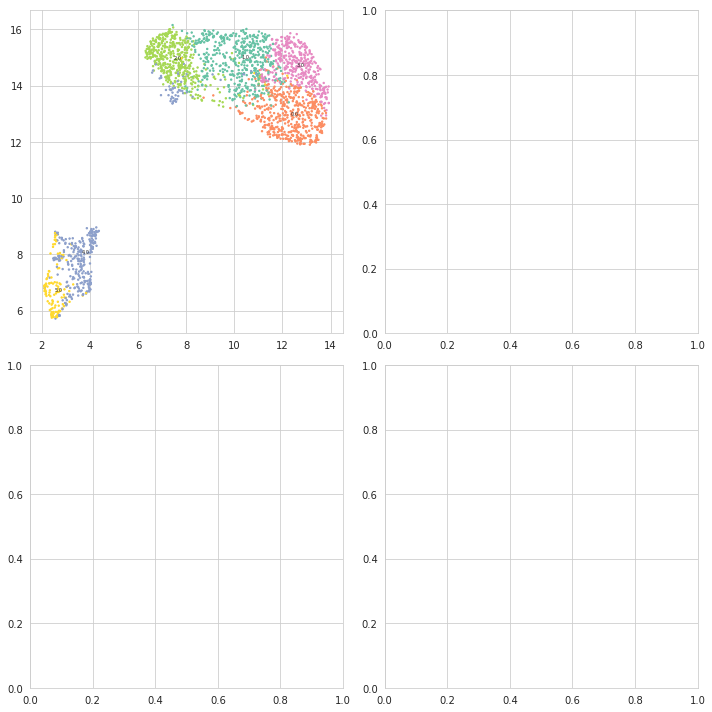

In [603]:
# #Classifier
classifier_matr = classifier_clustered_vis.drop(['phenograph_cluster'], axis=1)
projection_model = UMAP(n_components=2, n_neighbors=350,  metric='correlation',
                 random_state=42, transform_seed=42)
projection = pd.DataFrame(projection_model.fit_transform(classifier_matr),
                          columns=['v0', 'v1'])

# projection_model = MulticoreTSNE.MulticoreTSNE(n_jobs=10, perplexity=350, random_state=42,n_iter=5000)
# projection = projection_model.fit_transform(sample_data_matr)
cluster_centers = pd.concat([projection, classifier_clustered_vis['phenograph_cluster'].reset_index()], axis=1)
cluster_centers = cluster_centers.groupby('phenograph_cluster').median().reset_index()

cluster_pallete = {
    i[1]: i[0]
    for i in zip(sns.color_palette('Set2', n_colors=len(classifier_clustered_vis['phenograph_cluster'].unique())),
                 classifier_clustered_vis['phenograph_cluster'].unique())
}
ax.scatter(projection['v0'],
           projection['v1'],
           s=2,
           c=classifier_clustered_vis['phenograph_cluster'].map(cluster_pallete)
)
for _, row in cluster_centers.iterrows():
    ax.annotate(row['phenograph_cluster'], row[['v0', 'v1']], size=5)
plt.tight_layout()

# Feature selection

In [ ]:
subsample = textures_clustered_vis.groupby('phenograph_cluster', group_keys=False).apply(lambda x: x.sample(80))

In [ ]:
df_for_select = subsample
X, y = df_for_select.drop(['phenograph_cluster'], axis=1), df_for_select['phenograph_cluster']

In [ ]:
from xgboost import XGBClassifier,XGBRegressor
model = XGBClassifier()
Feature_Selector = BorutaShap(model=model, importance_measure='shap',
                              classification=True)

Feature_Selector.fit(X=X, y=y, n_trials=30, random_state=42)

In [ ]:
Feature_Selector.TentativeRoughFix()
Feature_Selector.plot(which_features='all', 
                      X_size=8, figsize=(12,8),
                      y_scale='log')

In [130]:
metric = ['11', '0', '4', '22', '13', '14', '2', '18', '19', '9', '3', '8', '26', '6', '5', '23', '29']
metric2 = ['ZernikeMoments_#24', 'HaralickFeatures_#12', 'ZernikeMoments_#17', 'TAS_#02', 'ZernikeMoments_#23', 'TAS_#10', 'ZernikeMoments_#06', 'TAS_#01', 'HaralickFeatures_#05', 'channel_1', 'TAS_#19', 'ZernikeMoments_#22', 'HaralickFeatures_#08', 'ZernikeMoments_#13', 'TAS_#26', 'TAS_#46', 'TAS_#39', 'HaralickFeatures_#11', 'TAS_#37', 'ZernikeMoments_#04', 'TAS_#29', 'TAS_#11', 'HaralickFeatures_#13', 'ZernikeMoments_#15', 'ZernikeMoments_#14', 'ZernikeMoments_#03', 'TAS_#08', 'HaralickFeatures_#06', 'TAS_#18', 'TAS_#28', 'TAS_#30', 'HaralickFeatures_#09', 'ZernikeMoments_#12', 'ZernikeMoments_#07', 'TAS_#43', 'TAS_#20', 'ZernikeMoments_#05', 'TAS_#09']